# How to run this file?
In this file, there are three cells: 'define functions', 'simulation', 'graphing' cell. 
- First, run the 'define functions' cell to define functions.
- After you run 'define functions' cell, you will see 'config parameters' section explains the parameters you can change in the next cell ('simulation' cell).
- After you modify parameters, run the 'simulation' cell. You will see '-------Simulation Start----------',..., until'----------Simulation Finished---------', meaning simulation completed. The processing time depends on the game length you select.
- Finally, run the 'graphing' cell. The result shows dynamics graphs over periods. The top left graph shows payoffs for each strategies over periods; The top right graph shows cdf; the bottom graph shows strategies over periods. 

New added:
- a dynamics with average payoffs compared to the NE payoff.
- modify the selection distance depends on bubble and max(y)
- evaulate sampling

Version 2.3
- modify leaving function (selection rule) and drop trembling if selected player choose not to move.
- new option for arriving function (including general and logit formula) and beta
- new option for replicator

Version 2.4
- In leaving function, the distance is calculated based on purified payoff v1.

Version 2.5
- Implement endogenous logit/linear leaving function w/o purification v1.

Version 2.6
- Implement threshold of moving in purification v1.

Version 2.7
- Add freezes period for endogenous part

In [1]:
#########################################################
########## run this cell to define functions ############
############### 'define functions' cell #################
#########################################################


########## configuration ############
import math

def sim_config_init(game_type= 'fear', lgr=(10,1.1,0.5), sampling=None, purification_v1=None, purification_v2=None, purification_v3=None,
                    trembling=0., bandwidth=None, 
                    num_bots=20, move_percent = 0.1, threshold_of_leaving = 0.3, game_length=1000, xrange=(2,10), clump=None, beta=None, exp=True, leaving_function='distance',
                    leaving_beta=1, endogenous_type='linear',freeze_period = 6, outlier_index_set=[1,3]):
    '''
    Specify simulation configuration parameters
    :param game_type: string, game type
    :param lgr: tuple, (lambda, gamma, rho), default to (10,1.1,0.5)
    :param sampling: int, number of players to sample (give each player an array of random other players to sample), default to None
    :param purification: idiosyncratic shifts of perceived landscape
    :param trembling: float, trembling range, default to 0, trembles in jump destination
    :param bandwidth: float, smoothing bandwidth, default to None
    :param num_bots: int, number of bots, default to 20
    :param game_length: int, game length, default to 1000
    :param xrange: tuple, strategy range
    :return: config, dictionary containing all simulation configuration parameters
    '''

    config = {}

    # set to -1 to disable
    config['sampling'] = sampling

    # constant e in purification specs
    # set to -1 to disable
    config['purification_v1'] = purification_v1
    
    config['purification_v2'] = purification_v2
    
    config['purification_v3'] = purification_v3

    # trembling range
    # set to 0 to have no effect
    config['trembling'] = trembling


    # smoothing bandwidth
    # set to -1 to disable
    config['bandwidth'] = bandwidth

    # game type
    config['game_type'] = game_type

    # lambda/gamma/rho params
    config['lambda'] = lgr[0]
    config['gamma'] = lgr[1]
    config['rho'] = lgr[2]

    # based on gamma and rho, override game type
    if (config['game_type'] != 'other') and (config['gamma'] >= (config['rho'] + 4/3)):
        config['game_type'] = 'greed'
    elif (config['game_type'] != 'other') and (config['gamma'] <= (config['rho'] + 2/3)):
        config['game_type'] = 'fear'

    # rush range (MUST BE CORRECT IF STARTING AT CDF)
    if config['game_type'] == 'fear':
        config['cdfmin'] = max(0, round((config['lambda'] - math.sqrt(1+config['lambda']**2) * math.sqrt(1-(16*(1+config['rho'])*(config['gamma']-1))/((config['gamma'] +3*config['rho'])*(3*config['gamma'] +config['rho'])))),2))
        config['cdfmax'] = config['lambda']
    elif config['game_type'] == 'greed':
        config['cdfmin'] = config['lambda']
        config['cdfmax'] = config['lambda'] + math.sqrt(1+config['lambda']**2)/(math.sqrt(1+16*config['rho']*config['gamma']/((3*config['gamma']-3*config['rho']-2)*(config['gamma']-config['rho']+2))))

    
    
    # number of bots
    config['num_bots'] = num_bots
    
    # move percentage
    config['move_percent'] = move_percent
    
    config['threshold_of_leaving'] = threshold_of_leaving
    

    # game length
    config['game_length'] = game_length

    # x bound
    if (config['game_type'] == 'fear') or (config['game_type'] == 'greed'):
        config['xmin'] = max(0 , config['cdfmin']-5)
        config['xmax'] = config['cdfmax'] + 8
    else:
        config['xmin'] = xrange[0]
        config['xmax'] = xrange[1]
        
    config['clump'] = clump
    
    #ariving function beta and exp
    config['beta'] = beta
    
    config['exp'] = exp
    
    #leaving function type: distance; endogenous; replicator
    config['leaving_function'] = leaving_function
    
    
    config['leaving_beta'] = leaving_beta

    #could be linear or logit
    config['endogenous_type'] = endogenous_type
    
    #freeze time in endogenous setting
    config['freeze_period'] = freeze_period
    
    #index of outliers
    config['outlier_index_set'] = outlier_index_set    
    
    return config

########## functions ############

import numpy as np
def get_position(n, seed, strats, sample_sets, config):
    '''

    :param n: float, timing n
    :param seed: index of player i, default to none
    :param strats: array, current strategies
    :param sample_sets: ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    :param config: dict, dictionary containing simulation parameters
    :return: float, position for timing n
    '''
    # positions are approximated more accurately by adding 0 to the value for greed and 1 for fear game
    if config['game_type'] == 'fear':
        pos = 1
    elif config['game_type'] == 'greed':
        pos = 0
    else:
        pos = 0.5
    samples = []
    # if using sampling, get the strategies of the sampled players
    if (seed is not None) and (config['sampling'] is not None):
        for samp in sample_sets[seed]:
            samples.append(strats[samp])
    # otherwise check all strategies
    else:
        samples = strats
    # compare to strategies to calculate position
    for strat in samples:
        if n > strat:
            pos = pos + 1
    return pos

# Returns ties at timing n
# optional parameter seed denotes which set of players to sample (-1 for no sampling)
def get_tie(n, seed, strats, sample_sets, config):
    '''

    :param n: float, timing n
    :param seed: index of player i, default to none
    :param strats: array, current strategies
    :param sample_sets: ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    :param config: dict, dictionary containing simulation parameters
    :return: float, ties for timing n
    '''
    # this is only here to fix rounding comparison issues
    n = round(n,2)

    tie = 0
    samples = []
    # if using sampling, get the strategies of the sampled players
    if (seed is not None) and (config['sampling'] is not None):
        for samp in sample_sets[seed]:
            samples.append(strats[samp])
    # otherwise check all strategies
    else:
        samples = strats
    # compare to strategies to calculate position
    for strat in samples:
        # more rounding stuff due to float precision errors
        strat = round(strat, 2)
        if n == strat:
            tie = tie + 1
    return tie

def get_index(n, seed, strats, sample_sets, config):
    '''

    :param n: float, timing n
    :param seed: index of player i, default to none
    :param strats: array, current strategies
    :param sample_sets: ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    :param config: dict, dictionary containing simulation parameters
    :return: float, ties for timing n
    '''
    # this is only here to fix rounding comparison issues
    n = round(n,2)

    samples = []
    # if using sampling, get the strategies of the sampled players
    if (seed is not None) and (config['sampling'] is not None):
        for samp in sample_sets[seed]:
            samples.append(strats[samp])
        # find the right closest strategy's index
        samples_minus_n = samples - n
        samples_minus_n = np.round(samples - n, 2)
        test_tie_positive = np.any(samples_minus_n>0)
        if (samples_minus_n==0).any() == True:
            sample_index = np.where(samples_minus_n == 0)[0]
            index = []
            for i in sample_index:
                index.append(sample_sets[seed][i])
        elif test_tie_positive == True:
            samples_minus_n_min = min([i for i in samples_minus_n if i > 0])
            sample_index = np.where(samples_minus_n == samples_minus_n_min)[0][0]
            index = sample_sets[seed][sample_index]
        else:
            index = config['sampling']


    # otherwise check all strategies
    else:
        samples = strats
        samples_minus_n = samples - n
        samples_minus_n = np.round(samples - n, 2)
        test_tie_positive = np.any(samples_minus_n>0)
        if (samples_minus_n==0).any() == True:
            index = np.where(samples_minus_n == 0)[0]
        elif test_tie_positive == True:
            samples_minus_n_min = min([i for i in samples_minus_n if i > 0])
            index = np.where(samples_minus_n == samples_minus_n_min)[0][0]
        else:
            index = len(strats)
    


    return index


def get_initial_y(n, strats, sample_sets, config, seed=None, use_bandwidth=False):
    '''
    Calculate player's unpurified payoff at period 0
    :param n: float, timing n
    :param strats: array, current strategies
    :param sample_sets: ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    :param config: dict, dictionary containing simulation parameters
    :param seed: index of player i, default to none
    :param use_bandwidth:
    :return: float, payoff
    '''
    # calculate the timing component
    ux = 1 + (2 * config['lambda'] * n) - (n * n)
    ties = get_tie(n, seed, strats, sample_sets, config)
    pos = get_position(n, seed, strats, sample_sets, config)
    puriVal = 1
    vy = (1 - (pos * puriVal/len(strats))/config['gamma']) * (1 + (pos * puriVal/len(strats)/config['rho']))
    # if there are ties, calculate the average of the position components over the tie range
    if ties > 0:
        vy = 0
        for j in range(ties):
            vy += (1 - ((pos+j) * puriVal/len(strats))/config['gamma']) * (1 + ((pos+j) * puriVal/len(strats))/config['rho'])
        vy = vy/ties
    # otherwise just use the regular formula
    if (config['bandwidth'] is not None) and use_bandwidth:
        ux = 0
        start_x = n - config['bandwidth']
        for i in range(21):
            ux += 1 + (2 * config['lambda'] * start_x) - (start_x * start_x)
            start_x += config['bandwidth']/10
        ux = ux/21
    return ux * vy


# Returns the payoff at timing n
def get_y(n, strats, initial_strategies,index, sample_sets, config, seed=None, use_bandwidth=False):
    '''
    calculate players' payoffs at period t w/o purification (only use for the selected players) 
    :param n: float, timing n
    :param strats: array, current strategies
    :param sample_sets: ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    :param config: dict, dictionary containing simulation parameters
    :param seed: index of player i, default to none
    :param use_bandwidth:
    :return: float, payoff
    '''
    # calculate the timing component
    if config['purification_v2'] is not None:
        purification_v2 = config['purification_v2']
    else:
        purification_v2 = 0.
    
    if config['purification_v1'] is not None:
        purification_v1 = config['purification_v1']
    else:
        purification_v1 = 0.
        
    num_bots = config['num_bots']
    #purification v1 parameter
    h = (2 * purification_v1 * index) / (num_bots - 1) - purification_v1
#     ux = 1 + (2 * config['lambda'] *(1-h)* n) - (n * n*(1-h)*(1-h))
    ux = 1 + (2 * config['lambda'] *(1+h)* n) - (n * n*(1+h)*(1+h))
    
    ties = get_tie(n, seed, strats, sample_sets, config)
    pos = get_position(n, seed, strats, sample_sets, config)
    #purification v2 parameter
    e = (2 * purification_v2 * index) / (num_bots - 1) - purification_v2
    
    if ties == 0:
        q = pos/len(strats)
        vy = (1 - ((1-e)*q)/config['gamma']) * (1 + ((1-e)*q)/config['rho'])
    # if there are ties, calculate the average of the position components over the tie range
    elif ties > 0:
        vy = 0
        for j in range(ties):
            vy += (1 - ((1-e)*(pos+j)/len(strats))/config['gamma']) * (1 + ((1-e)*(pos+j)/len(strats))/config['rho'])
        vy = vy/ties
    # otherwise just use the regular formula
    if (config['bandwidth'] is not None) and use_bandwidth:
        ux = 0
        start_x = n - config['bandwidth']
        for i in range(21):
            ux += 1 + (2 * config['lambda'] * start_x) - (start_x * start_x)
            start_x += config['bandwidth']/10
        ux = ux/21
    if config['purification_v3'] is not None:
        purification_v3 = config['purification_v3']
        gx = 1+ max(0, round(purification_v3-abs(n-initial_strategies[index]),2))
    else:
        gx = 1
#     print('pos is {}'.format(pos))
#     print('index is {}'.format(index))
#     print('e is {}'.format(e))
#     print('vy is {}'.format(vy))
#     print('ux is {}'.format(ux))
    return ux * vy * gx


def stategies_get_y(n, strats,index, sample_sets, config, seed=None, use_bandwidth=False):
    '''
    Calculate players' unpurified payoffs at period t (use for payoff landscape)
    :param n: float, timing n
    :param strats: array, current strategies
    :param sample_sets: ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    :param config: dict, dictionary containing simulation parameters
    :param seed: index of player i, default to none
    :param use_bandwidth:
    :return: float, payoff
    '''
    # calculate the timing component
    num_bots = config['num_bots']

    ux = 1 + (2 * config['lambda'] * n) - (n * n)
    ties = get_tie(n, seed, strats, sample_sets, config)
    pos = get_position(n, seed, strats, sample_sets, config)
    if ties == 0:
        q = pos/len(strats)
        vy = (1 - q/config['gamma']) * (1 + q/config['rho'])
    # if there are ties, calculate the average of the position components over the tie range
    elif ties > 0:
        vy = 0
        for j in range(ties):
            vy += (1 - ((pos+j)/len(strats))/config['gamma']) * (1 + ((pos+j)/len(strats))/config['rho'])
        vy = vy/ties
    # otherwise just use the regular formula
    if (config['bandwidth'] is not None) and use_bandwidth:
        ux = 0
        start_x = n - config['bandwidth']
        for i in range(21):
            ux += 1 + (2 * config['lambda'] * start_x) - (start_x * start_x)
            start_x += config['bandwidth']/10
        ux = ux/21

#     print('pos is {}'.format(pos))
#     print('index is {}'.format(index))
#     print('e is {}'.format(e))
#     print('vy is {}'.format(vy))
#     print('ux is {}'.format(ux))
    return ux * vy

def data_logging(var_name_list, round_num, history):
    for var in var_name_list:
        history[var, round_num] = eval({var})

    return history


########## simulation functions ############
import random
import numpy as np
import pandas as pd
# from timing_games_package import Functions as fun

def initialize_player_strategies(config):
    '''
    Function to run first simulation step to initialize each player's initial strategy
    :param config: dict, dictionary contains simulation parameters
    :return: array, initial strategies;  ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    '''
    # game type for starting distribution: set to fear or greed for respective distributions
    # any value other than fear or greed will yield a random start
    game = config['game_type']
    num_bots = config['num_bots']
    lam = config['lambda']
    gam = config['gamma']
    rho = config['rho']
    sampling = config['sampling']
    xmin = config['xmin']
    xmax = config['xmax']

    strategies = []
    sample_sets = []

    # set initial strategies and sampling
    # these calculations are inexact because we have a finite number of players
    # greed, fear, and random starting distributions have differing calculations
    if game == "fear":
        cdfx = np.round(np.arange(config['cdfmin'], config['cdfmax'], 0.01), 2)
        cdfy = gam - rho + np.sqrt((gam + rho) ** 2 - 4 * ((1 + rho) * (gam - 1) * (1 + lam ** 2))/(1 + 2 * lam * cdfx - cdfx ** 2))
        y_ind = 0
        cdfy = cdfy/2
        for i in range(num_bots):
            # y_ind is the index in the cdf to compare to
            # we increment it until it is greater than or equal to the percentage of players set so far
            if (i+1)/num_bots <= cdfy[y_ind]:
                strategies.append(cdfx[y_ind])
            else:
                while y_ind < len(cdfy) - 1 and (i+1)/num_bots > cdfy[y_ind]:
                    y_ind = y_ind + 1
                # there are some rounding issues when we reach the end of the cdf
                # if we reach the end (for the last few players), just use the last value
                if y_ind >= len(cdfy):
                    strategies.append(cdfx[len(cdfy)])
                else:
                    strategies.append(cdfx[y_ind])
#         strategies = np.sort(strategies)[::-1]

    elif game == "greed":
        cdfx = np.round(np.arange(config['cdfmin'], config['cdfmax'], 0.01), 2)
        cdfy = gam - rho - np.sqrt((gam + rho) ** 2 - 4 * gam * rho * (1 + lam ** 2) / (1 + 2 * lam * cdfx - cdfx ** 2))
        y_ind = len(cdfy) - 1
        cdfy = cdfy / 2

        i = num_bots
        while i > 0:
            # y_ind is the index in the cdf to compare to
            # we decrement it until it is less than or equal to the percentage of players set so far
            if (i-1)/num_bots >= cdfy[y_ind]:
                strategies.append(cdfx[y_ind])
            else:
                while y_ind > 0 and (i-1)/num_bots < cdfy[y_ind]:
                    y_ind = y_ind - 1
                # there are some rounding issues when we reach the end of the cdf
                # if we reach the end (for the last few players), just use the last value
                if y_ind == 0:
                    strategies.append(cdfx[0])
                else:
                    strategies.append(cdfx[y_ind])
            i = i - 1

    #uniform distribution
    else:
        if config['clump'] is None:
            for i in range(num_bots):
                strategies.append(random.random() * (xmax - xmin) + xmin)
        else:
            for i in range(num_bots):
                strategies.append(random.random()*config['clump'] + (xmax+xmin)/2)            


    strategies = np.round(np.array(strategies), 2)
    strategies = np.sort(strategies)

    # apply sampling
    for i in range(num_bots):
        if sampling is not None:
            other_player_index_list = list(range(num_bots))
            other_player_index_list.remove(i)
            to_add = random.sample(other_player_index_list, sampling)
            sample_sets.append(to_add)
            
    initial_strategies = strategies

    return strategies, sample_sets, initial_strategies

def other_game_initial_strategies(config):
    '''
    Function to run first simulation step to initialize each player's initial strategy in other games
    :param config: dict, dictionary contains simulation parameters
    :return: array, initial strategies;
    '''
    # game type for starting distribution: set to fear or greed for respective distributions
    # any value other than fear or greed will yield a random start
    game = config['game_type']
    num_bots = config['num_bots']
    lam = config['lambda']
    gam = config['gamma']
    rho = config['rho']
    sampling = config['sampling']
    xmin = config['xmin']
    xmax = config['xmax']

    strategies = []
    sample_sets = []

    # set initial strategies and sampling
    # these calculations are inexact because we have a finite number of players
    # greed, fear, and random starting distributions have differing calculations
    if game == "fear":
        cdfx = np.round(np.arange(config['cdfmin'], config['cdfmax'], 0.01), 2)
        cdfy = gam - rho + np.sqrt((gam + rho) ** 2 - 4 * ((1 + rho) * (gam - 1) * (1 + lam ** 2))/(1 + 2 * lam * cdfx - cdfx ** 2))
        y_ind = 0
        cdfy = cdfy/2
        for i in range(num_bots):
            # y_ind is the index in the cdf to compare to
            # we increment it until it is greater than or equal to the percentage of players set so far
            if (i+1)/num_bots <= cdfy[y_ind]:
                strategies.append(cdfx[y_ind])
            else:
                while y_ind < len(cdfy) - 1 and (i+1)/num_bots > cdfy[y_ind]:
                    y_ind = y_ind + 1
                # there are some rounding issues when we reach the end of the cdf
                # if we reach the end (for the last few players), just use the last value
                if y_ind >= len(cdfy):
                    strategies.append(cdfx[len(cdfy)])
                else:
                    strategies.append(cdfx[y_ind])


    elif game == "greed":
        cdfx = np.round(np.arange(config['cdfmin'], config['cdfmax'], 0.01), 2)
        cdfy = gam - rho - np.sqrt((gam + rho) ** 2 - 4 * gam * rho * (1 + lam ** 2) / (1 + 2 * lam * cdfx - cdfx ** 2))
        y_ind = len(cdfy) - 1
        cdfy = cdfy / 2

        i = num_bots
        while i > 0:
            # y_ind is the index in the cdf to compare to
            # we decrement it until it is less than or equal to the percentage of players set so far
            if (i-1)/num_bots >= cdfy[y_ind]:
                strategies.append(cdfx[y_ind])
            else:
                while y_ind > 0 and (i-1)/num_bots < cdfy[y_ind]:
                    y_ind = y_ind - 1
                # there are some rounding issues when we reach the end of the cdf
                # if we reach the end (for the last few players), just use the last value
                if y_ind == 0:
                    strategies.append(cdfx[0])
                else:
                    strategies.append(cdfx[y_ind])
            i = i - 1

    #uniform distribution
    else:
        for i in range(num_bots):
            strategies.append(random.random() * (xmax - xmin) + xmin)


    strategies = np.round(np.array(strategies), 2)
    strategies = np.sort(strategies)           
    initial_strategies = strategies

    return initial_strategies


def calculate_initial_payoff(config, strategies, sample_sets):
    '''
    calculate payoff at every x at period 0
    :param config: dict, dictionary contains simulation parameters
    :param strategies: array, current strategies
    :param sample_sets: ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    :return: x: array of possible x; y: array of payoff given timing x; strat_x: sorted strategies from low to high;
             strat_y: array of payoffs given sorted strategies; strategies_y: array of payoffs given strategies
    '''

    lam = config['lambda']
    gam = config['gamma']
    rho = config['rho']
    xmin = config['xmin']
    xmax = config['xmax']
    # set the array of possible x values
    x = np.round(np.arange(xmin, xmax, 0.01),2)
    positions = []
    ties = []
    # set up initial values for landscape positions and ties
    for val in x:
        positions.append(get_position(val, None, strategies, sample_sets, config))
        ties.append(get_tie(val, None, strategies, sample_sets, config))
    positions = np.array(positions)
    # calculate timing component
    ux = 1 + (2 * lam * x) - (x * x)
    vy = []
    quantile = []
    # calculate positional component, including ties
    for i in range(len(positions)):
        if ties[i] == 0:
            vy.append((1 - (positions[i]/len(strategies))/gam) * (1 + (positions[i]/len(strategies))/rho))
            quantile.append(positions[i]/len(strategies))
        else:
            total = 0
            total_quantile = 0
            for j in range(ties[i]):
                total += (1 - ((positions[i]+j)/len(strategies))/gam) * (1 + ((positions[i]+j)/len(strategies))/rho)
                total_quantile += (positions[i])/len(strategies)
            total = total/ties[i]
            vy.append(total)
            total_quantile = total_quantile/ties[i]
            quantile.append(total_quantile)
            
    quantile = np.array(quantile)
    if config['game_type'] == 'fear':
        quantile = quantile - 1/config['num_bots']
    elif config['game_type'] == 'other':
        quantile = quantile - 0.5/config['num_bots']    
        
    y = ux * vy
    strategies_y = []
    bubble = []
    # calculate bubble positions
    for strat in strategies:
        bubble.append(get_initial_y(strat, strategies, sample_sets, config, seed=None, use_bandwidth=False))
    for index,strat in enumerate(strategies):
        strategies_y.append(get_y(strat, strategies, initial_strategies, index, sample_sets, config, seed=None, use_bandwidth=False))
    return x, y, strategies_y, quantile, bubble

def calculate_payoff(config, static_strategies, strategies, sample_sets):
    '''
    calculate every x at period t
    :param config: dict, dictionary contains simulation parameters
    :param strategies: array, current strategies
    :param sample_sets: ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    :return: x: array of possible x; y: array of payoff given timing x; strat_x: sorted strategies from low to high;
             strat_y: array of payoffs given sorted strategies; strategies_y: array of payoffs given strategies
    '''

    lam = config['lambda']
    gam = config['gamma']
    rho = config['rho']
    xmin = config['xmin']
    xmax = config['xmax']
    num_bots = config['num_bots']
    
        
    # set the array of possible x values
    x = np.round(np.arange(xmin, xmax, 0.01),2)
    positions = []
    ties = []
    index = []

    # set up initial values for landscape positions and ties
    for val in x:
        positions.append(get_position(val, None, strategies, sample_sets, config))
        ties.append(get_tie(val, None, strategies, sample_sets, config))
    positions = np.array(positions)
    # calculate timing component
    ux = 1 + (2 * lam * x) - (x * x)
    vy = []
    quantile = []
    # calculate positional component, including ties
    for i in range(len(positions)):
        if ties[i] == 0:
            q = positions[i]/len(strategies)
            vy.append((1 - q/gam) * (1 + q/rho))
            quantile.append(q)
        else:
            total = 0
            total_quantile = 0
            for j in range(ties[i]):
                total += (1 - ((positions[i]+j)/len(strategies))/gam) * (1 + ((positions[i]+j)/len(strategies))/rho)
                total_quantile += (positions[i])/len(strategies)
            total = total/ties[i]
            vy.append(total)
            total_quantile = total_quantile/ties[i]
            quantile.append(total_quantile)
        
    quantile = np.array(quantile)
    if config['game_type'] == 'fear':
        quantile = quantile - 1/config['num_bots']
    elif config['game_type'] == 'other':
        quantile = quantile - 0.5/config['num_bots']
        
            
    y = ux * vy
    
    strategies_y = []
    bubble = []
    # calculate bubble positions
    
    for index,strat in enumerate(strategies):
        strategies_y.append(get_y(strat, strategies, initial_strategies, index, sample_sets, config, seed=None, use_bandwidth=False))
    for bub in strategies:
        bubble.append(stategies_get_y(bub, strategies, index, sample_sets, config, seed=None, use_bandwidth=False))
    return x, y, strategies_y, quantile, bubble

# Loops through all players and moves them if they are ready to move
def update_player_strategies(x, y, strategies, strategies_y, bubble, initial_strategies, sample_sets, config, static_remaining_freeze_period):
    '''

    :param x: numpy array, array of possible x
    :param y: numpy array, payoff array w.r.t each element in x
    :param strategies: list, list containing previous strategies of each player
    :param config: dict, dictionary containing simulation parameters
    :return: strategies: list, list containing updated strategies of each player
    '''

    trembling = config['trembling']
    move_size = round(config['move_percent'] *config['num_bots'])
    static_strategies = strategies.copy()
    outlier_index_set = config['outlier_index_set']
    cdfmin = config['cdfmin']
    cdfmax = config['cdfmax']
    xmin = config['xmin']
    xmax = config['xmax']
    game_type = config['game_type']
    
    best_possible = max(y)

    # jump frequencies proportional to regret (if leaving function is distance or endogenous)
    if config['leaving_function'] != 'replicator':
        distances_from_best_payoff = abs(bubble-best_possible)
        players_index = list(range(len(strategies)))
        
        
    ##the leaving function is based on purified payoff version 1
        if config['purification_v1'] is not None:
            max_purified_payoff = []
            for player in players_index:
#                 print(player)
                individual_purified_landscape=[]
                for val in x:
                    individual_purified_landscape.append(get_y(val, static_strategies,initial_strategies, player, sample_sets, config, seed=None, use_bandwidth=True))
                max_purified_payoff.append(max(individual_purified_landscape))
            max_purified_payoff=np.array(max_purified_payoff)
#             print(max_purified_payoff)
#             print(strategies_y)
            distances_from_best_payoff = abs(max_purified_payoff-strategies_y) 
#             print(distances_from_best_payoff)
        
        distances_from_best_payoff = np.round(distances_from_best_payoff, decimals=2)
#         print(distances_from_best_payoff)
        
        if config['leaving_function'] == 'distance':
            
            if config['threshold_of_leaving'] is None:
                n=0
                selected_player_index = set([])

                while n < move_size:
            #         print('players_index is {}'.format(players_index))
            #         print('distances_from_best_payoff is {}'.format(distances_from_best_payoff))
                    chosen_one = random.choices(players_index, weights=distances_from_best_payoff,k=1)
            #         print('chosen_one is {}'.format(chosen_one))
                    selected_player_index.update(chosen_one)
            #         print('selected_player_index is {}'.format(selected_player_index))
                    index = players_index.index(chosen_one[0])
            #         print('index is {}'.format(index))
                    del players_index[index]
            #         print('new players_index is {}'.format(players_index))
                    distances_from_best_payoff = np.delete(distances_from_best_payoff, index)
            #         print('new distances_from_best_payoff is {}'.format(distances_from_best_payoff))
                    n+=1
            #         print(n)
                    sum_weights = math.fsum(distances_from_best_payoff)
            #         print('sum weights is {}'.format(sum_weights))
                    if sum_weights == 0:
                        break
                if len(selected_player_index) != move_size:
                    remaining = random.sample(players_index,k=move_size-n)
            #         print('remaining is {}'.format(remaining))
                    selected_player_index.update(remaining)
            #         print(selected_player_index)
            else:
                selected_player_index=[]
                for idx in range(len(strategies)):
                    if distances_from_best_payoff[idx] > config['threshold_of_leaving']:
                        selected_player_index.append(idx)
#                 print(selected_player_index)
        
        elif config['leaving_function'] == 'endogenous':
            
            selected_player_index=[]
            
            if config['endogenous_type'] == 'logit':
            
                if config['purification_v1'] is None:
                    for i in players_index:
                        binary_payoff_with_beta = np.power([bubble[i], best_possible], config['leaving_beta'])
                        indice = random.choices([0,1], weights=binary_payoff_with_beta,k=1)
                        if (indice[0] == 1) & (static_remaining_freeze_period[i]==0):
                            selected_player_index.append(i)
                else:
                    for i in players_index:
                        binary_payoff_with_beta = np.power([strategies_y[i], max_purified_payoff[i]], config['leaving_beta'])
                        indice = random.choices([0,1], weights=binary_payoff_with_beta,k=1)
                        if (indice[0] == 1) & (static_remaining_freeze_period[i]==0):
                            selected_player_index.append(i)
            
            elif config['endogenous_type'] == 'linear':
                
                distances_from_best_payoff = np.power(distances_from_best_payoff, config['leaving_beta'])
#                 print(distances_from_best_payoff)
                range_of_distance = max(distances_from_best_payoff)-min(distances_from_best_payoff)   
                weights_to_be_selected = np.round((distances_from_best_payoff-min(distances_from_best_payoff))/range_of_distance, decimals=2)
                
#                 print(weights_to_be_selected)
                for i in players_index:
                    indice = random.choices([1,0], weights=[weights_to_be_selected[i], 1-weights_to_be_selected[i]],k=1)
                    if (indice[0] == 1) & (static_remaining_freeze_period[i]==0) :
                        selected_player_index.append(i) 
#                 print(selected_player_index)
    ###arriving function

        for i in selected_player_index:
        # find best payoff index
            index = i
            if config['sampling'] is not None:
                y1 = []
                for val in x:
                    y1.append(get_y(val, static_strategies,initial_strategies, index, sample_sets, config, seed=i, use_bandwidth=True))
                best = max(y1)
                # if there are multiple timings with the best payoff, choose randomly
                indices = [k for k, j in enumerate(y1) if j == best]
                best_choice = random.choice(indices)
                best_choice = x[best_choice]   

            elif config['purification_v1'] is not None:
                y1 = []
                for val in x:
                    y1.append(get_y(val, static_strategies,initial_strategies, index, sample_sets, config, seed=None, use_bandwidth=True))
                best = max(y1)
                # if there are multiple timings with the best payoff, choose randomly
                indices = [k for k, j in enumerate(y1) if j == best]
                best_choice = random.choice(indices)
                best_choice = x[best_choice]

            elif config['purification_v2'] is not None:
                y1 = []
                for val in x:
                    y1.append(get_y(val, static_strategies,initial_strategies, index, sample_sets, config, seed=None, use_bandwidth=True))
                best = max(y1)
                # if there are multiple timings with the best payoff, choose randomly
                indices = [k for k, j in enumerate(y1) if j == best]
                best_choice = random.choice(indices)
                best_choice = x[best_choice]

            elif config['purification_v3'] is not None:
                y1 = []
                for val in x:
                    y1.append(get_y(val, static_strategies,initial_strategies, index, sample_sets, config, seed=None, use_bandwidth=True))
                best = max(y1)
                # if there are multiple timings with the best payoff, choose randomly
                indices = [k for k, j in enumerate(y1) if j == best]
                best_choice = random.choice(indices)
                best_choice = x[best_choice]    

            elif config['beta'] is not None:
#                 y_norm = y/best_possible
                y_norm = y
                if config['exp'] is False:
                    y_with_beta = np.power(y_norm, config['beta'])
                    chosen_x = random.choices(x, weights=y_with_beta,k=1)
                    best_choice = chosen_x[0]
                else:
                    y_with_beta_exp = np.exp(config['beta']*y_norm)
    #                 print(y)
    #                 print(config['beta']*y)
    #                 print(y_with_beta_exp)
                    chosen_x = random.choices(x, weights=y_with_beta_exp,k=1)
                    best_choice = chosen_x[0]

            else:
                indices = [k for k, j in enumerate(y) if j == best_possible]
                best_choice = random.choice(indices)
                best_choice = x[best_choice]                

        
            if best_choice == static_strategies[index]:    
                strategies[i] = best_choice
#                 strategies[i] = best_choice + round((random.random() * trembling - trembling/2), 2)
            else:
#                 strategies[i] = best_choice + round((random.random() * trembling - trembling/2), 2)
                if game_type == 'fear':
                    strategies[i] = best_choice + round((random.random() * trembling - trembling/2), 2) + round((random.random() * 0.3 - 0.3), 2)
                elif game_type == 'greed':
                    strategies[i] = best_choice + round((random.random() * trembling - trembling/2), 2) + round((random.random() * 0.3 - 0), 2)
               
            if i in outlier_index_set:
                strategies[i] = round(random.random() * (cdfmax - cdfmin) + cdfmin, 2)
#         print(strategies)
###########################################        
        #replicator
    elif config['leaving_function'] == 'replicator':
        players_index = list(range(len(strategies)))
        #assign rank based on payoff from lowest to highest
        ranks = pd.Series(bubble)
        ranks=ranks.sample(frac=1).rank(method='first').reindex_like(ranks).astype('int').to_list()
#         print('bubble {}'.format(bubble))
#         print('strategies {}'.format(strategies))
#         print('ranks {}'.format(ranks))
        ranks_array = np.array(ranks)

        #calculate seletion prob based on 1-(r-1)/(N-1)
        selection_prob = 1-(ranks_array-1)/(len(ranks)-1)
#         print('prob {}'.format(selection_prob))


        # reorder index and selection prob based on ranking
        sorted_index=[]
        sorted_prob = []
        for n in range(1, len(ranks)+1):
            for i in range(len(ranks)):
                if ranks[i] == n:
                    sorted_index.append(players_index[i])
                    sorted_prob.append(selection_prob[i])
#         print('sorted index {}'.format(sorted_index))
#         print('sorted prob {}'.format(sorted_prob))

        #leaving function: who is selected based on selection prob
        pre_selected_player_index=[]
        
        for ind, player in enumerate(sorted_index):
            yes_or_no = random.choices([1,0], weights=[sorted_prob[ind], 1-sorted_prob[ind]], k=1)
            if yes_or_no[0] == 1:
                pre_selected_player_index.append(player)
#         print(sorted_index)
#         print(pre_selected_player_index)
        
        if len(pre_selected_player_index) > move_size:
            selected_player_index = random.sample(pre_selected_player_index, k=move_size)
#             print('True')
#             print(selected_player_index)
        else:
            selected_player_index = pre_selected_player_index
#             print('False')
#             print(selected_player_index)
        
#         num_selected_player = 0
#         ind = 0
#         while num_selected_player < move_size:
#             #if selected, return 1
#             yes_or_no = random.choices([1,0], weights=[sorted_prob[ind], 1-sorted_prob[ind]], k=1)
#             if yes_or_no[0] == 1:
#                 selected_player_index.append(sorted_index[ind])
#                 num_selected_player += 1
#                 sorted_prob.pop(ind)
#                 sorted_index.pop(ind)
#             else:
#                 ind += 1
#             if (ind>=len(sorted_index)) & (num_selected_player<move_size):
#                 ind = 0    
#             print('selected set {}'.format(selected_player_index))

        #avg payoff over population
        avg = sum(bubble)/len(bubble)
        payoff_distance = [max(0,payoff-avg) for payoff in bubble]
#         print('payoff distance {}'.format(payoff_distance))
        sum_payoff_distance = sum(payoff_distance)
#         print('sum payoff distance {}'.format(sum_payoff_distance))
        # a player imitates the player's strategy which is higher than avg payoff population with trembling
        if sum_payoff_distance > 0:
            for i in selected_player_index:
                replicate_to = random.choices(players_index, weights=payoff_distance, k=1)
#                 print(i,replicate_to[0])
                if i != replicate_to[0]:
                    strategies[i] = static_strategies[replicate_to[0]] + round((random.random() * trembling - trembling/2), 2)
#                 print(strategies)
        else:
#             print('equal weight')
            for i in selected_player_index:
                replicate_to = random.choice(players_index)
#                 print(i,replicate_to)
                if i != replicate_to:
                    strategies[i] = static_strategies[replicate_to] + round((random.random() * trembling - trembling/2), 2)
#                 print(strategies)


    
    return static_strategies, strategies, selected_player_index, distances_from_best_payoff


# from timing_games_package import Simulation
# from timing_games_package.Configuration import sim_config_init
import matplotlib.pyplot as plt
# import matplotlib.animation as animation
from matplotlib import style
import numpy as np
import pandas as pd
plt.style.use('default')

def update_remaining_freeze_period(static_remaining_freeze_period, selected_player_index, config):
    for i in range(len(static_remaining_freeze_period)):
#         print(i)
        if i in selected_player_index:
            static_remaining_freeze_period[i] = config['freeze_period']
#             print(static_remaining_freeze_period)
        else:
            if static_remaining_freeze_period[i] != 0:
                static_remaining_freeze_period[i] -= 1
    return static_remaining_freeze_period
            


# config parameters (you can change values in the cell below)

`game_type`: game type. It could be 'fear' or 'greed', or 'other'.
- `game_type` is optional for only fear or only greed game. For example, if you specify `game_type='greed'` while $\gamma \leq \rho + 2/3$, the code will override game type you specified and force it to 'fear' instead.
- If you choose 'other', the initial strategies will be selected based on uniform distribution. You need to specify the range `xrange`.

`lgr`: lambda/gamma/rho params: (lambda, gamma, rho)
- `lgr=(10,1.1,0.5)` means (lambda, gamma, rho)=(10, 1.1, 0.5)

||game type|
|--|--|
|$\gamma \leq \rho + 2/3$|only fear game|
|$\rho + 2/3 < \gamma < \rho + 4/3 $|fear or greed equilibrium|
|$\gamma \geq \rho + 4/3 $|only greed|


`sampling`: number of players to sample. Give each player an array of random other players to sample, default to None.
- `sampling=None` means players could observe all other players' moves.
- `sampling=5` means players could only observe 5 other players' moves.

`purification`: idiosyncratic shifts of perceived landscape. It could be 0.1, 0.2 etc.
- u(x)v((1-e)q), with e=2di/(N-1)-d for i=0,...N-1 when num_bots=N. Specifically, d=purification.
- `purification=None` meaning purification is disabled.


`trembling`: trembling range (set to 0 to have no effect. It could be 0.1, 0.2, etc

`bandwidth`: smoothing bandwidth (set None to disable). It could be 0.1, 0.2, etc


`num_bots`: number of bots

`move_percent`: the percent of players that move each period. It could be 0.1, 0.2, etc.
- fully asynchronous if `move_percent=1/number of bots` (meaning only one player moves per period)
- fully synchronous if `move_percent=1.0` (meaning all players move per period)

Example: if `num_bots=20` and `move_percent=0.05`, we have fully asynchronicity; if `num_bots=20` and `move_percent=1.0`, we have fully synchronicity.


`game_length`: game length. Simulation periods

`xrange`: you need to specify x range if the game type is 'other'.



# selected parameters based on theory

|$\lambda$|$\gamma$|$\rho$|game type|rush size|rush time|slow play on|Nah payoff|
|--|--|--|--|--|--|--|--|
|10|1.1|0.5| only fear|q0=0.45|1.26|[1.26,10]| 27.545| 
|10|1.5|0.5| fear equilibrium|q0=0.75|5.51|[5.51,10]| 100.90|
|10|1.5|0.5| greed equilibrium|q1=0.25|14.49|[10,14.49]| 101|
|10|2|0.5| only greed|q1=0.725|15.97|[10,15.97]| 101|
|10|2.5|2| only fear|q0=0.375|6.69|[6.69,10]| 90.9| 
|10|2.5|1.7| fear equilibrium|q0=0.6|7.28|[7.28,10]| 96.2|
|10|2.5|1.7| greed equilibrium|q1=0.1|11.27|[10,11.27]| 101|
|10|2.5|1.3| fear equilibrium|q0=0.9|8.58|[8.58,10]| 107.2|
|10|2.5|1.3| greed equilibrium|q1=0.4|13|[10,13]| 101|
|10|2.5|1| only greed|q1=0.625|14.25|[10,14.25]| 101|
|10|3|2| fear equilibrium|q0=0.75|8.25|[8.25,10]| 101|
|10|3|2| greed equilibrium|q1=0.25|11.74|[10,11.74]| 101|
|10|3.6|2| only greed|q1=0.7|12.85|[10,12.85]| 101|


This is only fear game
----------------Simulation Start----------------
Period 0 done
Period 20 done
Period 40 done
Period 60 done
Period 80 done
Period 100 done
Period 120 done
Period 140 done
Period 160 done
Period 180 done
Period 200 done
----------------Simulation Finished----------------
The initial strategies [4.34 4.53 4.78 5.1  5.54 6.16 7.12 9.99]
The second strategies [4.34 9.55 4.78 5.1  4.78 6.16 7.12 9.99]
The third strategies [4.34 9.55 4.78 5.1  4.78 9.28 9.42 9.31]
The initial distances from the best purified/unpurified payoffs [0.07 0.04 0.   0.05 0.03 0.03 0.06 0.08]
The initial distances from the best purified/unpurified payoffs [5.89 0.   4.57 5.87 4.57 1.58 0.81 5.9 ]
The initial distances from the best purified/unpurified payoffs [16.12 16.27 14.81 16.11 14.81  0.   10.33  4.94]
The initial period unpurified payoffs are [67.34804687500001, 67.37706354166667, 67.41357187500002, 67.36625000000001, 67.37911354166665, 67.38625, 67.3564125, 67.33326666666667]
simulatio

<IPython.core.display.Javascript object>


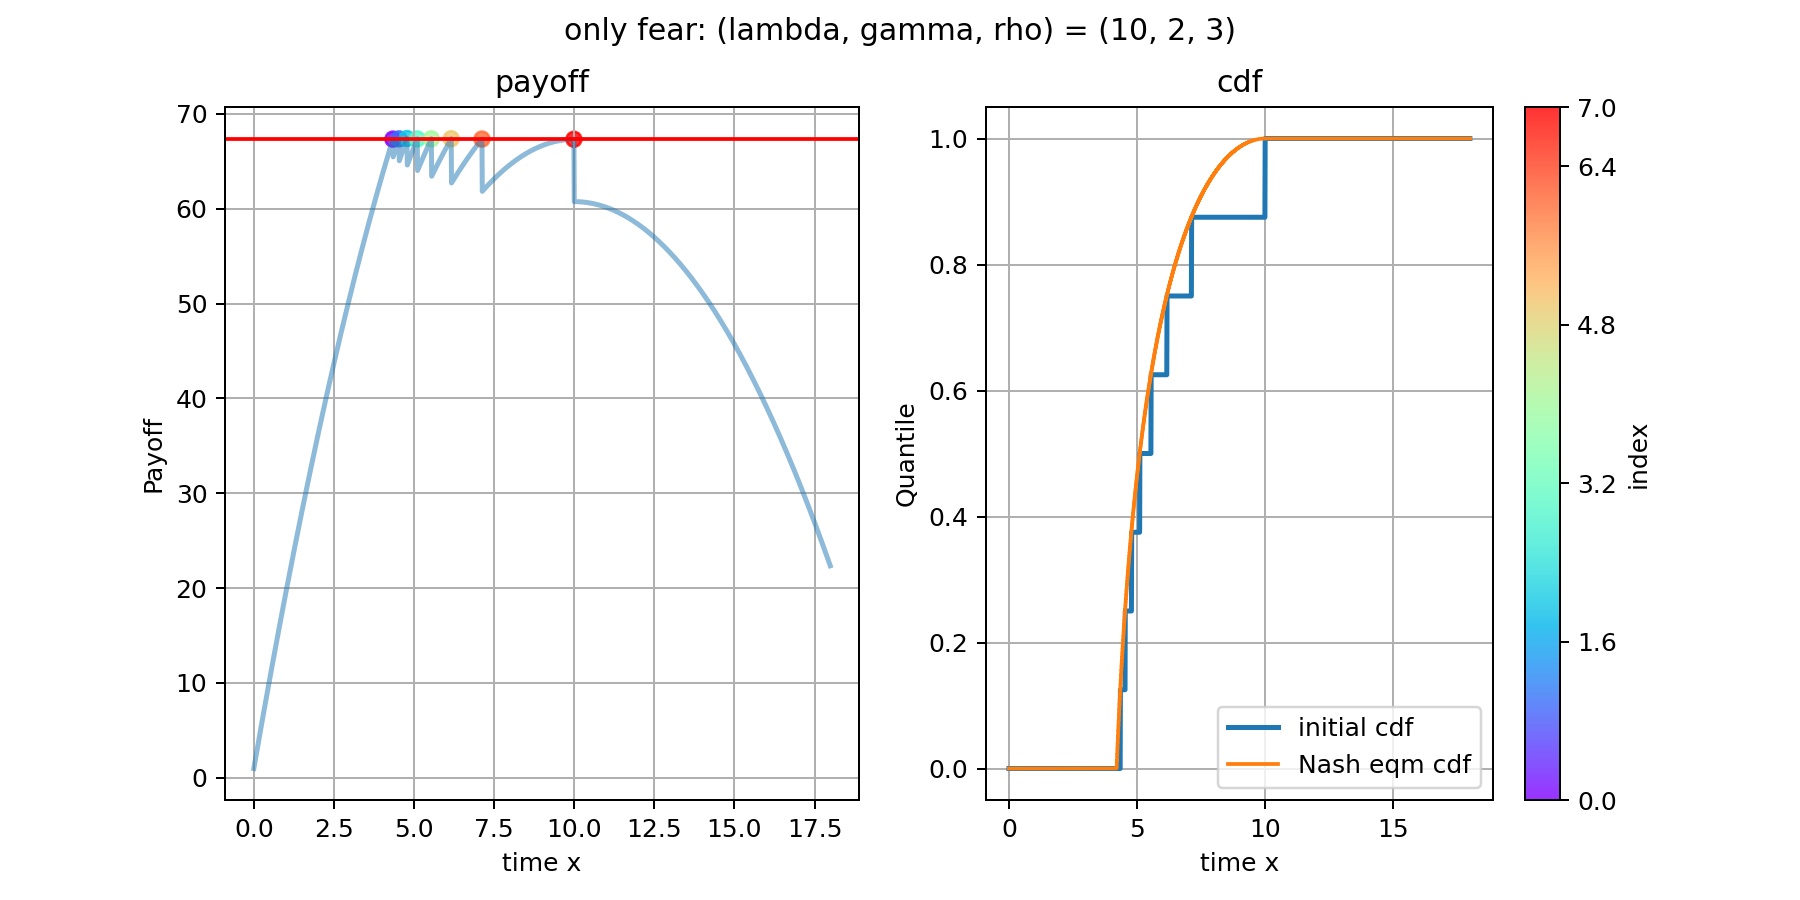

The "1" meaning the first 20% bots with the smaller index,...
For example, if we have 20 bots, "1" means the players with index from 0 to 4;"2" means the players with index from 5 to 9


/var/folders/15/djmbdtz95_34fcrr8nrcvk_40000gn/T/ipykernel_14010/1138589998.py:281: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(graph, ticks=[tick1, tick2, tick3,tick4,tick5,tick6])


In [19]:
####################################################################################
########## run this cell to run simulation after you change parameters ############
############################### 'simulation' cell #################################
####################################################################################
from datetime import datetime
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

start=datetime.now()

history = {}
round_idx = 0

# Set up simulation configuration
#####################################
### you can change parameters here ###
#####################################
sim_config = sim_config_init(
    game_type='fear',
    lgr=(10,2,3),
    sampling=None, 
    purification_v1=None,
    purification_v2=None, 
    purification_v3=None,
    trembling=0.4, 
    bandwidth=None,
    num_bots=8,
    move_percent=0.2,
    threshold_of_leaving=None, #use when leaving function is distance and move percent is useless
    game_length=200,
    xrange=(4,20),
    clump=None,
    beta=None,
    exp=False,
    leaving_function='endogenous', #could be distance, endogenous, or replicator
    leaving_beta=0.5, #use when leaving function is not distance
    endogenous_type='logit',#use when leaving function is not distance logit or linear
    freeze_period =2,
    outlier_index_set=[0,1],
    
)


#only use for other game
other_config = sim_config_init(
    game_type='greed',
    lgr=(10,2,0.5),
    sampling=None, 
    num_bots=3,
)

# Simulate players' initial strategies and payoffs
strategies, sample_sets, initial_strategies = initialize_player_strategies(sim_config)
if sim_config['game_type'] == 'other':
    initial_strategies = other_game_initial_strategies(other_config)
x, y, strategies_y, quantile, bubble = calculate_initial_payoff(sim_config, strategies, sample_sets)
#add initial remaining freeze period for all players
players_remaining_freeze_period = [0]*sim_config['num_bots']
# Log data for the initial round
# history = data_logging(['strategies', 'x', 'y', 'strat_x', 'strat_y'], round_idx, history) # To Do
history['strategies', round_idx] = strategies.copy()
history['x', round_idx] = x
history['y', round_idx] = y
history['strategies_y', round_idx] = strategies_y
history['quantile', round_idx] = quantile
history['selected_player_index', round_idx] = None
history['distances_from_best_payoff', round_idx] = None
history['bubble', round_idx] = bubble
history['total_bubble'] = []
history['total_bubble'].append(bubble)
history['avg_bubble', round_idx] = bubble
history['players_remaining_freeze_period', round_idx] = players_remaining_freeze_period

# Iterate simulation to update players' strategies and payoff
max_game_length = sim_config['game_length']

if sim_config['game_type'] == 'other':
    game_type_specification = sim_config['game_type']
elif (sim_config['gamma'] <= sim_config['rho'] + 2/3) or (sim_config['gamma'] >= sim_config['rho'] + 4/3):
    game_type_specification = 'only ' + sim_config['game_type']
else:
    game_type_specification = sim_config['game_type'] + ' equilibrium'    
print('This is {} game'.format(game_type_specification))
print('----------------Simulation Start----------------')
print('Period 0 done')
while round_idx < max_game_length:
    round_idx += 1
    static_remaining_freeze_period = players_remaining_freeze_period
#     print('feeze period',static_remaining_freeze_period)
    static_strategies, strategies, selected_player_index, distances_from_best_payoff = update_player_strategies(x, y, strategies,strategies_y,bubble, initial_strategies, sample_sets, sim_config, static_remaining_freeze_period)
#     print('selected_index',selected_player_index)
    players_remaining_freeze_period = update_remaining_freeze_period(static_remaining_freeze_period, selected_player_index, sim_config)
#     print('remaining feeze period',players_remaining_freeze_period)
    x, y, strategies_y, quantile, bubble = calculate_payoff(sim_config, static_strategies, strategies, sample_sets)

    # Log data for the round
    history['strategies', round_idx] = strategies.copy()
    history['x', round_idx] = x
    history['y', round_idx] = y
    history['strategies_y', round_idx] = strategies_y
    history['quantile', round_idx] = quantile
    history['selected_player_index', round_idx] = selected_player_index
    history['distances_from_best_payoff', round_idx] = distances_from_best_payoff
    history['bubble', round_idx] = bubble
    history['total_bubble'].append(bubble)
    bubble_array = np.array(history['total_bubble'])
    history['avg_bubble', round_idx] = np.average(bubble_array, axis=0)
    history['players_remaining_freeze_period', round_idx] = players_remaining_freeze_period
    
    if round_idx%20 == 0:
        print('Period {} done'.format(round_idx))
    
print('----------------Simulation Finished----------------')
print('The initial strategies {}'.format(history['strategies', 0]))
print('The second strategies {}'.format(history['strategies', 1]))
print('The third strategies {}'.format(history['strategies', 2]))
print('The initial distances from the best purified/unpurified payoffs {}'.format(history['distances_from_best_payoff', 1]))
print('The initial distances from the best purified/unpurified payoffs {}'.format(history['distances_from_best_payoff', 2]))
print('The initial distances from the best purified/unpurified payoffs {}'.format(history['distances_from_best_payoff', 3]))

# # print('The initial unpurified avg payoffs are {}'.format(history['avg_bubble', 0]))
# # print('The initial purified payoffs are {}'.format(history['strategies_y', 0]))

# print('The second period strategies are {}'.format(history['strategies', 30]))
print('The initial period unpurified payoffs are {}'.format(history['bubble', 0]))
# # print('The second purified avg payoffs are {}'.format(history['avg_bubble', 1]))
# # print('The second period purified payoffs are {}'.format(history['strategies_y', 1]))

# print('The third period unpurified payoffs are {}'.format(history['bubble', 40]))
# # print('The third purified avg payoffs are {}'.format(history['avg_bubble', 2]))

print('simulation spent time: {}'.format(datetime.now()-start))



#assign colors to 20%, 40%, 60%, 80%, 100% players
color_list = ['r','g','black','y','blue']
first_20_percent = round(sim_config['num_bots']*0.2)
first_40_percent = round(sim_config['num_bots']*0.4)
first_60_percent = round(sim_config['num_bots']*0.6)
first_80_percent = round(sim_config['num_bots']*0.8)
first_100_percent = round(sim_config['num_bots']*1)

#theoritical cdf if starting with Nash
if sim_config['game_type'] != 'other':
    game = sim_config['game_type']
    lam = sim_config['lambda']
    gam = sim_config['gamma']
    rho = sim_config['rho']
    cdfmin = sim_config['cdfmin']
    cdfmax = sim_config['cdfmax']
    xmin = sim_config['xmin']
    xmax = sim_config['xmax']
    num_bots =10000
    strategies = []

    if game == "fear":
        cdfx = np.round(np.arange(cdfmin, cdfmax, 0.01), 2)
        cdfy = gam - rho + np.sqrt((gam + rho) ** 2 - 4 * ((1 + rho) * (gam - 1) * (1 + lam ** 2))/(1 + 2 * lam * cdfx - cdfx ** 2))
        y_ind = 0
        cdfy = cdfy/2
        for i in range(num_bots):
            if (i+1)/num_bots <= cdfy[y_ind]:
                strategies.append(cdfx[y_ind])
            else:
                while y_ind < len(cdfy) - 1 and (i+1)/num_bots > cdfy[y_ind]:
                    y_ind = y_ind + 1
                if y_ind >= len(cdfy):
                    strategies.append(cdfx[len(cdfy)])
                else:
                    strategies.append(cdfx[y_ind])

    elif game == "greed":
        cdfx = np.round(np.arange(cdfmin, cdfmax, 0.01), 2)
        cdfy = gam - rho - np.sqrt((gam + rho) ** 2 - 4 * gam * rho * (1 + lam ** 2)/(1 + 2 * lam * cdfx - cdfx ** 2))
        y_ind = len(cdfy) - 1
        cdfy = cdfy/2
        i = num_bots
        while i > 0:
            if (i-1)/num_bots >= cdfy[y_ind]:
                strategies.append(cdfx[y_ind])
            else:
                while y_ind > 0 and (i-1)/num_bots < cdfy[y_ind]:
                    y_ind = y_ind - 1
                if y_ind == 0:
                    strategies.append(cdfx[0])
                else:
                    strategies.append(cdfx[y_ind])
            i = i - 1

else:
    game = other_config['game_type']
    lam = other_config['lambda']
    gam = other_config['gamma']
    rho = other_config['rho']
    cdfmin = other_config['cdfmin']
    cdfmax = other_config['cdfmax']
    xmin = other_config['xmin']
    xmax = other_config['xmax']
    num_bots =10000
    strategies = []
    
    if game == "fear":
        cdfx = np.round(np.arange(cdfmin, cdfmax, 0.01), 2)
        cdfy = gam - rho + np.sqrt((gam + rho) ** 2 - 4 * ((1 + rho) * (gam - 1) * (1 + lam ** 2))/(1 + 2 * lam * cdfx - cdfx ** 2))
        y_ind = 0
        cdfy = cdfy/2
        for i in range(num_bots):
            if (i+1)/num_bots <= cdfy[y_ind]:
                strategies.append(cdfx[y_ind])
            else:
                while y_ind < len(cdfy) - 1 and (i+1)/num_bots > cdfy[y_ind]:
                    y_ind = y_ind + 1
                if y_ind >= len(cdfy):
                    strategies.append(cdfx[len(cdfy)])
                else:
                    strategies.append(cdfx[y_ind])

    elif game == "greed":
        cdfx = np.round(np.arange(cdfmin, cdfmax, 0.01), 2)
        cdfy = gam - rho - np.sqrt((gam + rho) ** 2 - 4 * gam * rho * (1 + lam ** 2)/(1 + 2 * lam * cdfx - cdfx ** 2))
        y_ind = len(cdfy) - 1
        cdfy = cdfy/2
        i = num_bots
        while i > 0:
            if (i-1)/num_bots >= cdfy[y_ind]:
                strategies.append(cdfx[y_ind])
            else:
                while y_ind > 0 and (i-1)/num_bots < cdfy[y_ind]:
                    y_ind = y_ind - 1
                if y_ind == 0:
                    strategies.append(cdfx[0])
                else:
                    strategies.append(cdfx[y_ind])
            i = i - 1            
            
            
strategies_cdf = np.round(np.array(strategies), 2)
strategies_cdf.sort()
strategies_cdf = np.insert(strategies_cdf,0,xmin)
strategies_cdf = np.append(strategies_cdf,xmax)
pdf = np.array([1/num_bots]*num_bots)
cdf=np.cumsum(pdf)
cdf = np.insert(cdf,0,0)
cdf = np.append(cdf,1)

#calculate the average NE payoff
avg_NE_payoff = round(sum(history['bubble', 0])/sim_config['num_bots'],2)
# avg_NE_payoff = 101.0

fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
plt.ion()



ax1.plot(history['x', 0], history['y', 0], alpha=0.5, linewidth = '2')
ax1.axhline(avg_NE_payoff, color='r', linestyle='-', label='NE payoff')
#     ax1.scatter(history['strategies', 0][:first_20_percent], history['strategies_y', 0][:first_20_percent], alpha = 0.5,label='0-20%', marker='$1$', color='black')
#     ax1.scatter(history['strategies', 0][first_20_percent:first_40_percent], history['strategies_y', 0][first_20_percent:first_40_percent], label='20-40%', marker='$2$', color='r')
#     ax1.scatter(history['strategies', 0][first_40_percent:first_60_percent], history['strategies_y', 0][first_40_percent:first_60_percent], label='40-60%', marker='$3$', color='g')
#     ax1.scatter(history['strategies', 0][first_60_percent:first_80_percent], history['strategies_y', 0][first_60_percent:first_80_percent], label='60-80%', marker='$4$', color='b')
#     ax1.scatter(history['strategies', 0][first_80_percent:first_100_percent], history['strategies_y', 0][first_80_percent:first_100_percent], label='80-100%', marker='$5$', color='y')
graph = ax1.scatter(history['strategies', 0], history['bubble', 0],c = list(range(0,sim_config['num_bots'])), cmap='rainbow', alpha=0.8)

ax1.set_xlabel('time x')
ax1.set_ylabel('Payoff')
ax1.set_title('payoff')
ax1.grid()
#     ax1.legend()
# fig.colorbar(graph, ax=ax1)
tick1 = 0
tick2 = sim_config['num_bots']/5
tick3 = 2*sim_config['num_bots']/5
tick4 = 3*sim_config['num_bots']/5
tick5 = 4*sim_config['num_bots']/5
tick6 = sim_config['num_bots']-1
cbar = fig.colorbar(graph, ticks=[tick1, tick2, tick3,tick4,tick5,tick6])
cbar.set_label('index')


ax2.plot(history['x', 0], history['quantile', 0], linewidth = '2', label='initial cdf')
ax2.plot(strategies_cdf, cdf, label='Nash eqm cdf')
ax2.set_xlabel('time x')
ax2.set_ylabel('Quantile')
ax2.set_title('cdf')
ax2.grid()
ax2.legend()

# fig.suptitle(game_type_specification + ' game: Period 0')
fig.suptitle(game_type_specification + ': (lambda, gamma, rho) = '+ '(' + str(sim_config['lambda']) + ', ' + str(sim_config['gamma']) + ', ' + str(sim_config['rho']) + ')')
fig.canvas.draw()

output_name = sim_config['game_type'] + '_beta'+ str(sim_config['beta'])+ '_exp'+ str(sim_config['exp'])+ '_'+ sim_config['leaving_function']+ sim_config['endogenous_type']+ str(sim_config['leaving_beta']) + '_clump' + str(sim_config['clump']) + '_lgr_' + str(sim_config['lambda']) +'_'+ str(sim_config['gamma'])+'_'+ str(sim_config['rho'])+'_' + 'bots' + str(sim_config['num_bots'])+ '_threshold_leaving' + str(sim_config['threshold_of_leaving'])+'_sampling' + str(sim_config['sampling']) +'_move' + str(sim_config['move_percent'])+'_trem'+str(sim_config['trembling']) + '_length' + str(sim_config['game_length'])+'_puri'+str(sim_config['purification_v1'])+str(sim_config['purification_v2'])+str(sim_config['purification_v3'])
fig.savefig(output_name + '.png', dpi=fig.dpi, bbox_inches='tight')

print('The "1" meaning the first 20% bots with the smaller index,...')
print('For example, if we have 20 bots, "1" means the players with index from 0 to 4;"2" means the players with index from 5 to 9' )

#save move info
move = [0]
for period in range(1,round_idx+1):
    move.append(len(history['selected_player_index', period])/len(history['strategies', period]))
#outlier color
if len(sim_config['outlier_index_set']) <= 2:
    outlier_color_set = ['purple', 'r']
elif len(sim_config['outlier_index_set']) <= 3:
    outlier_color_set = ['purple','b', 'r']
elif len(sim_config['outlier_index_set']) <= 4:
    outlier_color_set = ['purple','b','orange', 'r']
elif len(sim_config['outlier_index_set']) <= 5:
    outlier_color_set = ['purple','b','orange','cyan', 'r'] 
elif len(sim_config['outlier_index_set']) <= 6:
    outlier_color_set = ['purple','b','orange','cyan', 'olive','r']    

<IPython.core.display.Javascript object>


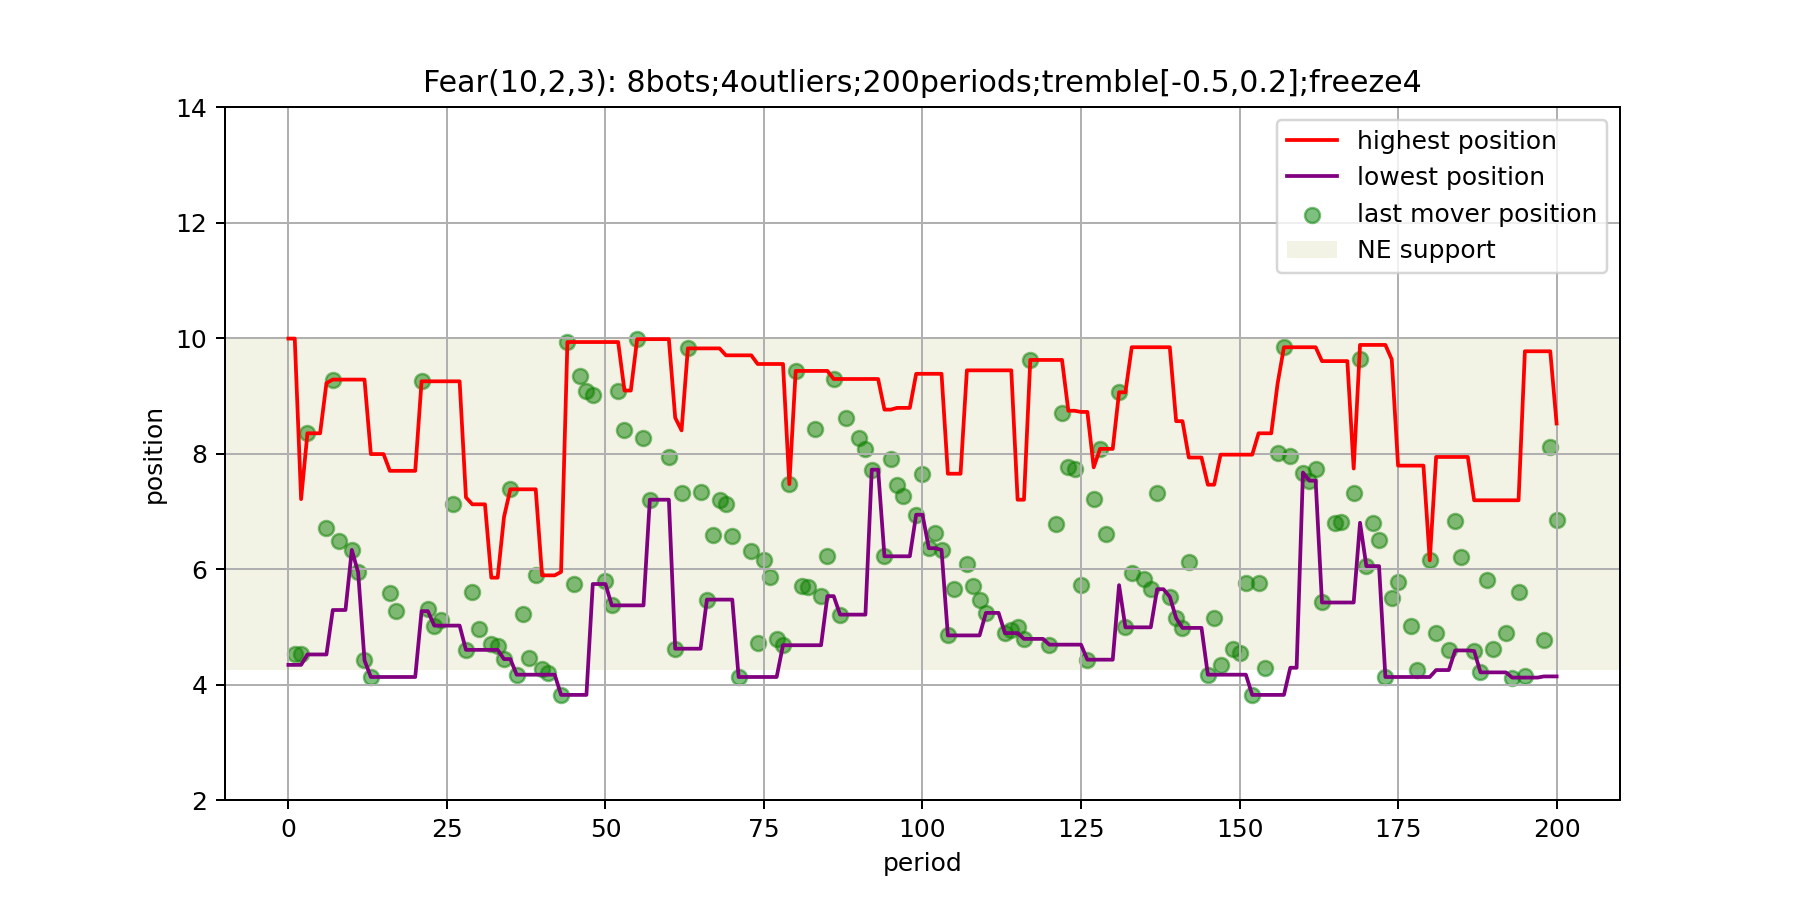

In [159]:
game_type = sim_config['game_type']
NE_support = [[10,14.05], [4.25,10]]
last_mover = []
last_mover_time = []

highest_position = []
lowest_position = []
position_round = []
high_pos = max(history['strategies', 0])
low_pos = min(history['strategies', 0])
highest_position.append(high_pos)
lowest_position.append(low_pos)
position_round.append(0)
for rd in range(1, round_idx+1):
    mover = []
    for player_idx in range(sim_config['num_bots']):
        if history['strategies', rd-1][player_idx] != history['strategies', rd][player_idx]:
            mover.append(history['strategies', rd][player_idx])
    if len(mover) > 0:
        if game_type == 'fear':
            last_mover.append(min(mover))        
        else:
            last_mover.append(max(mover)) 
        last_mover_time.append(rd)
    highest_position.append(max(history['strategies', rd]))
    lowest_position.append(min(history['strategies', rd]))
    position_round.append(rd)

%matplotlib notebook
plt.figure(figsize=(10,5))
plt.plot(position_round, highest_position, color = 'r', label= 'highest position')
plt.plot(position_round, lowest_position, color = 'purple', label= 'lowest position')
plt.scatter(last_mover_time, last_mover, color = 'g', alpha=0.5, label= 'last mover position')
if game_type == 'greed':
    plt.axhspan(NE_support[0][0], NE_support[0][1], facecolor ='tan', alpha = 0.1, label='NE support')
else:
    plt.axhspan(NE_support[1][0], NE_support[1][1], facecolor ='olive', alpha = 0.1, label='NE support')
plt.ylim([2,14])
# plt.ylim([8,18])
plt.title('Fear(10,2,3): 8bots;4outliers;200periods;tremble[-0.5,0.2];freeze4')
plt.xlabel('period')
plt.ylabel('position')
plt.grid()
plt.legend()
plt.show()
plt.savefig('new_sim_fear_10_2_3_lowest_highest_last_position_over_time_8bots_4outliers.png', bbox_inches='tight')


<IPython.core.display.Javascript object>


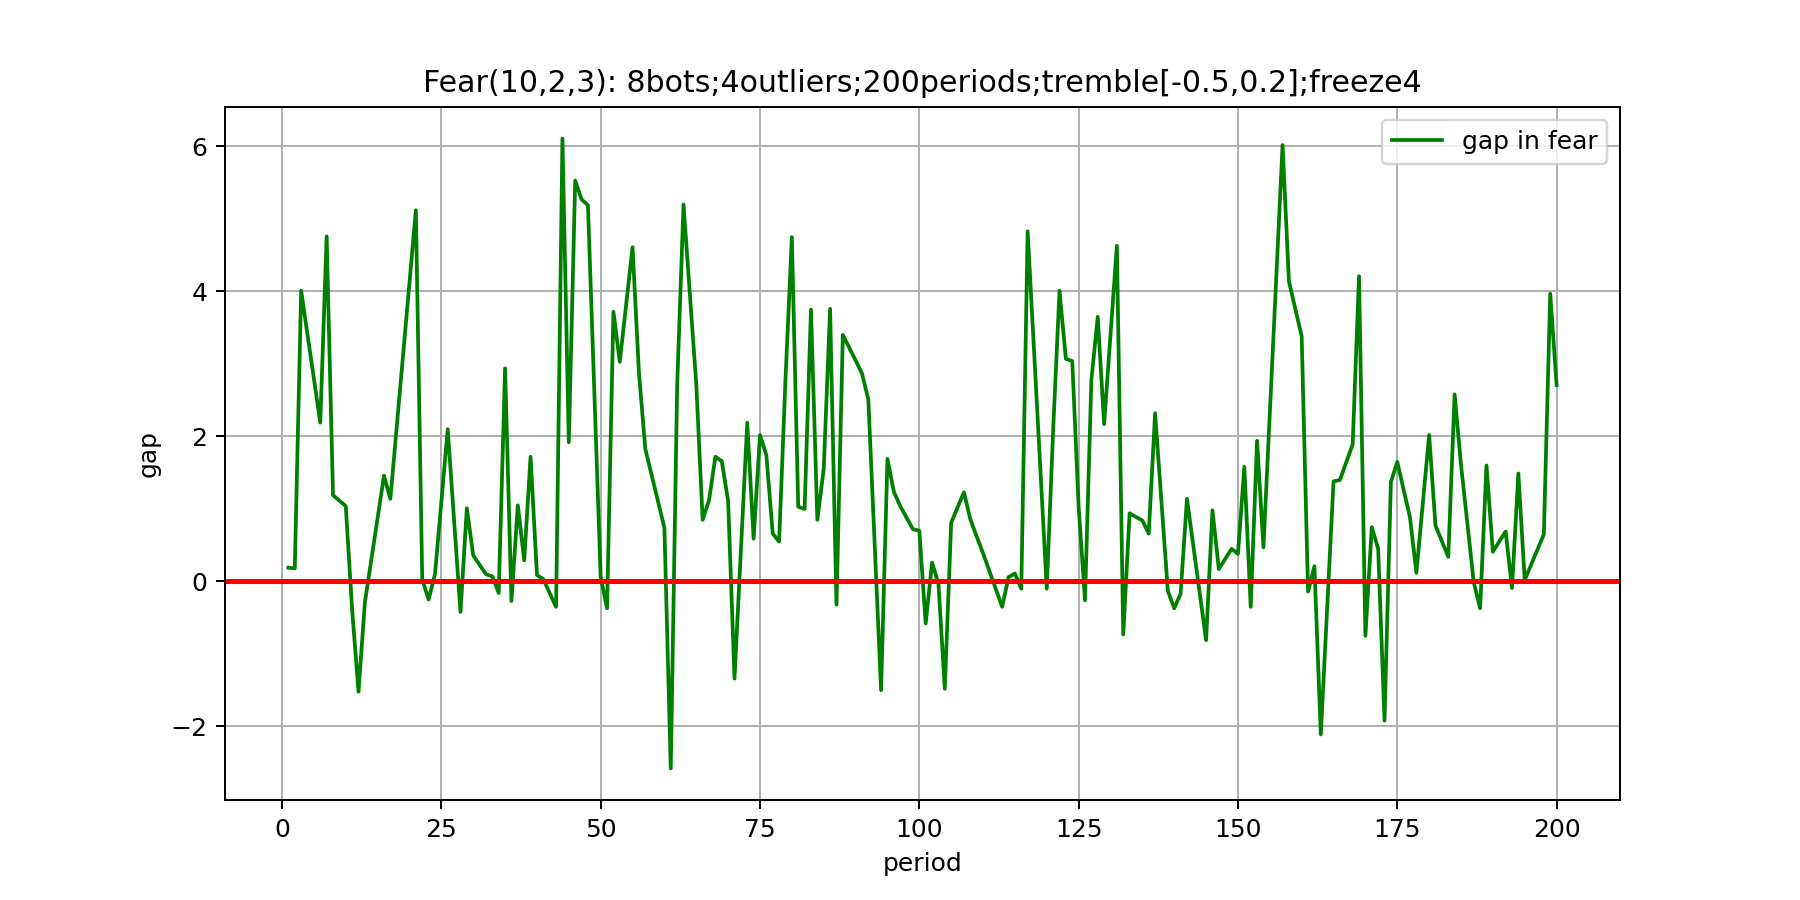

In [160]:
game_type = sim_config['game_type']
NE_support = [[10,14.05], [4.25,10]]
last_mover = []
last_mover_time = []
highest_position = []
lowest_position = []
for rd in range(1, round_idx+1):
    mover = []
    for player_idx in range(sim_config['num_bots']):
        if history['strategies', rd-1][player_idx] != history['strategies', rd][player_idx]:
            mover.append(history['strategies', rd][player_idx])
    if len(mover) > 0:
        if game_type == 'fear':
            last_mover.append(min(mover))        
        else:
            last_mover.append(max(mover)) 
        last_mover_time.append(rd)
            
for last_mover_rd in last_mover_time:
    highest_position.append(max(history['strategies', last_mover_rd-1]))
    lowest_position.append(min(history['strategies', last_mover_rd-1]))
array_highest_position_previous = np.array(highest_position)
array_lowest_position_previous = np.array(lowest_position)
array_last_mover = np.array(last_mover)
if game_type == 'greed':
    gap = array_last_mover - array_highest_position_previous
else:
    gap = array_last_mover - array_lowest_position_previous

%matplotlib notebook
plt.figure(figsize=(10,5))
if game_type == 'greed':
    plt.plot(last_mover_time, gap, color = 'b', label= 'gap in greed')
else:
    plt.plot(last_mover_time, gap, color = 'g', label= 'gap in fear')
plt.axhline(y=0, color='r', linestyle='-',linewidth=2)
# plt.ylim([8,16])
plt.title('Fear(10,2,3): 8bots;4outliers;200periods;tremble[-0.5,0.2];freeze4')
plt.xlabel('period')
plt.ylabel('gap')
plt.grid()
plt.legend()
plt.show()
plt.savefig('new_sim_fear_10_2_3_gap_over_time_8bots_4outliers.png', bbox_inches='tight')

<IPython.core.display.Javascript object>


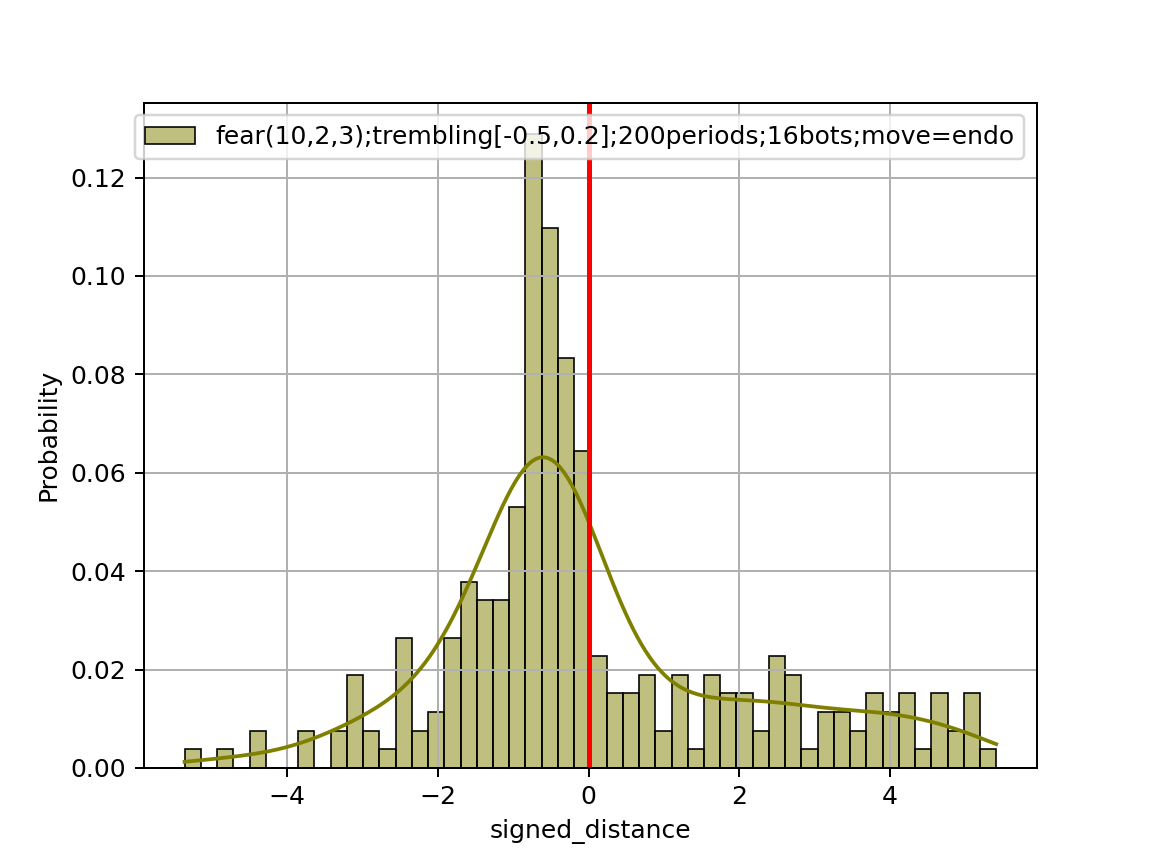

In [161]:
#create df
import seaborn as sns
d = {'strategy': pd.Series(history['strategies', 0]), 
     'period': pd.Series([0]*len(history['strategies', 0])),
     'id_in_group': pd.Series(range(1,len(history['strategies', 0])+1))
    } 
  
# creates Dataframe. 
sim_df = pd.DataFrame(d) 
for rd in range(1,round_idx+1):
    c = {'strategy': pd.Series(history['strategies', rd]), 
     'period': pd.Series([rd]*len(history['strategies', rd])),
     'id_in_group': pd.Series(range(1,len(history['strategies', rd])+1))
    } 
    sim_df1=pd.DataFrame(c)
    sim_df = pd.concat([sim_df,sim_df1], ignore_index=True)
sim_df = sim_df.sort_values(by=['id_in_group', 'period'])
sim_df['previous_strategies'] = sim_df.groupby(['id_in_group'])['strategy'].shift()
sim_df['signed_distance'] = sim_df['strategy'] - sim_df['previous_strategies']
sim_df = sim_df.dropna()
sim_df = sim_df[sim_df['signed_distance'] != 0]
%matplotlib notebook
sns.histplot(data=sim_df['signed_distance'],stat='probability', kde=True, bins=50, label='fear(10,2,3);trembling[-0.5,0.2];200periods;16bots;move=endo', color='olive')
plt.axvline(x=0, color='r', linestyle='-',linewidth=2)
plt.grid()
plt.legend()
plt.show()
output_name = sim_config['game_type'] + '_beta'+ str(sim_config['beta'])+ '_exp'+ str(sim_config['exp'])+ '_'+ sim_config['leaving_function']+ sim_config['endogenous_type']+ str(sim_config['leaving_beta']) + '_clump' + str(sim_config['clump']) + '_lgr_' + str(sim_config['lambda']) +'_'+ str(sim_config['gamma'])+'_'+ str(sim_config['rho'])+'_' + 'bots' + str(sim_config['num_bots'])+ '_threshold_leaving' + str(sim_config['threshold_of_leaving'])+'_sampling' + str(sim_config['sampling']) +'_move' + str(sim_config['move_percent'])+'_trem'+str(sim_config['trembling']) + '_length' + str(sim_config['game_length'])+'_puri'+str(sim_config['purification_v1'])+str(sim_config['purification_v2'])+str(sim_config['purification_v3'])
plt.savefig(output_name + '_signed_dist_8bots_4outliers.png', dpi=fig.dpi, bbox_inches='tight')

<IPython.core.display.Javascript object>


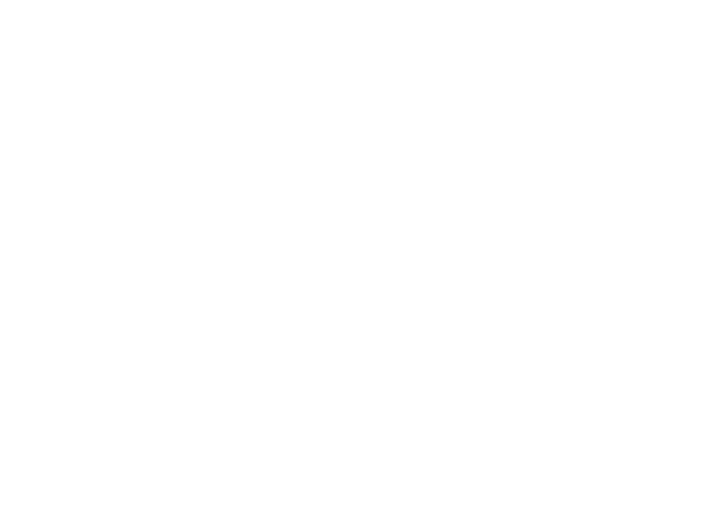

In [34]:
#create cdf
import seaborn as sns
d = {'strategy': pd.Series(history['strategies', 0]), 
     'period': pd.Series([0]*len(history['strategies', 0])),
     'id_in_group': pd.Series(range(1,len(history['strategies', 0])+1))
    } 
  
# creates Dataframe. 
sim_df = pd.DataFrame(d) 
for rd in range(1,round_idx+1):
    c = {'strategy': pd.Series(history['strategies', rd]), 
     'period': pd.Series([rd]*len(history['strategies', rd])),
     'id_in_group': pd.Series(range(1,len(history['strategies', rd])+1))
    } 
    sim_df1=pd.DataFrame(c)
    sim_df = pd.concat([sim_df,sim_df1], ignore_index=True)
sim_df = sim_df.sort_values(by=['id_in_group', 'period'])
sim_df['previous_strategies'] = sim_df.groupby(['id_in_group'])['strategy'].shift()
sim_df['signed_distance'] = sim_df['strategy'] - sim_df['previous_strategies']
sim_df = sim_df.dropna()
sim_df = sim_df[sim_df['signed_distance'] != 0]
%matplotlib notebook
sns.ecdfplot(sim_df['signed_distance'], stat='proportion', label='fear/greed eqm(10,3,2);trembling0.2;200periods;13bots;move=25%', color='olive')
plt.grid()
plt.legend(loc='center right', fontsize=8)
plt.show()
output_name = sim_config['game_type'] + '_beta'+ str(sim_config['beta'])+ '_exp'+ str(sim_config['exp'])+ '_'+ sim_config['leaving_function']+ sim_config['endogenous_type']+ str(sim_config['leaving_beta']) + '_clump' + str(sim_config['clump']) + '_lgr_' + str(sim_config['lambda']) +'_'+ str(sim_config['gamma'])+'_'+ str(sim_config['rho'])+'_' + 'bots' + str(sim_config['num_bots'])+ '_threshold_leaving' + str(sim_config['threshold_of_leaving'])+'_sampling' + str(sim_config['sampling']) +'_move' + str(sim_config['move_percent'])+'_trem'+str(sim_config['trembling']) + '_length' + str(sim_config['game_length'])+'_puri'+str(sim_config['purification_v1'])+str(sim_config['purification_v2'])+str(sim_config['purification_v3'])
plt.savefig(output_name + '_signed_cdf.png', dpi=fig.dpi, bbox_inches='tight')

In [35]:
sim4 = sim_df['signed_distance']

<IPython.core.display.Javascript object>


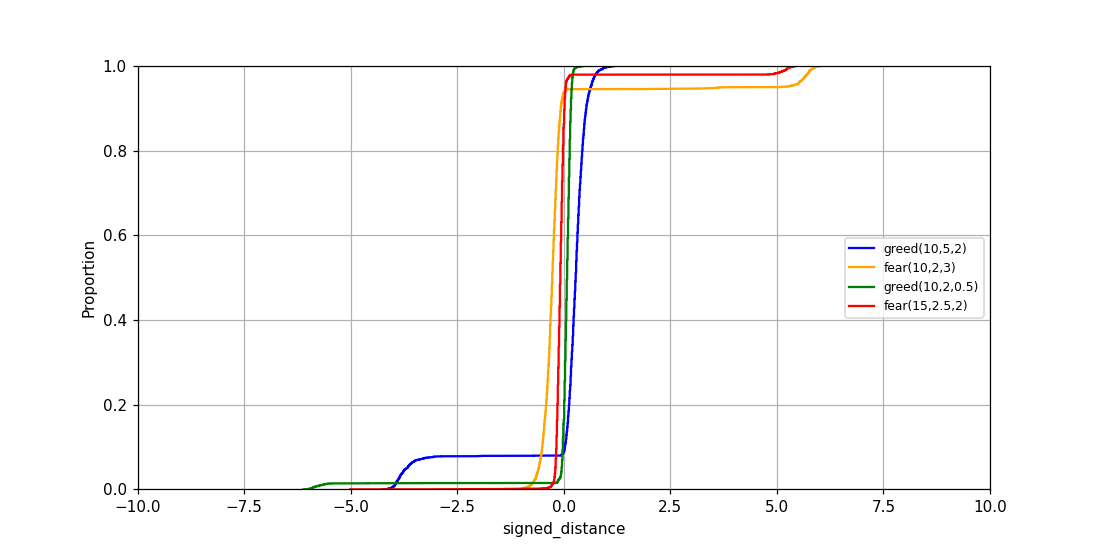

In [37]:
%matplotlib notebook
plt.figure(figsize=(10,5))
sns.ecdfplot(sim2, stat='proportion', label='greed(10,5,2)', color='b')
sns.ecdfplot(sim1, stat='proportion', label='fear(10,2,3)', color='orange')
sns.ecdfplot(sim4, stat='proportion', label='greed(10,2,0.5)', color='g')
sns.ecdfplot(sim3, stat='proportion', label='fear(15,2.5,2)', color='r')
plt.grid()
plt.xlim([-10,10])
plt.legend(loc='center right', fontsize=8)
plt.show()
plt.savefig('sim_signed_cdf.png', dpi=fig.dpi, bbox_inches='tight')

<IPython.core.display.Javascript object>


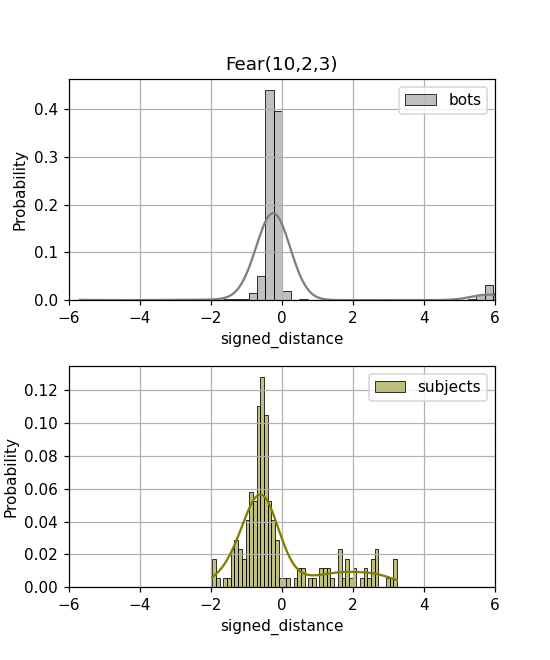

In [57]:
#separate sign position change distribution
selected_round = 8
df = df_copy[df_copy['session'] == 'fiy4zmu5']
df = df[(df['id_in_group']!= 2)&(df['id_in_group']!= 13)&(df['id_in_group']!= 7)&(df['id_in_group']!= 10)]
practice_num = 2
df = df.loc[df['seconds']>25]
block_label = ['Block 1: Greed(10,5,2)', 'Block 2: Fear(10,2,3)', 'Block 3: Greed(10,2,0.5)','Block 4: Greed/Fear Eqm(10,3,2)']
df = df[df['round_number']>practice_num] #drop practice round 1 and 2
df['round_number'] = df['round_number'] - practice_num
df = df[df['round_number']== selected_round]
df = df.loc[(df['move'] == 1)]
# df = df.drop(df[(df['move'] == 1) & (df['if_freeze_now'] == 1)].index)
df = df.sort_values(by=['round_number','id_in_group', 'seconds'])
df['previous_strategies'] = df.groupby(['round_number','id_in_group'])['strategy'].shift()
df['signed_distance'] = df['strategy'] - df['previous_strategies']
col_lst = ['gray', 'orange', 'tan', 'olive', 'green', 'lightseagreen', 'cyan', 'blue', 'purple', 'red']
%matplotlib notebook
cols = 1
rows = 2
fig = plt.figure(figsize=(5*cols,3*rows)) #single 5*3
fig.subplots_adjust(hspace=0.3, wspace=0.2)
ax1 = fig.add_subplot(rows, cols, 1)
ax1.grid()
sns.histplot(data=sim_df['signed_distance'],stat='probability', kde=True, bins=50,label='bots', color='grey')
ax1.set_xlim([-6,6])
plt.legend()
plt.title('Fear(10,2,3)')
ax2 = fig.add_subplot(rows, cols, 2)
ax2.grid()
sns.histplot(data=df['signed_distance'],stat='probability', kde=True, bins=50,label='subjects', color='olive')    
ax2.set_xlim([-6,6])
# fig.legend(loc='upper right', fontsize=8)
# fig.suptitle('Distribution of position change in 4 blocks', y=0.92, fontsize=18)

# plt.xlabel('position change')
# # plt.xlim([-10,10])
# plt.grid()
plt.legend()

plt.show()
plt.savefig('workshop_fear10_2_3_signed_position_dist.png', bbox_inches='tight')

<IPython.core.display.Javascript object>


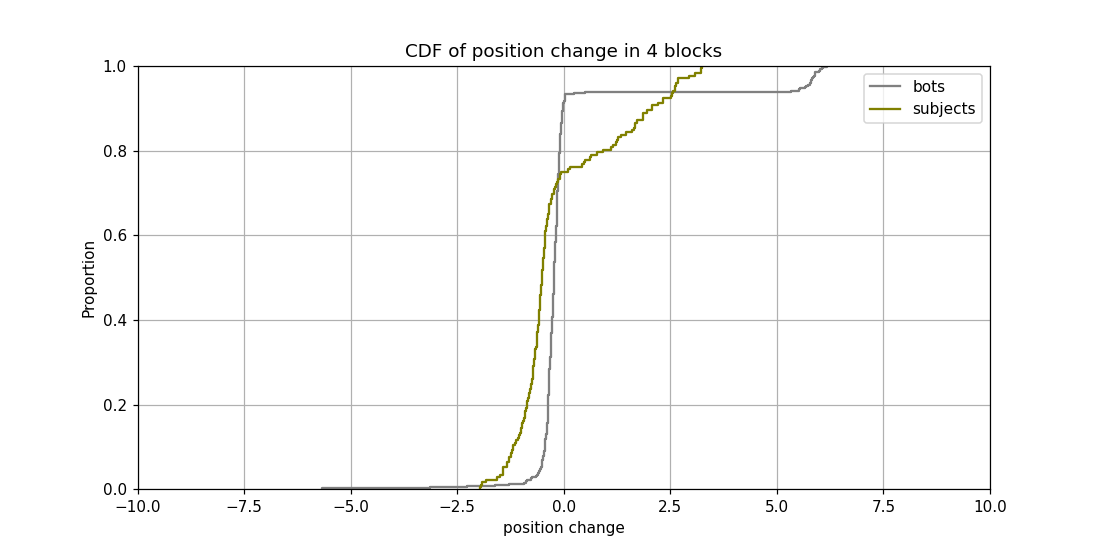

In [59]:
#sign position change distribution cdf
selected_round = 8
df = df_copy[df_copy['session'] == 'fiy4zmu5']
df = df[(df['id_in_group']!= 2)&(df['id_in_group']!= 13)&(df['id_in_group']!= 7)&(df['id_in_group']!= 10)]
practice_num = 2
df = df.loc[df['seconds']>25]
block_label = ['Block 1: Greed(10,5,2)', 'Block 2: Fear(10,2,3)', 'Block 3: Greed(10,2,0.5)','Block 4: Greed/Fear Eqm(10,3,2)']
df = df[df['round_number']>practice_num] #drop practice round 1 and 2
df['round_number'] = df['round_number'] - practice_num
df = df[df['round_number']== selected_round]
df = df.loc[(df['move'] == 1)]
# df = df.drop(df[(df['move'] == 1) & (df['if_freeze_now'] == 1)].index)
df = df.sort_values(by=['round_number','id_in_group', 'seconds'])
df['previous_strategies'] = df.groupby(['round_number','id_in_group'])['strategy'].shift()
df['signed_distance'] = df['strategy'] - df['previous_strategies']

stat = "proportion"  # or count

%matplotlib notebook
plt.figure(figsize=(10,5))
sns.ecdfplot(sim_df['signed_distance'], stat=stat, label='bots', color= 'grey')
sns.ecdfplot(df['signed_distance'], stat=stat, label='subjects', color= 'olive')


plt.xlabel('position change')
plt.xlim([-10,10])
plt.grid()
plt.legend()
plt.title('CDF of position change in 4 blocks')
plt.show()
plt.savefig('cdf_signed_position_change_clean_copy.png', bbox_inches='tight')

In [70]:
from scipy import stats
from scipy.stats import skew
x = df['signed_distance'].to_numpy()
x =x[~np.isnan(x)]
print(len(x))
skw = skew(x)
res = stats.skewtest(x)
print('skewness:',round(skw,2))
print('z score:',round(res.statistic,2))
print('p value:',round(res.pvalue,5))

578
skewness: -8.23
z score: -24.71
p value: 0.0


<IPython.core.display.Javascript object>


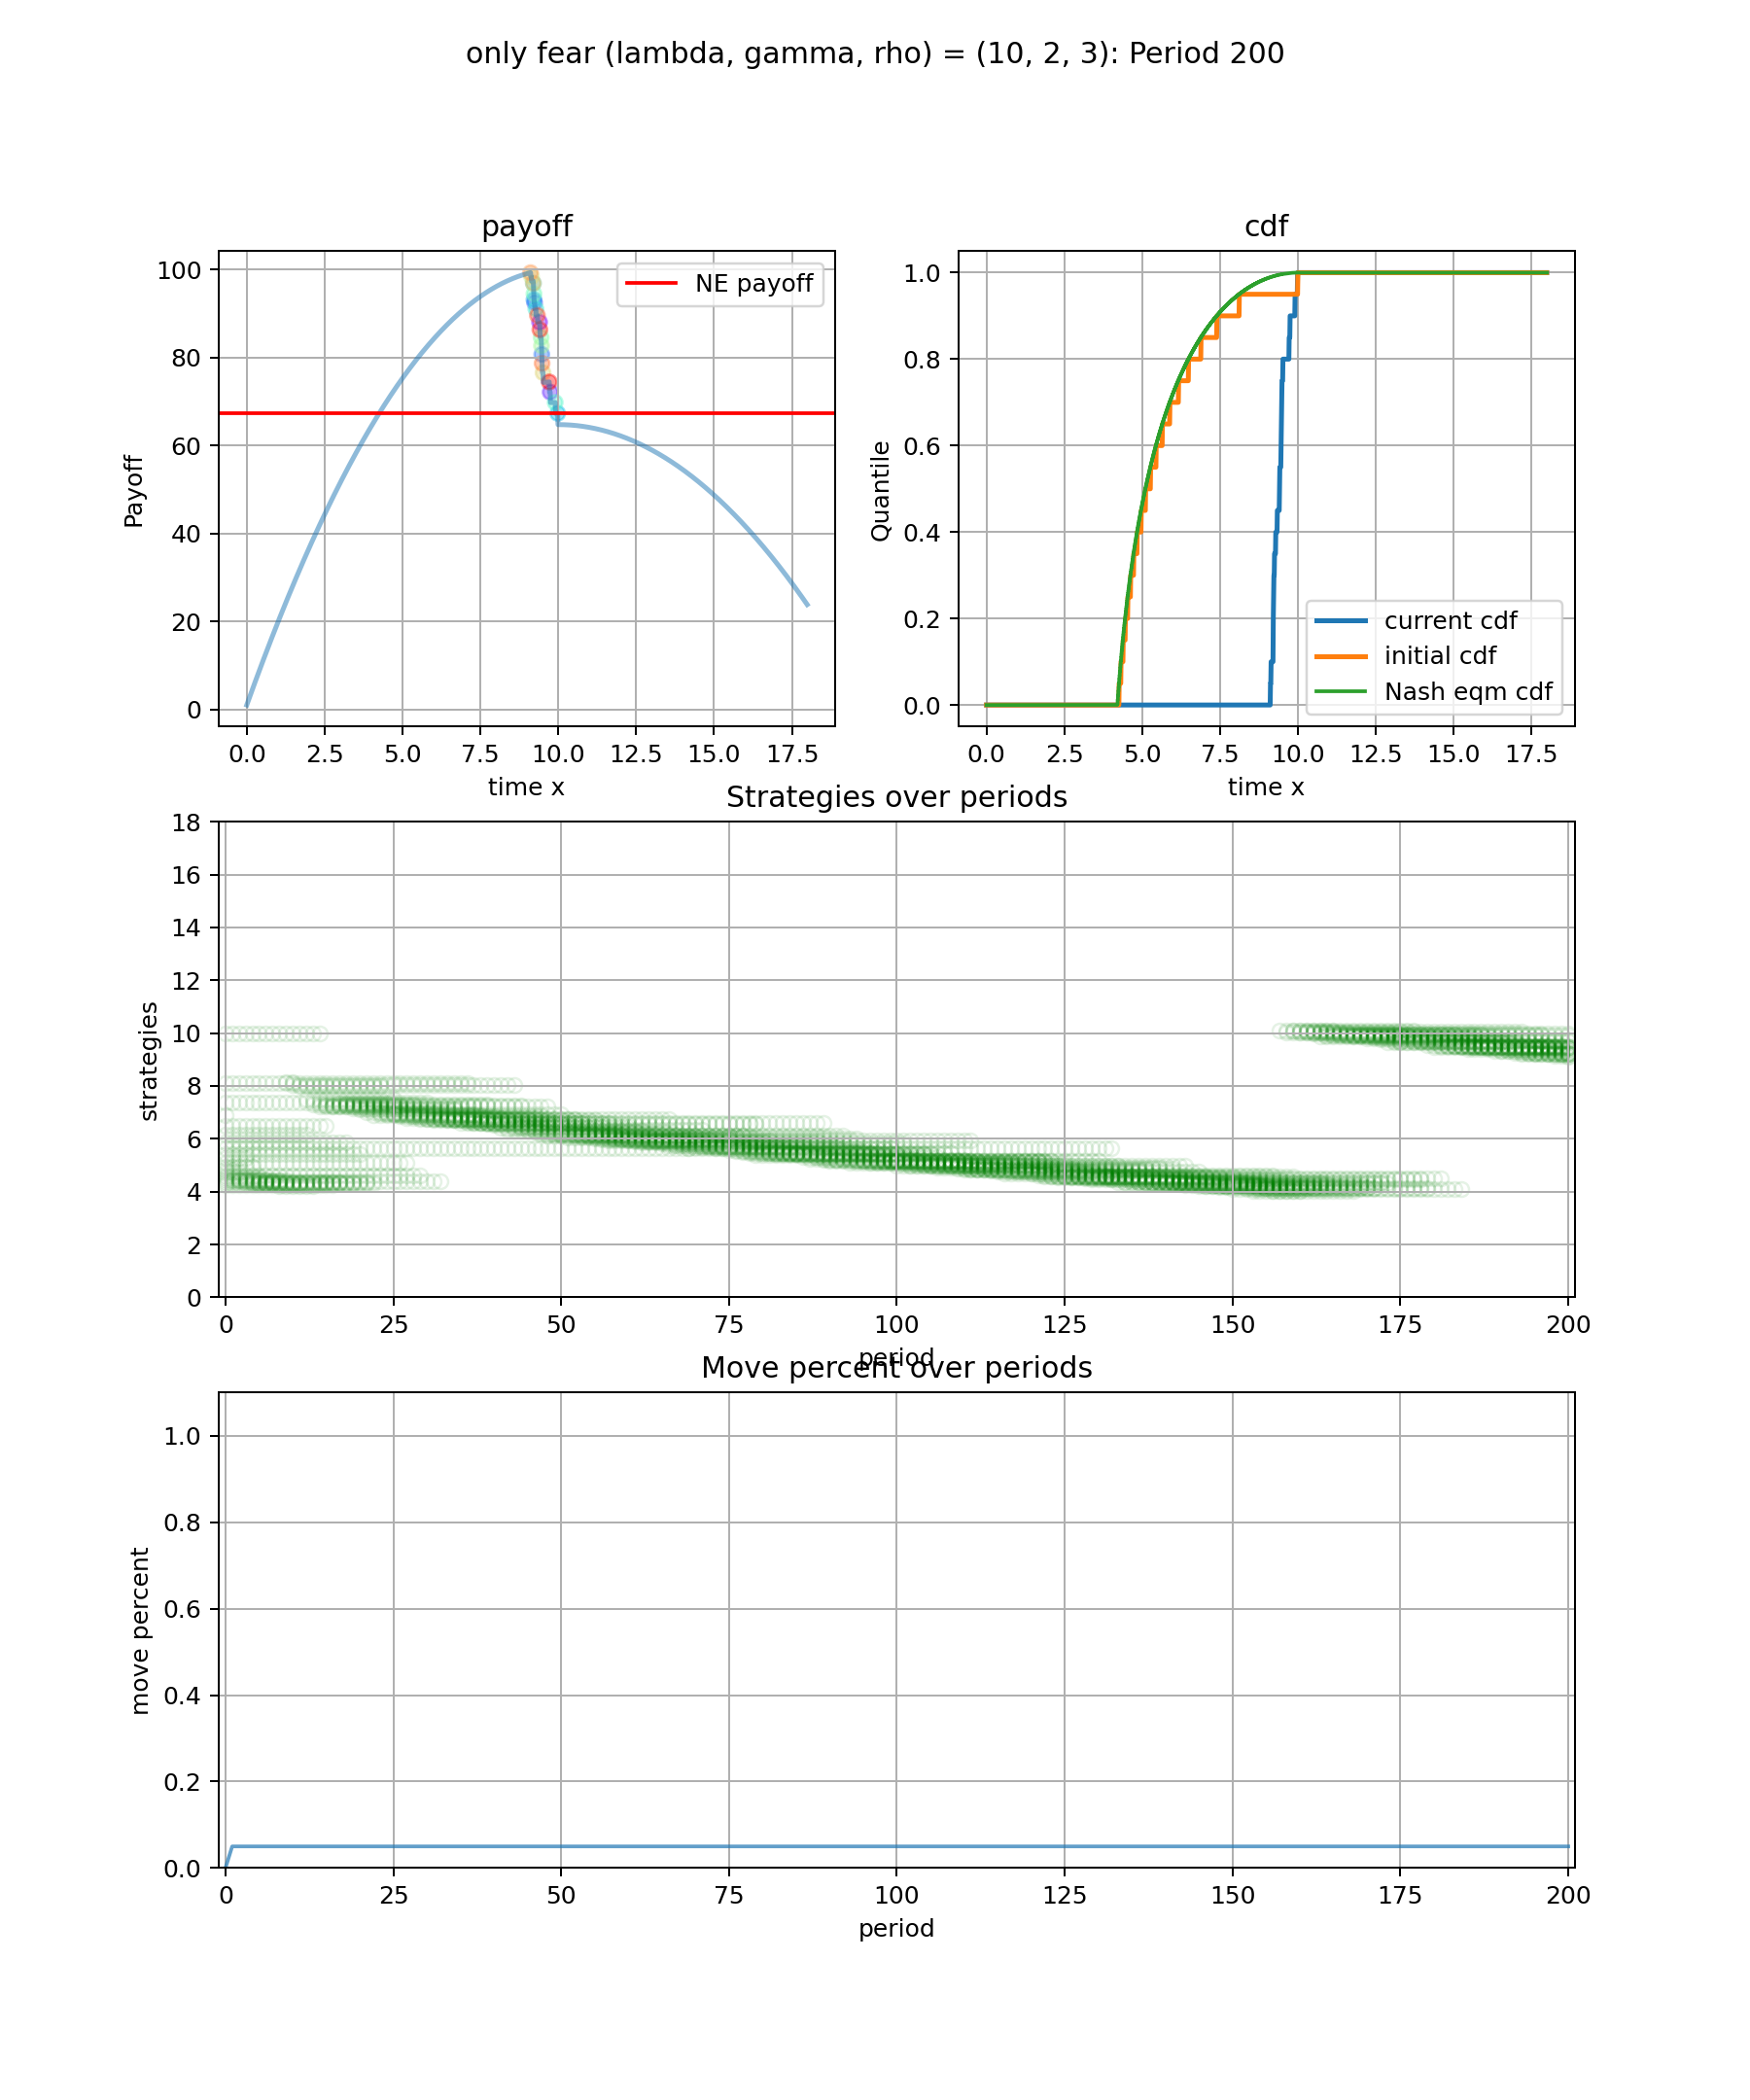

Done


In [92]:
####################################################################################
########## after finishing simulation, run this cell to make graphs ############
############################### 'graphing' cell #################################
####################################################################################

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

#calculate the average NE payoff
avg_NE_payoff = round(sum(history['bubble', 0])/sim_config['num_bots'],2)
# avg_NE_payoff = 101.0

move = [0]
for period in range(1,round_idx+1):
    move.append(len(history['selected_player_index', period])/len(history['strategies', period]))


player_index = list(range(sim_config['num_bots']))

fig = plt.figure(figsize=(10,12))
gs = fig.add_gridspec(3, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])
ax4 = fig.add_subplot(gs[2, :])
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(round_idx+1):
    ax1.clear()
    ax1.plot(history['x', i], history['y', i], alpha=0.5, linewidth = '2')
#     ax1.scatter(history['strategies', i][:first_20_percent], history['strategies_y', i][:first_20_percent],label='0-20%', marker='$1$', color='black')
#     ax1.scatter(history['strategies', i][first_20_percent:first_40_percent], history['strategies_y', i][first_20_percent:first_40_percent],label='20-40%', marker='$2$', color='r')
#     ax1.scatter(history['strategies', i][first_40_percent:first_60_percent], history['strategies_y', i][first_40_percent:first_60_percent],label='40-60%', marker='$3$', color='g')
#     ax1.scatter(history['strategies', i][first_60_percent:first_80_percent], history['strategies_y', i][first_60_percent:first_80_percent],label='60-80%', marker='$4$', color='b')
#     ax1.scatter(history['strategies', i][first_80_percent:first_100_percent], history['strategies_y', i][first_80_percent:first_100_percent],label='80-100%', marker='$5$', color='y')
    ax1.axhline(avg_NE_payoff, color='r', linestyle='-', label='NE payoff')
    graph = ax1.scatter(history['strategies', i], history['bubble', i],c = list(range(0,sim_config['num_bots'])), cmap='rainbow', alpha=0.4)
    
    ax1.set_xlabel('time x')
    ax1.set_ylabel('Payoff')
    ax1.set_title('payoff')
    ax1.grid()
    ax1.legend()

    if sim_config['game_type'] != 'other': 
        ax2.clear()
        ax2.plot(history['x', i], history['quantile', i], linewidth = '2', label='current cdf')
        ax2.plot(history['x', 0], history['quantile', 0], linewidth = '2', label='initial cdf')
        ax2.plot(strategies_cdf, cdf, label='Nash eqm cdf')
        ax2.set_xlabel('time x')
        ax2.set_ylabel('Quantile')
        ax2.set_title('cdf')
        ax2.grid()
        ax2.legend()
    else:
        ax2.clear()
        ax2.plot(history['x', i], history['quantile', i], linewidth = '2', label='current cdf')
#         ax2.plot(history['x', 0], history['quantile', 0], linewidth = '2', label='initial cdf')
        ax2.plot(strategies_cdf, cdf, label='Nash eqm cdf')
        ax2.set_xlabel('time x')
        ax2.set_ylabel('Quantile')
        ax2.set_title('cdf')
        ax2.grid()
        ax2.legend()
    
    plot_round = np.array([i]*len(history['strategies', 0]))
    ax3.plot(plot_round, history['strategies', i], 'go', fillstyle='none', alpha=0.1, zorder=1)
    for outlier in range(len(sim_config['outlier_index_set'])):
        ax3.plot(plot_round[sim_config['outlier_index_set'][outlier]], history['strategies', i][sim_config['outlier_index_set'][outlier]],color=outlier_color_set[outlier], marker='o', alpha=0.2, zorder=2)
#     ax3.plot(plot_round[0], history['strategies', i][0], color='#800080', marker='o', fillstyle='none', alpha=0.3, zorder=2)
#     ax3.plot(plot_round[-1], history['strategies', i][-1], 'ro', fillstyle='none', alpha=0.3, zorder=3)
#     ax3.scatter(plot_round[0], history['strategies', i][0], color='purple', alpha=0.5, zorder=2)
#     ax3.scatter(plot_round[-1], history['strategies', i][-1], color='red', alpha=0.5, zorder=3)
#     if i==136:
#         ax3.axvline(136, color='r', linestyle='-')
#     if i==347:
#         ax3.axvline(347, color='r', linestyle='-')
#     if i==245:
#         ax3.axvline(245, color='r', linestyle='-')
#     ax3.set_xticks(list(range(0,sim_config['game_length']+1,100)) + [136,347])
    ax3.set_xlim([-1, round_idx+1])
    ax3.set_ylim([0, sim_config['xmax']])
    ax3.set_xlabel('period')
    ax3.set_ylabel('strategies')
    ax3.set_title('Strategies over periods')
    ax3.grid()

    ax4.clear()
    ax4.plot(list(range(i+1)), move[:i+1], alpha=0.7)
    ax4.set_xlim([-1, round_idx+1])
    ax4.set_ylim([0, 1.1])
    ax4.grid()
    ax4.set_xlabel('period')
    ax4.set_ylabel('move percent')
    ax4.set_title('Move percent over periods')

    
    
    plt.pause(0.001)
    fig.suptitle(game_type_specification + ' (lambda, gamma, rho) = '+ '(' + str(sim_config['lambda']) + ', ' + str(sim_config['gamma']) + ', ' + str(sim_config['rho']) + ')' + ': Period ' + str(i))
    fig.canvas.draw()
output_name = sim_config['game_type'] + '_beta'+ str(sim_config['beta'])+ '_exp'+ str(sim_config['exp'])+ '_'+ sim_config['leaving_function']+ sim_config['endogenous_type']+ str(sim_config['leaving_beta']) + '_clump' + str(sim_config['clump']) + '_lgr_' + str(sim_config['lambda']) +'_'+ str(sim_config['gamma'])+'_'+ str(sim_config['rho'])+'_' + 'bots' + str(sim_config['num_bots'])+ '_threshold_leaving' + str(sim_config['threshold_of_leaving'])+'_sampling' + str(sim_config['sampling']) +'_move' + str(sim_config['move_percent'])+'_trem'+str(sim_config['trembling']) + '_length' + str(sim_config['game_length'])+'_puri'+str(sim_config['purification_v1'])+str(sim_config['purification_v2'])+str(sim_config['purification_v3'])
fig.savefig(output_name + '_end.png', dpi=fig.dpi, bbox_inches='tight')

print('Done')

<IPython.core.display.Javascript object>


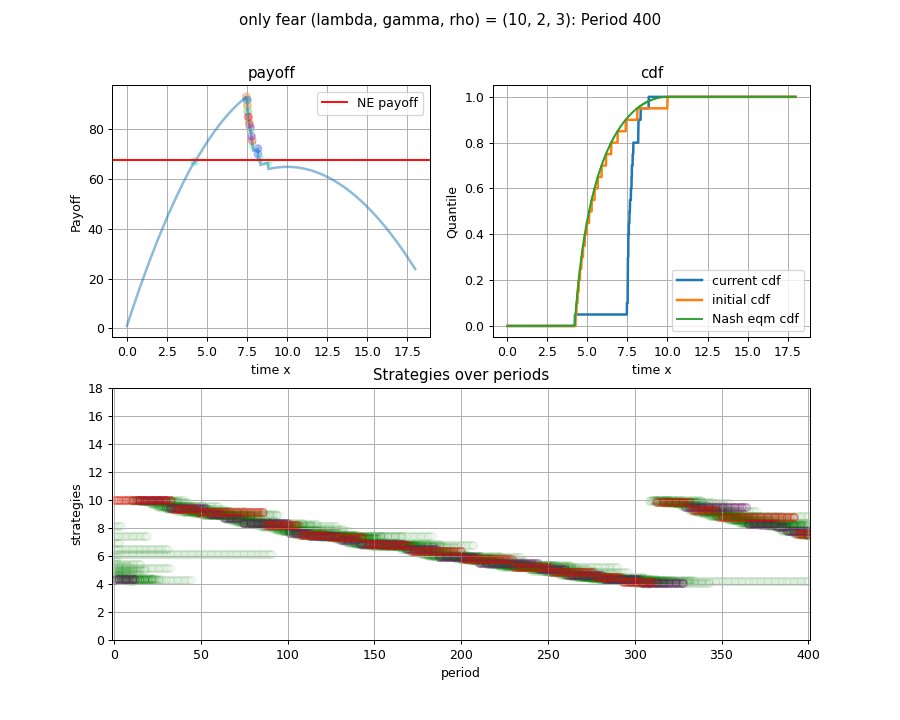

Done


In [45]:
####################################################################################
########## after finishing simulation, run this cell to make graphs ############
############################### 'graphing' cell #################################
####################################################################################

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

#calculate the average NE payoff
avg_NE_payoff = round(sum(history['bubble', 0])/sim_config['num_bots'],2)
# avg_NE_payoff = 101.0

move = [0]
for period in range(1,round_idx+1):
    move.append(len(history['selected_player_index', period])/len(history['strategies', period]))


player_index = list(range(sim_config['num_bots']))

fig = plt.figure(figsize=(10,8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])
# ax4 = fig.add_subplot(gs[2, :])
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(round_idx+1):
    ax1.clear()
    ax1.plot(history['x', i], history['y', i], alpha=0.5, linewidth = '2')
#     ax1.scatter(history['strategies', i][:first_20_percent], history['strategies_y', i][:first_20_percent],label='0-20%', marker='$1$', color='black')
#     ax1.scatter(history['strategies', i][first_20_percent:first_40_percent], history['strategies_y', i][first_20_percent:first_40_percent],label='20-40%', marker='$2$', color='r')
#     ax1.scatter(history['strategies', i][first_40_percent:first_60_percent], history['strategies_y', i][first_40_percent:first_60_percent],label='40-60%', marker='$3$', color='g')
#     ax1.scatter(history['strategies', i][first_60_percent:first_80_percent], history['strategies_y', i][first_60_percent:first_80_percent],label='60-80%', marker='$4$', color='b')
#     ax1.scatter(history['strategies', i][first_80_percent:first_100_percent], history['strategies_y', i][first_80_percent:first_100_percent],label='80-100%', marker='$5$', color='y')
    ax1.axhline(avg_NE_payoff, color='r', linestyle='-', label='NE payoff')
    graph = ax1.scatter(history['strategies', i], history['bubble', i],c = list(range(0,sim_config['num_bots'])), cmap='rainbow', alpha=0.4)
    
    ax1.set_xlabel('time x')
    ax1.set_ylabel('Payoff')
    ax1.set_title('payoff')
    ax1.grid()
    ax1.legend()

    if sim_config['game_type'] != 'other': 
        ax2.clear()
        ax2.plot(history['x', i], history['quantile', i], linewidth = '2', label='current cdf')
        ax2.plot(history['x', 0], history['quantile', 0], linewidth = '2', label='initial cdf')
        ax2.plot(strategies_cdf, cdf, label='Nash eqm cdf')
        ax2.set_xlabel('time x')
        ax2.set_ylabel('Quantile')
        ax2.set_title('cdf')
        ax2.grid()
        ax2.legend()
    else:
        ax2.clear()
        ax2.plot(history['x', i], history['quantile', i], linewidth = '2', label='current cdf')
#         ax2.plot(history['x', 0], history['quantile', 0], linewidth = '2', label='initial cdf')
        ax2.plot(strategies_cdf, cdf, label='Nash eqm cdf')
        ax2.set_xlabel('time x')
        ax2.set_ylabel('Quantile')
        ax2.set_title('cdf')
        ax2.grid()
        ax2.legend()
    
    plot_round = np.array([i]*len(history['strategies', 0]))
    ax3.plot(plot_round, history['strategies', i], 'go', fillstyle='none', alpha=0.1, zorder=1)
    ax3.plot(plot_round[0], history['strategies', i][0], color='#800080', marker='o', fillstyle='none', alpha=0.3, zorder=2)
    ax3.plot(plot_round[-1], history['strategies', i][-1], 'ro', fillstyle='none', alpha=0.3, zorder=3)
#     ax3.scatter(plot_round[0], history['strategies', i][0], color='purple', alpha=0.5, zorder=2)
#     ax3.scatter(plot_round[-1], history['strategies', i][-1], color='red', alpha=0.5, zorder=3)
#     if i==136:
#         ax3.axvline(136, color='r', linestyle='-')
#     if i==347:
#         ax3.axvline(347, color='r', linestyle='-')
#     if i==245:
#         ax3.axvline(245, color='r', linestyle='-')
#     ax3.set_xticks(list(range(0,sim_config['game_length']+1,100)) + [136,347])
    ax3.set_xlim([-1, round_idx+1])
    ax3.set_ylim([0, sim_config['xmax']])
    ax3.set_xlabel('period')
    ax3.set_ylabel('strategies')
    ax3.set_title('Strategies over periods')
    ax3.grid()

#     ax4.clear()
#     ax4.plot(list(range(i+1)), move[:i+1], alpha=0.7)
#     ax4.set_xlim([-1, round_idx+1])
#     ax4.set_ylim([0, 1.1])
#     ax4.grid()
#     ax4.set_xlabel('period')
#     ax4.set_ylabel('move percent')
#     ax4.set_title('Move percent over periods')

    
    
    plt.pause(0.001)
    fig.suptitle(game_type_specification + ' (lambda, gamma, rho) = '+ '(' + str(sim_config['lambda']) + ', ' + str(sim_config['gamma']) + ', ' + str(sim_config['rho']) + ')' + ': Period ' + str(i))
    fig.canvas.draw()
output_name = sim_config['game_type'] + '_beta'+ str(sim_config['beta'])+ '_exp'+ str(sim_config['exp'])+ '_'+ sim_config['leaving_function']+ sim_config['endogenous_type']+ str(sim_config['leaving_beta']) + '_clump' + str(sim_config['clump']) + '_lgr_' + str(sim_config['lambda']) +'_'+ str(sim_config['gamma'])+'_'+ str(sim_config['rho'])+'_' + 'bots' + str(sim_config['num_bots'])+ '_threshold_leaving' + str(sim_config['threshold_of_leaving'])+'_sampling' + str(sim_config['sampling']) +'_move' + str(sim_config['move_percent'])+'_trem'+str(sim_config['trembling']) + '_length' + str(sim_config['game_length'])+'_puri'+str(sim_config['purification_v1'])+str(sim_config['purification_v2'])+str(sim_config['purification_v3'])
fig.savefig(output_name + '_end.png', dpi=fig.dpi, bbox_inches='tight')

print('Done')

<IPython.core.display.Javascript object>


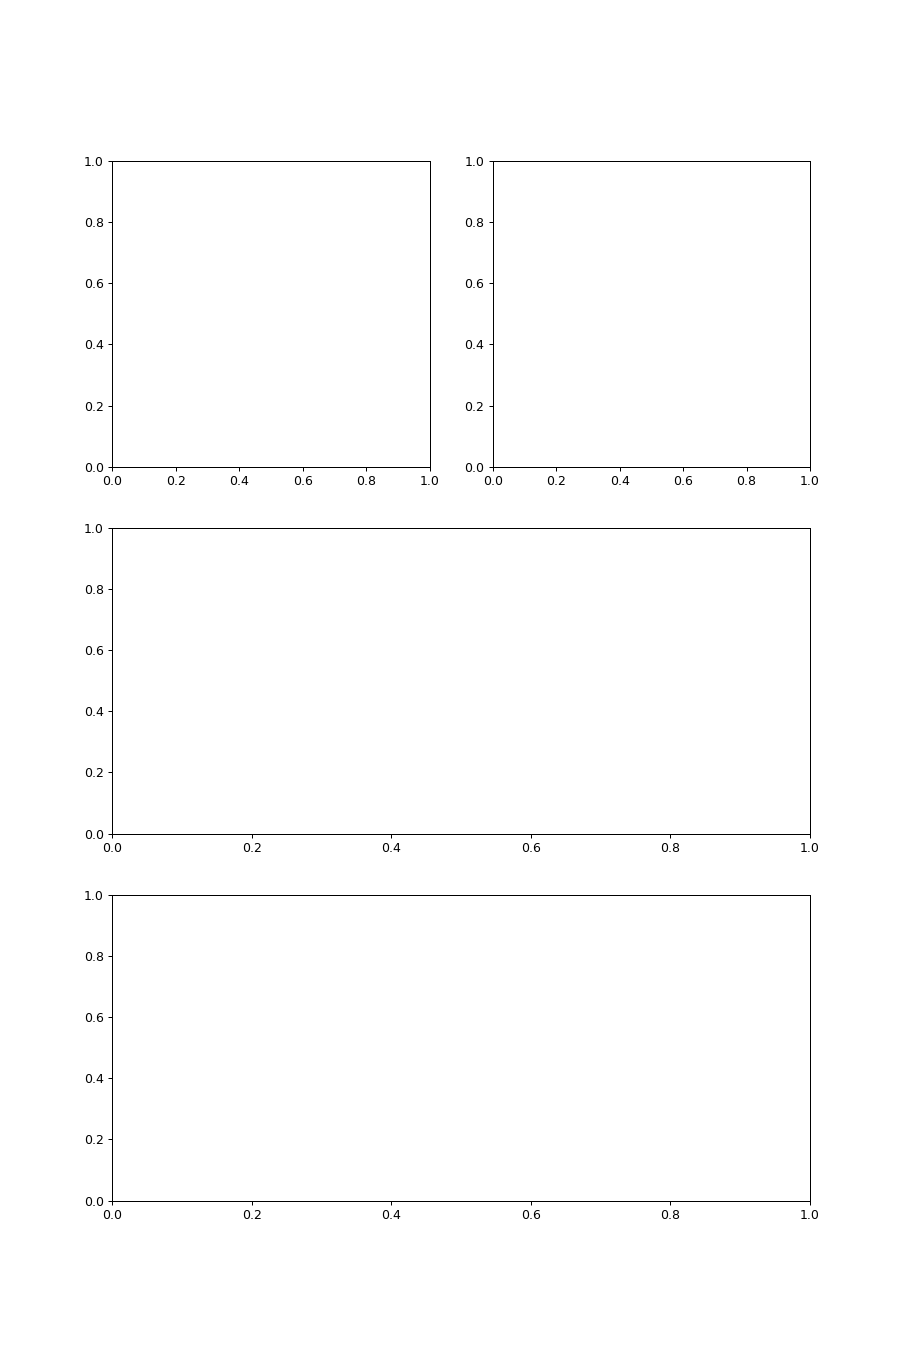

KeyError: ('x', 400)

In [4]:
####################################################################################
########## after finishing simulation, run this cell to make graphs ############
############################### 'graphing' cell #################################
####################################################################################

#use to generate the last period graph
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

move = [0]
for period in range(1,round_idx+1):
    move.append(len(history['selected_player_index', period])/len(history['strategies', period]))

fig = plt.figure(figsize=(10,15))
gs = fig.add_gridspec(3, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])
ax4 = fig.add_subplot(gs[2, :])
plt.ion()

# fig.show()
# fig.canvas.draw()
i=400

#     ax1.clear()

ax1.plot(history['x', i], history['y', i], alpha=0.5, linewidth = '2')
#     ax1.scatter(history['strategies', i][:first_20_percent], history['strategies_y', i][:first_20_percent],label='0-20%', marker='$1$', color='black')
#     ax1.scatter(history['strategies', i][first_20_percent:first_40_percent], history['strategies_y', i][first_20_percent:first_40_percent],label='20-40%', marker='$2$', color='r')
#     ax1.scatter(history['strategies', i][first_40_percent:first_60_percent], history['strategies_y', i][first_40_percent:first_60_percent],label='40-60%', marker='$3$', color='g')
#     ax1.scatter(history['strategies', i][first_60_percent:first_80_percent], history['strategies_y', i][first_60_percent:first_80_percent],label='60-80%', marker='$4$', color='b')
#     ax1.scatter(history['strategies', i][first_80_percent:first_100_percent], history['strategies_y', i][first_80_percent:first_100_percent],label='80-100%', marker='$5$', color='y')
ax1.axhline(avg_NE_payoff, color='r', linestyle='-', label='NE payoff')
graph = ax1.scatter(history['strategies', i], history['bubble', i],c = list(range(0,sim_config['num_bots'])), cmap='rainbow', alpha=0.6)

ax1.set_xlabel('time x')
ax1.set_ylabel('Payoff')
ax1.set_title('payoff')
ax1.grid()
ax1.legend()
cbar = fig.colorbar(graph, ticks=[0, 4, 9,14,19])
cbar.set_label('index')


#     ax2.clear()
# ax2.plot(history['x', i], history['quantile', i], linewidth = '2', label='current cdf', c='b')
# #     ax2.plot(history['x', 0], history['quantile', 0], linewidth = '2', label='initial cdf', c='orange')
# ax2.plot(strategies_cdf, cdf, label='Nash eqm cdf', c='g')
ax2.plot(history['x', i], history['quantile', i], linewidth = '2', label='current cdf')
ax2.plot(history['x', 0], history['quantile', 0], linewidth = '2', label='initial cdf')
ax2.plot(strategies_cdf, cdf, label='Nash eqm cdf')
ax2.set_xlabel('time x')
ax2.set_ylabel('Quantile')
ax2.set_title('cdf')
ax2.grid()
ax2.legend()
#     ax2.legend(('current cdf', 'NE cdf'))

for rd in range(i):
    plot_round = np.array([rd]*len(history['strategies', 0])) 
    ax3.plot(plot_round, history['strategies', rd], 'go', fillstyle='none', alpha=0.1, zorder=1)
    ax3.plot(plot_round[0], history['strategies', rd][0], color='#800080', marker='o', fillstyle='none', alpha=0.5, zorder=2)
    ax3.plot(plot_round[-1], history['strategies', rd][-1], 'ro', fillstyle='none', alpha=0.5, zorder=3)
#     if history['selected_player_index', i] is not None:
#         ax3.plot(i, history['strategies', i][history['selected_player_index', i]], 'bs', fillstyle='none')
#     if (history['selected_player_index', i] is not None) and (i>0):
#         ax3.plot(i, history['strategies', i-1][history['selected_player_index', i]], 'gv', fillstyle='none')
#     if i==136:
#         ax3.axvline(136, color='r', linestyle='-')
#     if i==347:
#         ax3.axvline(347, color='r', linestyle='-')
#     if i==245:
#         ax3.axvline(245, color='r', linestyle='-')
#     ax3.set_xticks(list(range(0,sim_config['game_length']+1,100)) + [136,347])    
ax3.set_xlim([-1, i+1])
ax3.set_ylim([0, sim_config['xmax']])
ax3.set_xlabel('period')
ax3.set_ylabel('strategies')
ax3.set_title('Strategies over periods')
ax3.grid()
#     ax3.legend(('all bots', 'bot(index=0)', 'bot(index=19)'))

ax4.plot(list(range(i+1)), move[:i+1], alpha=0.9)
ax4.set_xlim([-1, round_idx+1])
ax4.set_ylim([0, 1.1])
ax4.grid()
ax4.set_xlabel('period')
ax4.set_ylabel('move percent')
ax4.set_title('Move percent over periods')

ax1.text(0.2, 1.1, game_type_specification + ' (lambda, gamma, rho) = '+ '(' + str(sim_config['lambda']) + ', ' + str(sim_config['gamma']) + ', ' + str(sim_config['rho']) + ')'+ ': Period ' + str(i), transform=ax1.transAxes,fontsize = 16)
#     fig.suptitle(game_type_specification + ' game: Period ' + str(i))
#     fig.canvas.draw()

output_name = sim_config['game_type'] + '_beta'+ str(sim_config['beta'])+ '_exp'+ str(sim_config['exp'])+ '_'+ sim_config['leaving_function']+ sim_config['endogenous_type']+ str(sim_config['leaving_beta']) + '_clump' + str(sim_config['clump']) + '_lgr_' + str(sim_config['lambda']) +'_'+ str(sim_config['gamma'])+'_'+ str(sim_config['rho'])+'_' + 'bots' + str(sim_config['num_bots'])+ '_threshold_leaving' + str(sim_config['threshold_of_leaving'])+'_sampling' + str(sim_config['sampling']) +'_move' + str(sim_config['move_percent'])+'_trem'+str(sim_config['trembling']) + '_length' + str(sim_config['game_length'])+'_puri'+str(sim_config['purification_v1'])+str(sim_config['purification_v2'])+str(sim_config['purification_v3'])
fig.savefig(output_name + '_end.png', dpi=fig.dpi, bbox_inches='tight')
print('Done')

In [ ]:

print('The second strategies {}'.format(history['strategies', 19]))

print('The initial distances from the best purified/unpurified payoffs {}'.format(history['distances_from_best_payoff', 19]))



In [37]:
cycle_start = 0
cycle_end = 1000
title_name = 'fear(10,1.1,0.5);trembling0.2;1000periods;20bots;move=20%'

[101.0, 101.00098650887576, 101.03597041420116, 101.01610840236685, 101.05833905325444, 101.05534082840236, 101.03313609467456, 101.06271088757397, 101.04193029585801, 101.00042366863909, 101.05545088757397, 101.05434745562131, 101.00877360946744]
[101.0, 101.00098650887576, 101.03597041420116, 101.01610840236685, 101.05833905325444, 101.05534082840236, 101.03313609467456, 101.06271088757397, 101.04193029585801, 101.00042366863909, 101.05545088757397, 101.05434745562131, 101.00877360946744]
[10.   11.49 12.05 12.46 12.77 13.03 13.25 13.43 13.59 13.73 13.84 13.94
 14.03]


<IPython.core.display.Javascript object>


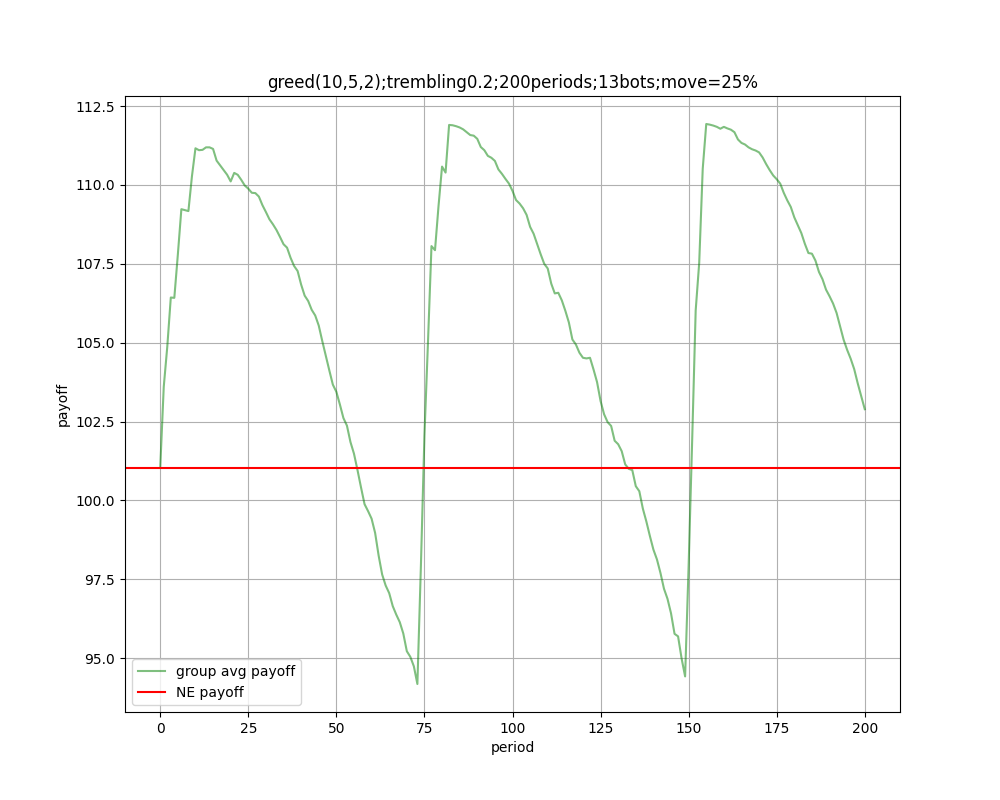

In [4]:
#group average over periods
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#calculate the average NE payoff

avg_NE_payoff = round(sum(history['bubble', 0])/sim_config['num_bots'],2)
# avg_NE_payoff = 101.0
print(history['bubble', 0])
print(history['strategies_y', 0])
print(history['strategies', 0])
periods = list(range(cycle_end+1))
group_avg_payoff_over_period = []
for i in range(cycle_end+1):
    group_avg = round(sum(history['bubble', i])/sim_config['num_bots'],2)
    group_avg_payoff_over_period.append(group_avg)
plt.figure(figsize=(10, 8))
plt.plot(periods, group_avg_payoff_over_period,color='g', alpha=0.5, label='group avg payoff')
plt.axhline(avg_NE_payoff, color='r', linestyle='-', label='NE payoff')
# plt.plot(high_type_strategy, high_type_y,color='b', alpha=0.5, label='high type')
plt.xlabel('period')
plt.ylabel('payoff')
plt.title(title_name)
plt.grid()
plt.legend()
    


output_name = sim_config['game_type'] + '_beta'+ str(sim_config['beta'])+ '_exp'+ str(sim_config['exp'])+ '_'+ sim_config['leaving_function']+ sim_config['endogenous_type']+ str(sim_config['leaving_beta']) + '_clump' + str(sim_config['clump']) + '_lgr_' + str(sim_config['lambda']) +'_'+ str(sim_config['gamma'])+'_'+ str(sim_config['rho'])+'_' + 'bots' + str(sim_config['num_bots'])+ '_threshold_leaving' + str(sim_config['threshold_of_leaving'])+'_sampling' + str(sim_config['sampling']) +'_move' + str(sim_config['move_percent'])+'_trem'+str(sim_config['trembling']) + '_length' + str(sim_config['game_length'])+'_puri'+str(sim_config['purification_v1'])+str(sim_config['purification_v2'])+str(sim_config['purification_v3'])
plt.savefig(output_name + '_purified.png', dpi=fig.dpi, bbox_inches='tight')
# # df[df['strategies_x_cycle']==2.01]
# df_copy.tail(30)

<IPython.core.display.Javascript object>


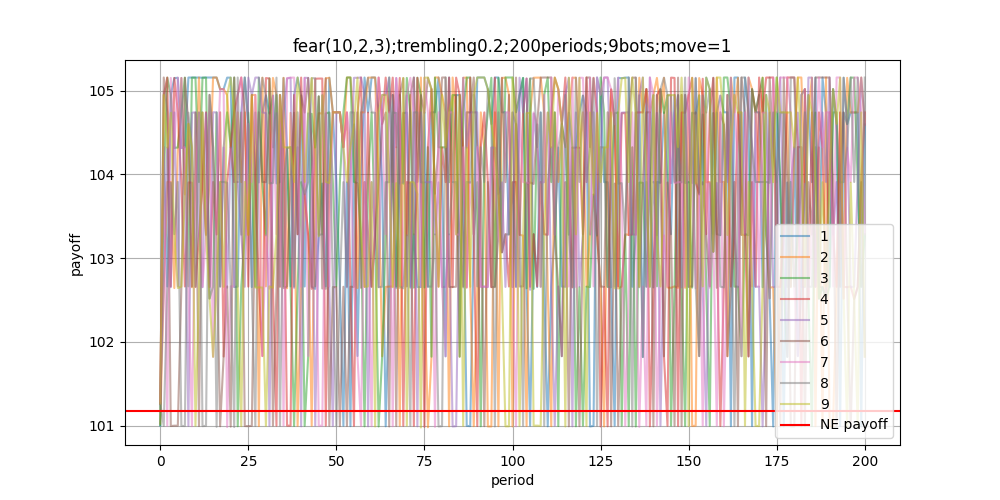

In [17]:
#individual payoff over periods
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


avg_NE_payoff = round(sum(history['bubble', 0])/sim_config['num_bots'],2)
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']
player_list = list(range(1,sim_config['num_bots']+1))
periods = list(range(cycle_end+1))
all_individual_payoff_over_period = []
for j in range(sim_config['num_bots']):
    individual_payoff_over_period = []
    for i in range(cycle_end+1):
        individual = history['bubble', i][j]
        individual_payoff_over_period.append(individual)
    all_individual_payoff_over_period.append(individual_payoff_over_period)
plt.figure(figsize=(10, 5))
for i in range(sim_config['num_bots']):
    plt.plot(periods, all_individual_payoff_over_period[i],color=color_list[i], alpha=0.5, label=player_list[i])
plt.axhline(avg_NE_payoff, color='r', linestyle='-', label='NE payoff')
    # plt.plot(high_type_strategy, high_type_y,color='b', alpha=0.5, label='high type')
plt.xlabel('period')
plt.ylabel('payoff')
plt.title(title_name)
plt.grid()
plt.legend()

67.32373333333332


<IPython.core.display.Javascript object>


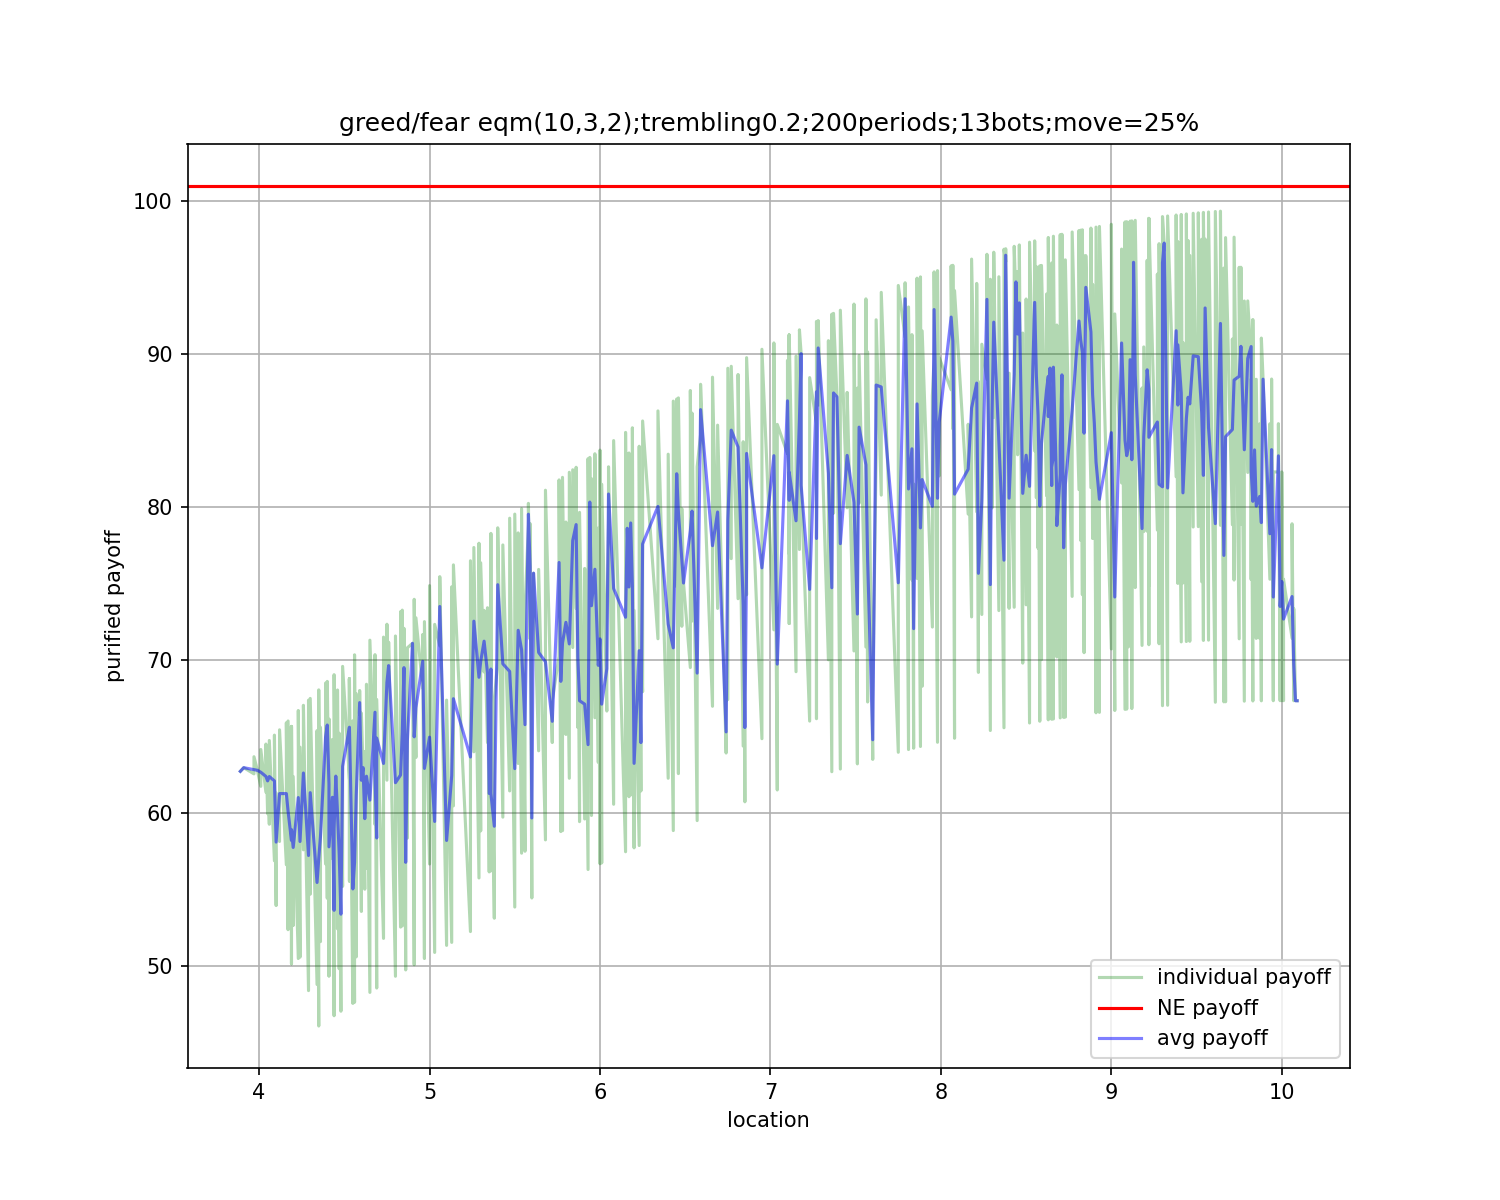

In [4]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#calculate the average NE payoff

print(min(history['bubble', 30]))
# avg_NE_payoff = round(sum(history['bubble', 0])/sim_config['num_bots'],2)
avg_NE_payoff = 101.0

strategies_y_cycle = history['strategies_y', cycle_start]
strategies_x_cycle = history['strategies', cycle_start]
high_type_strategy = []
high_type_y = []
high_type_strategy.append(history['strategies', 0][-1])
high_type_y.append(history['strategies_y', 0][-1])
for i in range(cycle_start+1,cycle_end+1):
    strategies_y_cycle = np.concatenate((strategies_y_cycle,history['strategies_y', i]),axis=0)
    strategies_x_cycle = np.concatenate((strategies_x_cycle,history['strategies', i]),axis=0)
    high_type_strategy.append(history['strategies', i][-1])
    high_type_y.append(history['strategies_y', i][-1])
# print(strategies_y_cycle)
# print(strategies_x_cycle)

df = pd.DataFrame({'strategies_x_cycle': strategies_x_cycle, 'strategies_y_cycle': strategies_y_cycle}, columns=['strategies_x_cycle', 'strategies_y_cycle'])
df_copy = df.groupby(['strategies_x_cycle']).mean().reset_index()
df=df.sort_values(by=['strategies_x_cycle', 'strategies_y_cycle'])

plt.figure(figsize=(10, 8))
plt.plot(df['strategies_x_cycle'], df['strategies_y_cycle'],color='g', alpha=0.3, label='individual payoff')
plt.axhline(avg_NE_payoff, color='r', linestyle='-', label='NE payoff')
plt.plot(df_copy['strategies_x_cycle'], df_copy['strategies_y_cycle'],color='b', alpha=0.5, label='avg payoff')
# plt.plot(high_type_strategy, high_type_y,color='b', alpha=0.5, label='high type')
plt.xlabel('location')
plt.ylabel('purified payoff')
plt.title(title_name)
plt.grid()
plt.legend()


output_name = sim_config['game_type'] + '_beta'+ str(sim_config['beta'])+ '_exp'+ str(sim_config['exp'])+ '_'+ sim_config['leaving_function']+ sim_config['endogenous_type']+ str(sim_config['leaving_beta']) + '_clump' + str(sim_config['clump']) + '_lgr_' + str(sim_config['lambda']) +'_'+ str(sim_config['gamma'])+'_'+ str(sim_config['rho'])+'_' + 'bots' + str(sim_config['num_bots'])+ '_threshold_leaving' + str(sim_config['threshold_of_leaving'])+'_sampling' + str(sim_config['sampling']) +'_move' + str(sim_config['move_percent'])+'_trem'+str(sim_config['trembling']) + '_length' + str(sim_config['game_length'])+'_puri'+str(sim_config['purification_v1'])+str(sim_config['purification_v2'])+str(sim_config['purification_v3'])
plt.savefig(output_name + '_purified.png', dpi=fig.dpi, bbox_inches='tight')
# df[df['strategies_x_cycle']==2.01]
# df_copy.tail(30)

27.48774545454546


<IPython.core.display.Javascript object>


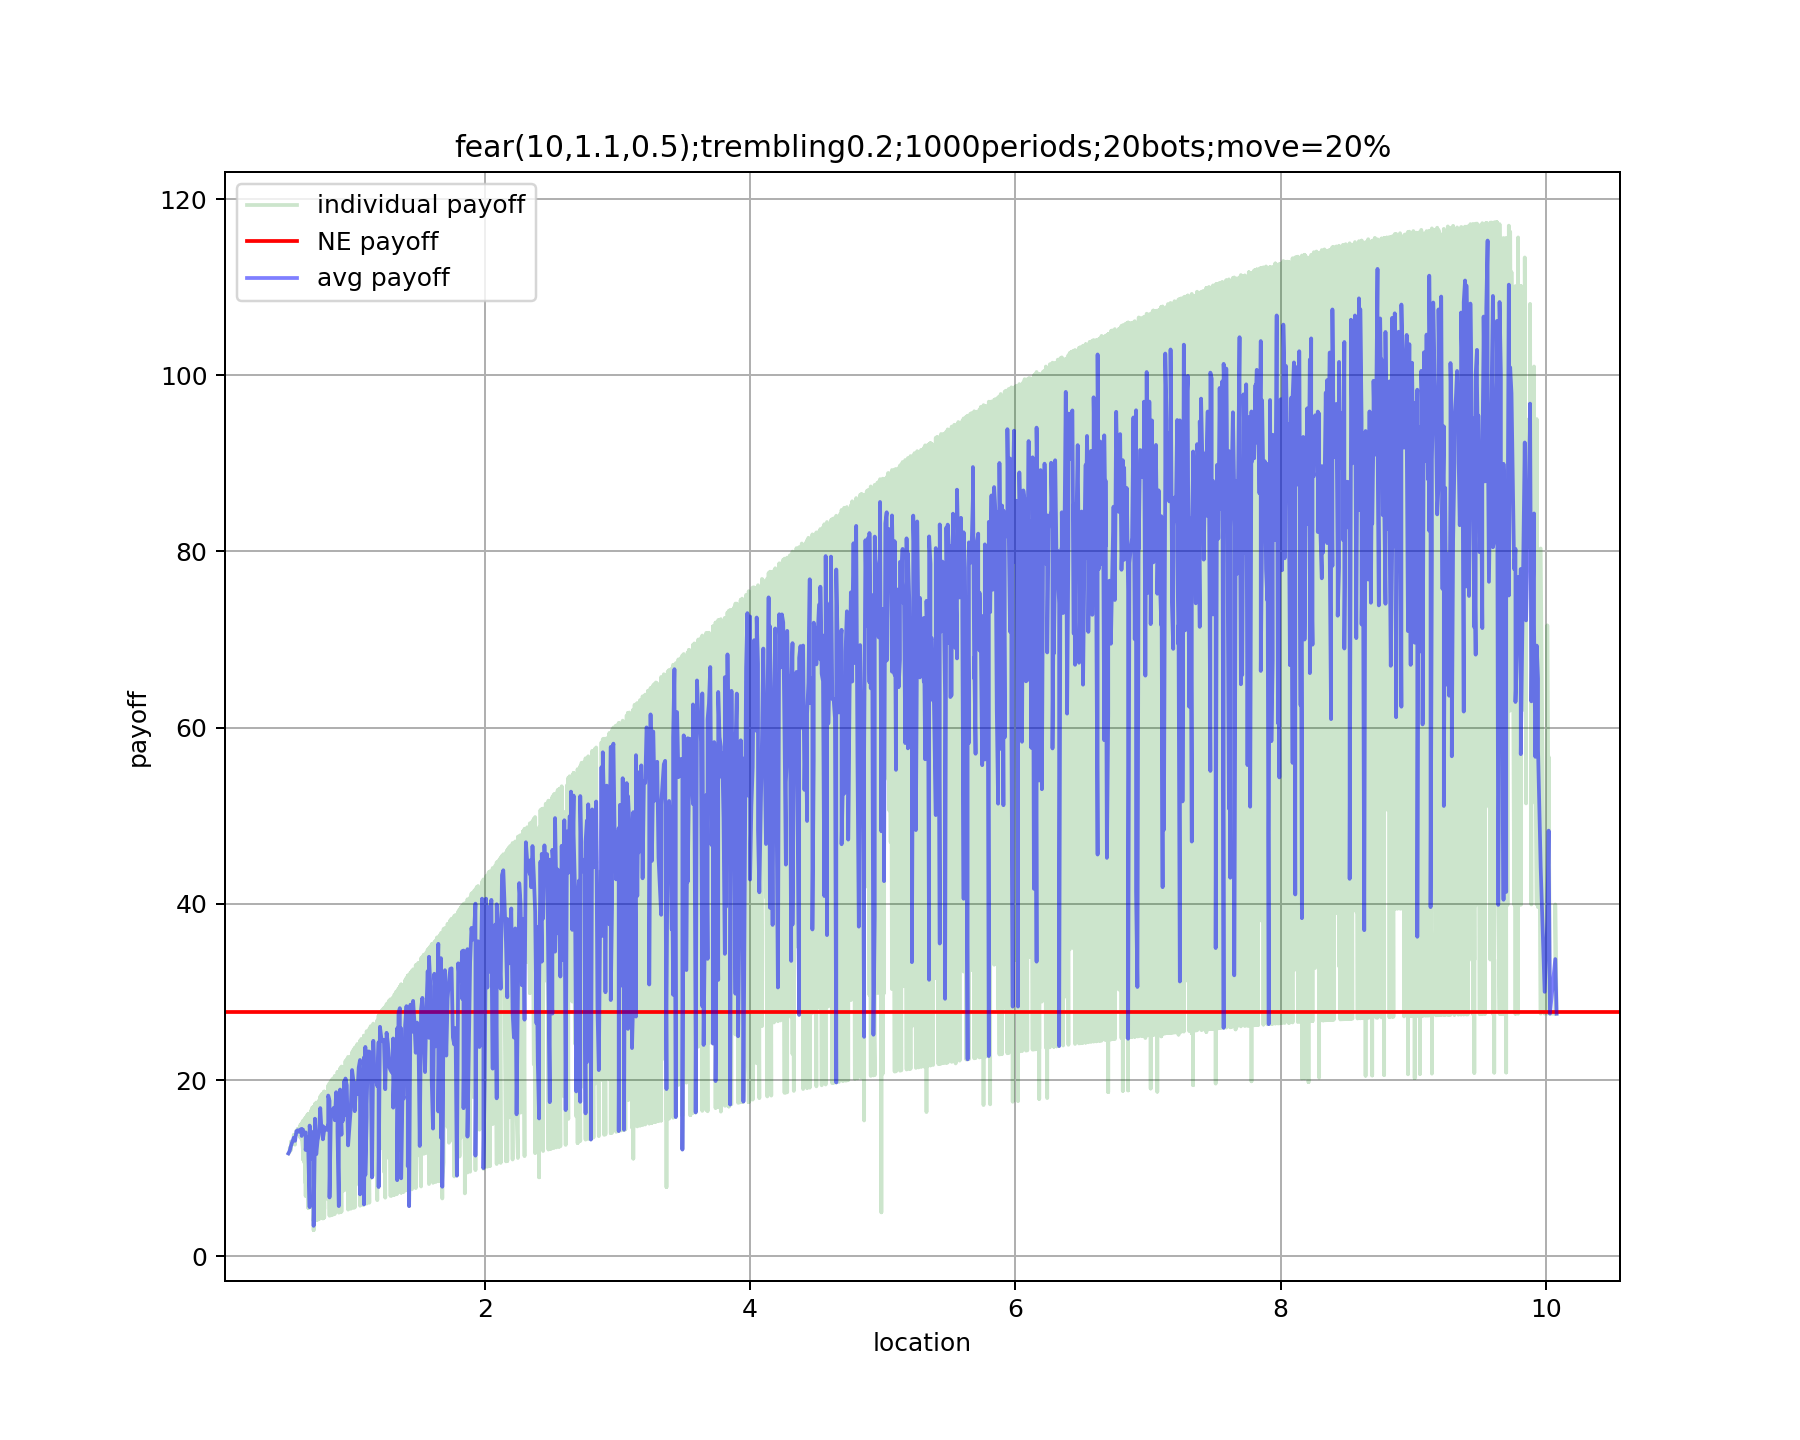

In [38]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#calculate the average NE payoff

print(min(history['bubble', 30]))
avg_NE_payoff = round(sum(history['bubble', 0])/sim_config['num_bots'],2)
# avg_NE_payoff = 101.0
strategies_y_cycle = history['strategies_y', cycle_start]
strategies_x_cycle = history['strategies', cycle_start]
high_type_strategy = []
high_type_y = []
high_type_strategy.append(history['strategies', 0][-1])
high_type_y.append(history['strategies_y', 0][-1])
for i in range(cycle_start+1,cycle_end+1):
    strategies_y_cycle = np.concatenate((strategies_y_cycle,history['bubble', i]),axis=0)
    strategies_x_cycle = np.concatenate((strategies_x_cycle,history['strategies', i]),axis=0)
    high_type_strategy.append(history['strategies', i][-1])
    high_type_y.append(history['strategies_y', i][-1])
# print(strategies_y_cycle)
# print(strategies_x_cycle)

sim_df = pd.DataFrame({'strategies_x_cycle': strategies_x_cycle, 'strategies_y_cycle': strategies_y_cycle}, columns=['strategies_x_cycle', 'strategies_y_cycle'])
sim_df_copy = sim_df.groupby(['strategies_x_cycle']).mean().reset_index()
sim_df=sim_df.sort_values(by=['strategies_x_cycle', 'strategies_y_cycle'])

plt.figure(figsize=(10, 8))
plt.plot(sim_df['strategies_x_cycle'], sim_df['strategies_y_cycle'],color='g', alpha=0.2, label='individual payoff')
plt.axhline(avg_NE_payoff, color='r', linestyle='-', label='NE payoff')
plt.plot(sim_df_copy['strategies_x_cycle'], sim_df_copy['strategies_y_cycle'],color='b', alpha=0.5, label='avg payoff')
# plt.plot(high_type_strategy, high_type_y,color='b', alpha=0.5, label='high type')
plt.xlabel('location')
# plt.ylabel('unpurified payoff')
plt.ylabel('payoff')
plt.title(title_name)
plt.grid()
plt.legend()


output_name = sim_config['game_type'] + '_beta'+ str(sim_config['beta'])+ '_exp'+ str(sim_config['exp'])+ '_'+ sim_config['leaving_function']+ sim_config['endogenous_type']+ str(sim_config['leaving_beta']) + '_clump' + str(sim_config['clump']) + '_lgr_' + str(sim_config['lambda']) +'_'+ str(sim_config['gamma'])+'_'+ str(sim_config['rho'])+'_' + 'bots' + str(sim_config['num_bots'])+ '_threshold_leaving' + str(sim_config['threshold_of_leaving'])+'_sampling' + str(sim_config['sampling']) +'_move' + str(sim_config['move_percent'])+'_trem'+str(sim_config['trembling']) + '_length' + str(sim_config['game_length'])+'_puri'+str(sim_config['purification_v1'])+str(sim_config['purification_v2'])+str(sim_config['purification_v3'])
plt.savefig(output_name + '_unpurified.png', dpi=fig.dpi, bbox_inches='tight')
# df[df['strategies_x_cycle']==2.01]
# df_copy.tail(30)

In [32]:
# apply real human data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from celluloid import Camera
from matplotlib import cm
import math
data = pd.read_csv('./Experiment_data/realpilot_10302023/timing_game_2023-10-30_cus.csv')
df_copy = pd.DataFrame(data)

<IPython.core.display.Javascript object>


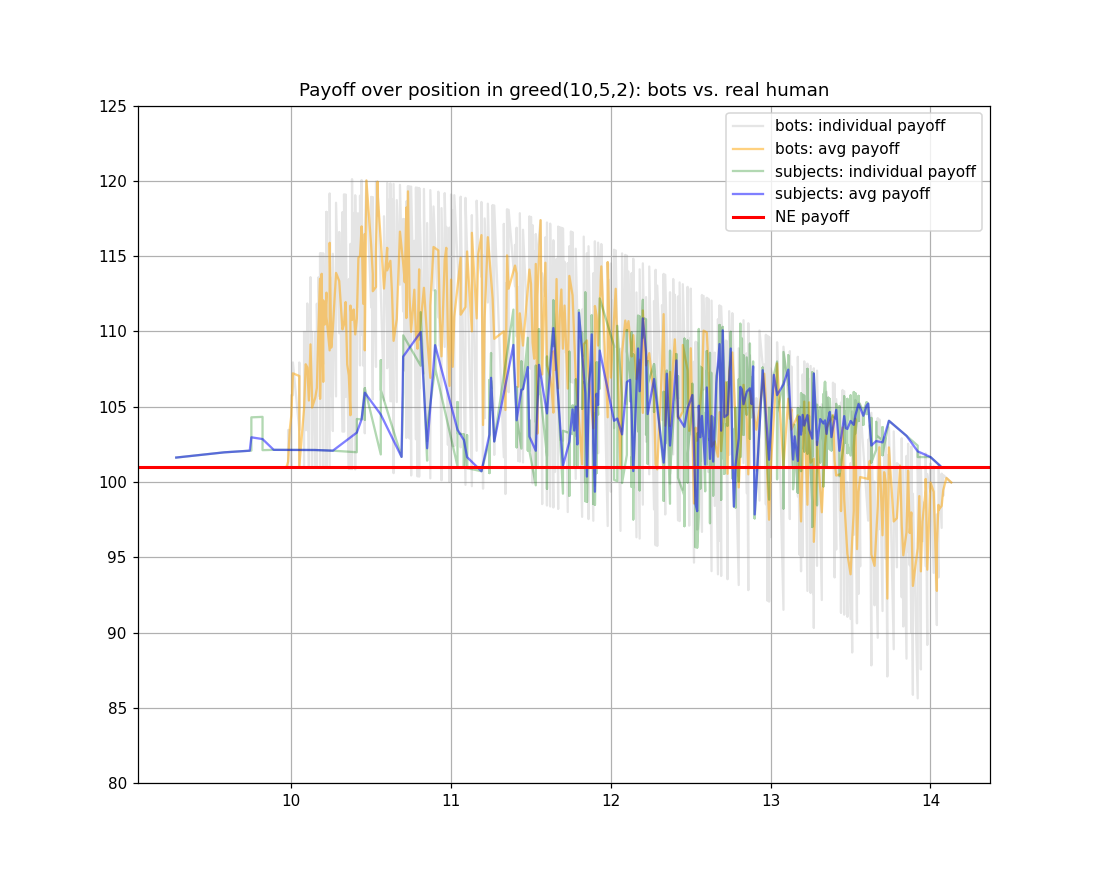

In [34]:
#generate payoffs over strategy in selected rounds
%matplotlib notebook
selected_round = 4
df = df_copy[df_copy['session'] == 'fiy4zmu5']
handles = []
labels = []
practice_num = 2
df = df[df['round_number']>practice_num] #drop practice round 1 and 2
df = df.loc[df['seconds']>25] # drop the first 25 seconds
df['round_number'] = df['round_number'] - practice_num
df = df[(df['id_in_group']!= 2)&(df['id_in_group']!= 13)&(df['id_in_group']!= 7)&(df['id_in_group']!= 10)]
ylim = [[80,125], [40,100], [0,160], [25,125]]
# yticks = [[5,19], [0,14]]
NE_support = [[10,14], [4,10], [10,16], [8,12]]
shade_color = ['g', 'olive', 'b', 'orange']
NE_payoff = [101, 67.33, 101, 101]
# player_label = list(range(1,10))

df_round = df[df['round_number']==selected_round]
subperiod = df_round.iloc[0]['subperiod']
lam = int(df_round.iloc[0]['lambda'])
gam = int(df_round.iloc[0]['gamma'])
rho = float(df_round.iloc[0]['rho'])
if rho>1:
    rho = int(rho)
freeze = int(df_round.iloc[0]['freeze_period'])
df_round = df_round.sort_values(by=['strategy'])
df_avg_payoff_position = df_round.groupby('strategy')['payoff'].mean()
df_avg_payoff_position=df_avg_payoff_position.reset_index()

plt.figure(figsize=(10, 8))
plt.plot(sim_df['strategies_x_cycle'], sim_df['strategies_y_cycle'],color='grey', alpha=0.2, label='bots: individual payoff')
# plt.axhline(avg_NE_payoff, color='r', linestyle='-', label='NE payoff')
plt.plot(sim_df_copy['strategies_x_cycle'], sim_df_copy['strategies_y_cycle'],color='orange', alpha=0.5, label='bots: avg payoff')


plt.plot(df_round['strategy'],df_round['payoff'], alpha=0.3, c='g', label='subjects: individual payoff')
plt.plot(df_avg_payoff_position['strategy'], df_avg_payoff_position['payoff'], c='b', alpha=0.5, label='subjects: avg payoff')
if (gam == 5)&(rho == 2):
    plt.ylim(ylim[0])
    plt.axhline(y=NE_payoff[0], color='r', linestyle='-',linewidth=2, label='NE payoff')

elif (gam == 2)&(rho == 3):
    plt.ylim(ylim[1])
    plt.axhline(y=NE_payoff[1], color='r', linestyle='-',linewidth=2, label='NE payoff')
elif (gam == 2)&(rho == 0.5):
    plt.ylim(ylim[2])
    plt.axhline(y=NE_payoff[2], color='r', linestyle='-',linewidth=2, label='NE payoff')  
elif (gam == 3)&(rho == 2):
    plt.ylim(ylim[3])
    plt.axhline(y=NE_payoff[3], color='r', linestyle='-',linewidth=2, label='NE payoff')
plt.legend()
plt.grid()
plt.title('Payoff over position in greed(10,5,2): bots vs. real human')
plt.show()
plt.savefig('workshop_greed_10_5_2_payoff_over_position_round4.png', dpi=fig.dpi, bbox_inches='tight')

In [ ]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#calculate the average NE payoff

print(min(history['bubble', 30]))
avg_NE_payoff = round(sum(history['bubble', 0])/sim_config['num_bots'],2)
# avg_NE_payoff = 101.0
strategies_y_cycle = history['strategies_y', cycle_start]
strategies_x_cycle = history['strategies', cycle_start]
high_type_strategy = []
high_type_y = []
low_type_strategy = []
low_type_y = []
high_type_strategy.append(history['strategies', 0][-1])
high_type_y.append(history['strategies_y', 0][-1])
low_type_strategy.append(history['strategies', 0][0])
low_type_y.append(history['strategies_y', 0][0])
for i in range(cycle_start+1,cycle_end+1):
    strategies_y_cycle = np.concatenate((strategies_y_cycle,history['strategies_y', i]),axis=0)
    strategies_x_cycle = np.concatenate((strategies_x_cycle,history['strategies', i]),axis=0)
    high_type_strategy.append(history['strategies', i][-1])
    high_type_y.append(history['strategies_y', i][-1])
    low_type_strategy.append(history['strategies', i][0])
    low_type_y.append(history['strategies_y', i][0])    
# print(strategies_y_cycle)
# print(strategies_x_cycle)

df = pd.DataFrame({'strategies_x_cycle': strategies_x_cycle, 'strategies_y_cycle': strategies_y_cycle}, columns=['strategies_x_cycle', 'strategies_y_cycle'])
df_copy = df.groupby(['strategies_x_cycle']).mean().reset_index()
df=df.sort_values(by=['strategies_x_cycle', 'strategies_y_cycle'])

df_high = pd.DataFrame({'high_type_strategy': high_type_strategy, 'high_type_y': high_type_y}, columns=['high_type_strategy', 'high_type_y'])
df_high_copy = df_high.groupby(['high_type_strategy']).mean().reset_index()


df_low = pd.DataFrame({'low_type_strategy': low_type_strategy, 'low_type_y': low_type_y}, columns=['low_type_strategy', 'low_type_y'])
df_low_copy = df_low.groupby(['low_type_strategy']).mean().reset_index()


plt.figure(figsize=(10, 8))
plt.plot(df['strategies_x_cycle'], df['strategies_y_cycle'],color='g', alpha=0.3, label='individual payoff')
plt.axhline(avg_NE_payoff, color='r', linestyle='-', label='NE payoff')
plt.scatter(high_type_strategy, high_type_y,color='r', alpha=0.2, label='high type(index=49)')
plt.scatter(low_type_strategy, low_type_y,color='purple', alpha=0.2, label='low type(index=0)')
# plt.plot(df_high_copy['high_type_strategy'], df_high_copy['high_type_y'],color='r', alpha=0.6, label='avg high type')
# plt.plot(df_low_copy['low_type_strategy'], df_low_copy['low_type_y'],color='purple', alpha=0.6, label='avg low type')
plt.plot(df_copy['strategies_x_cycle'], df_copy['strategies_y_cycle'],color='g', alpha=0.6, label='avg payoff')

plt.xlabel('location')
plt.ylabel('purified payoff')
plt.title(title_name)
plt.grid()
plt.legend()

# plt.hist(low_type_strategy,bins=20, alpha=0.2)
# plt.hist(high_type_strategy,bins=20, alpha=0.2)
output_name = sim_config['game_type'] + '_beta'+ str(sim_config['beta'])+ '_exp'+ str(sim_config['exp'])+ '_'+ sim_config['leaving_function']+ sim_config['endogenous_type']+ str(sim_config['leaving_beta']) + '_clump' + str(sim_config['clump']) + '_lgr_' + str(sim_config['lambda']) +'_'+ str(sim_config['gamma'])+'_'+ str(sim_config['rho'])+'_' + 'bots' + str(sim_config['num_bots'])+ '_threshold_leaving' + str(sim_config['threshold_of_leaving'])+'_sampling' + str(sim_config['sampling']) +'_move' + str(sim_config['move_percent'])+'_trem'+str(sim_config['trembling']) + '_length' + str(sim_config['game_length'])+'_puri'+str(sim_config['purification_v1'])+str(sim_config['purification_v2'])+str(sim_config['purification_v3'])
plt.savefig(output_name + '_purified_withdots.png', dpi=fig.dpi, bbox_inches='tight')
# df[df['strategies_x_cycle']==2.01]
# df_copy.tail(30)

In [ ]:
#avg of high types and low types
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#calculate the average NE payoff

print(min(history['bubble', 30]))
avg_NE_payoff = round(sum(history['bubble', 0])/sim_config['num_bots'],2)
# avg_NE_payoff = 101.0

strategies_y_cycle = history['strategies_y', cycle_start]
strategies_x_cycle = history['strategies', cycle_start]
high_type_strategy = []
high_type_y = []
low_type_strategy = []
low_type_y = []
high_type_strategy.append(history['strategies', 0][-1])
high_type_y.append(history['strategies_y', 0][-1])
low_type_strategy.append(history['strategies', 0][0])
low_type_y.append(history['strategies_y', 0][0])

high_types_strategies_y_cycle = history['strategies_y', cycle_start][-10:]
high_types_strategies_x_cycle = history['strategies', cycle_start][-10:]

low_types_strategies_y_cycle = history['strategies_y', cycle_start][:9]
low_types_strategies_x_cycle = history['strategies', cycle_start][:9]

for i in range(cycle_start+1,cycle_end+1):
    strategies_y_cycle = np.concatenate((strategies_y_cycle,history['strategies_y', i]),axis=0)
    strategies_x_cycle = np.concatenate((strategies_x_cycle,history['strategies', i]),axis=0)

    high_types_strategies_y_cycle = np.concatenate((high_types_strategies_y_cycle,history['strategies_y', i][-10:]),axis=0)
    high_types_strategies_x_cycle = np.concatenate((high_types_strategies_x_cycle,history['strategies', i][-10:]),axis=0)
    
    low_types_strategies_y_cycle = np.concatenate((low_types_strategies_y_cycle,history['strategies_y', i][:9]),axis=0)
    low_types_strategies_x_cycle = np.concatenate((low_types_strategies_x_cycle,history['strategies', i][:9]),axis=0)
    
    high_type_strategy.append(history['strategies', i][-1])
    high_type_y.append(history['strategies_y', i][-1])
    low_type_strategy.append(history['strategies', i][0])
    low_type_y.append(history['strategies_y', i][0])    
# print(strategies_y_cycle)
# print(strategies_x_cycle)

df = pd.DataFrame({'strategies_x_cycle': strategies_x_cycle, 'strategies_y_cycle': strategies_y_cycle}, columns=['strategies_x_cycle', 'strategies_y_cycle'])
df_copy = df.groupby(['strategies_x_cycle']).mean().reset_index()
df=df.sort_values(by=['strategies_x_cycle', 'strategies_y_cycle'])


df_high_types = pd.DataFrame({'high_types_strategies_x_cycle': high_types_strategies_x_cycle, 'high_types_strategies_y_cycle': high_types_strategies_y_cycle}, columns=['high_types_strategies_x_cycle', 'high_types_strategies_y_cycle'])
df_high_types_copy = df_high_types.groupby(['high_types_strategies_x_cycle']).mean().reset_index()
df_high_types=df_high_types_copy.sort_values(by=['high_types_strategies_x_cycle', 'high_types_strategies_y_cycle'])

df_low_types = pd.DataFrame({'low_types_strategies_x_cycle': low_types_strategies_x_cycle, 'low_types_strategies_y_cycle': low_types_strategies_y_cycle}, columns=['low_types_strategies_x_cycle', 'low_types_strategies_y_cycle'])
df_low_types_copy = df_low_types.groupby(['low_types_strategies_x_cycle']).mean().reset_index()
df_low_types=df_low_types_copy.sort_values(by=['low_types_strategies_x_cycle', 'low_types_strategies_y_cycle'])


df_high = pd.DataFrame({'high_type_strategy': high_type_strategy, 'high_type_y': high_type_y}, columns=['high_type_strategy', 'high_type_y'])
df_high_copy = df_high.groupby(['high_type_strategy']).mean().reset_index()


df_low = pd.DataFrame({'low_type_strategy': low_type_strategy, 'low_type_y': low_type_y}, columns=['low_type_strategy', 'low_type_y'])
df_low_copy = df_low.groupby(['low_type_strategy']).mean().reset_index()


plt.figure(figsize=(10, 8))
plt.plot(df['strategies_x_cycle'], df['strategies_y_cycle'],color='g', alpha=0.3, label='individual payoff')
plt.axhline(avg_NE_payoff, color='r', linestyle='-', label='NE payoff')
# plt.scatter(high_type_strategy, high_type_y,color='r', alpha=0.2, label='high type(index=49)')
# plt.scatter(low_type_strategy, low_type_y,color='purple', alpha=0.2, label='low type(index=0)')
plt.plot(df_high_types['high_types_strategies_x_cycle'], df_high_types['high_types_strategies_y_cycle'],color='r', alpha=0.4, label='avg payoffs of high types(index=40-49)')
plt.plot(df_low_types['low_types_strategies_x_cycle'], df_low_types['low_types_strategies_y_cycle'],color='b', alpha=0.4, label='avg payoffs of low types(index=0-9)')
# plt.plot(df_high_copy['high_type_strategy'], df_high_copy['high_type_y'],color='r', alpha=0.6, label='avg high type')
# plt.plot(df_low_copy['low_type_strategy'], df_low_copy['low_type_y'],color='purple', alpha=0.6, label='avg low type')
plt.plot(df_copy['strategies_x_cycle'], df_copy['strategies_y_cycle'],color='g', alpha=0.6, label='avg payoff')

plt.xlabel('location')
plt.ylabel('purified payoff')
plt.title(title_name)
plt.grid()
plt.legend()

# plt.hist(low_type_strategy,bins=20, alpha=0.2)
# plt.hist(high_type_strategy,bins=20, alpha=0.2)
output_name = sim_config['game_type'] + '_beta'+ str(sim_config['beta'])+ '_exp'+ str(sim_config['exp'])+ '_'+ sim_config['leaving_function']+ sim_config['endogenous_type']+ str(sim_config['leaving_beta']) + '_clump' + str(sim_config['clump']) + '_lgr_' + str(sim_config['lambda']) +'_'+ str(sim_config['gamma'])+'_'+ str(sim_config['rho'])+'_' + 'bots' + str(sim_config['num_bots'])+ '_threshold_leaving' + str(sim_config['threshold_of_leaving'])+'_sampling' + str(sim_config['sampling']) +'_move' + str(sim_config['move_percent'])+'_trem'+str(sim_config['trembling']) + '_length' + str(sim_config['game_length'])+'_puri'+str(sim_config['purification_v1'])+str(sim_config['purification_v2'])+str(sim_config['purification_v3'])
plt.savefig(output_name + '_purified_dots_types.png', dpi=fig.dpi, bbox_inches='tight')

The "1" meaning the first 20% bots with the smaller index,...


For example, if we have 20 bots, "1" means the players with index from 0 to 4;"2" means the players with index from 5 to 9


<IPython.core.display.Javascript object>


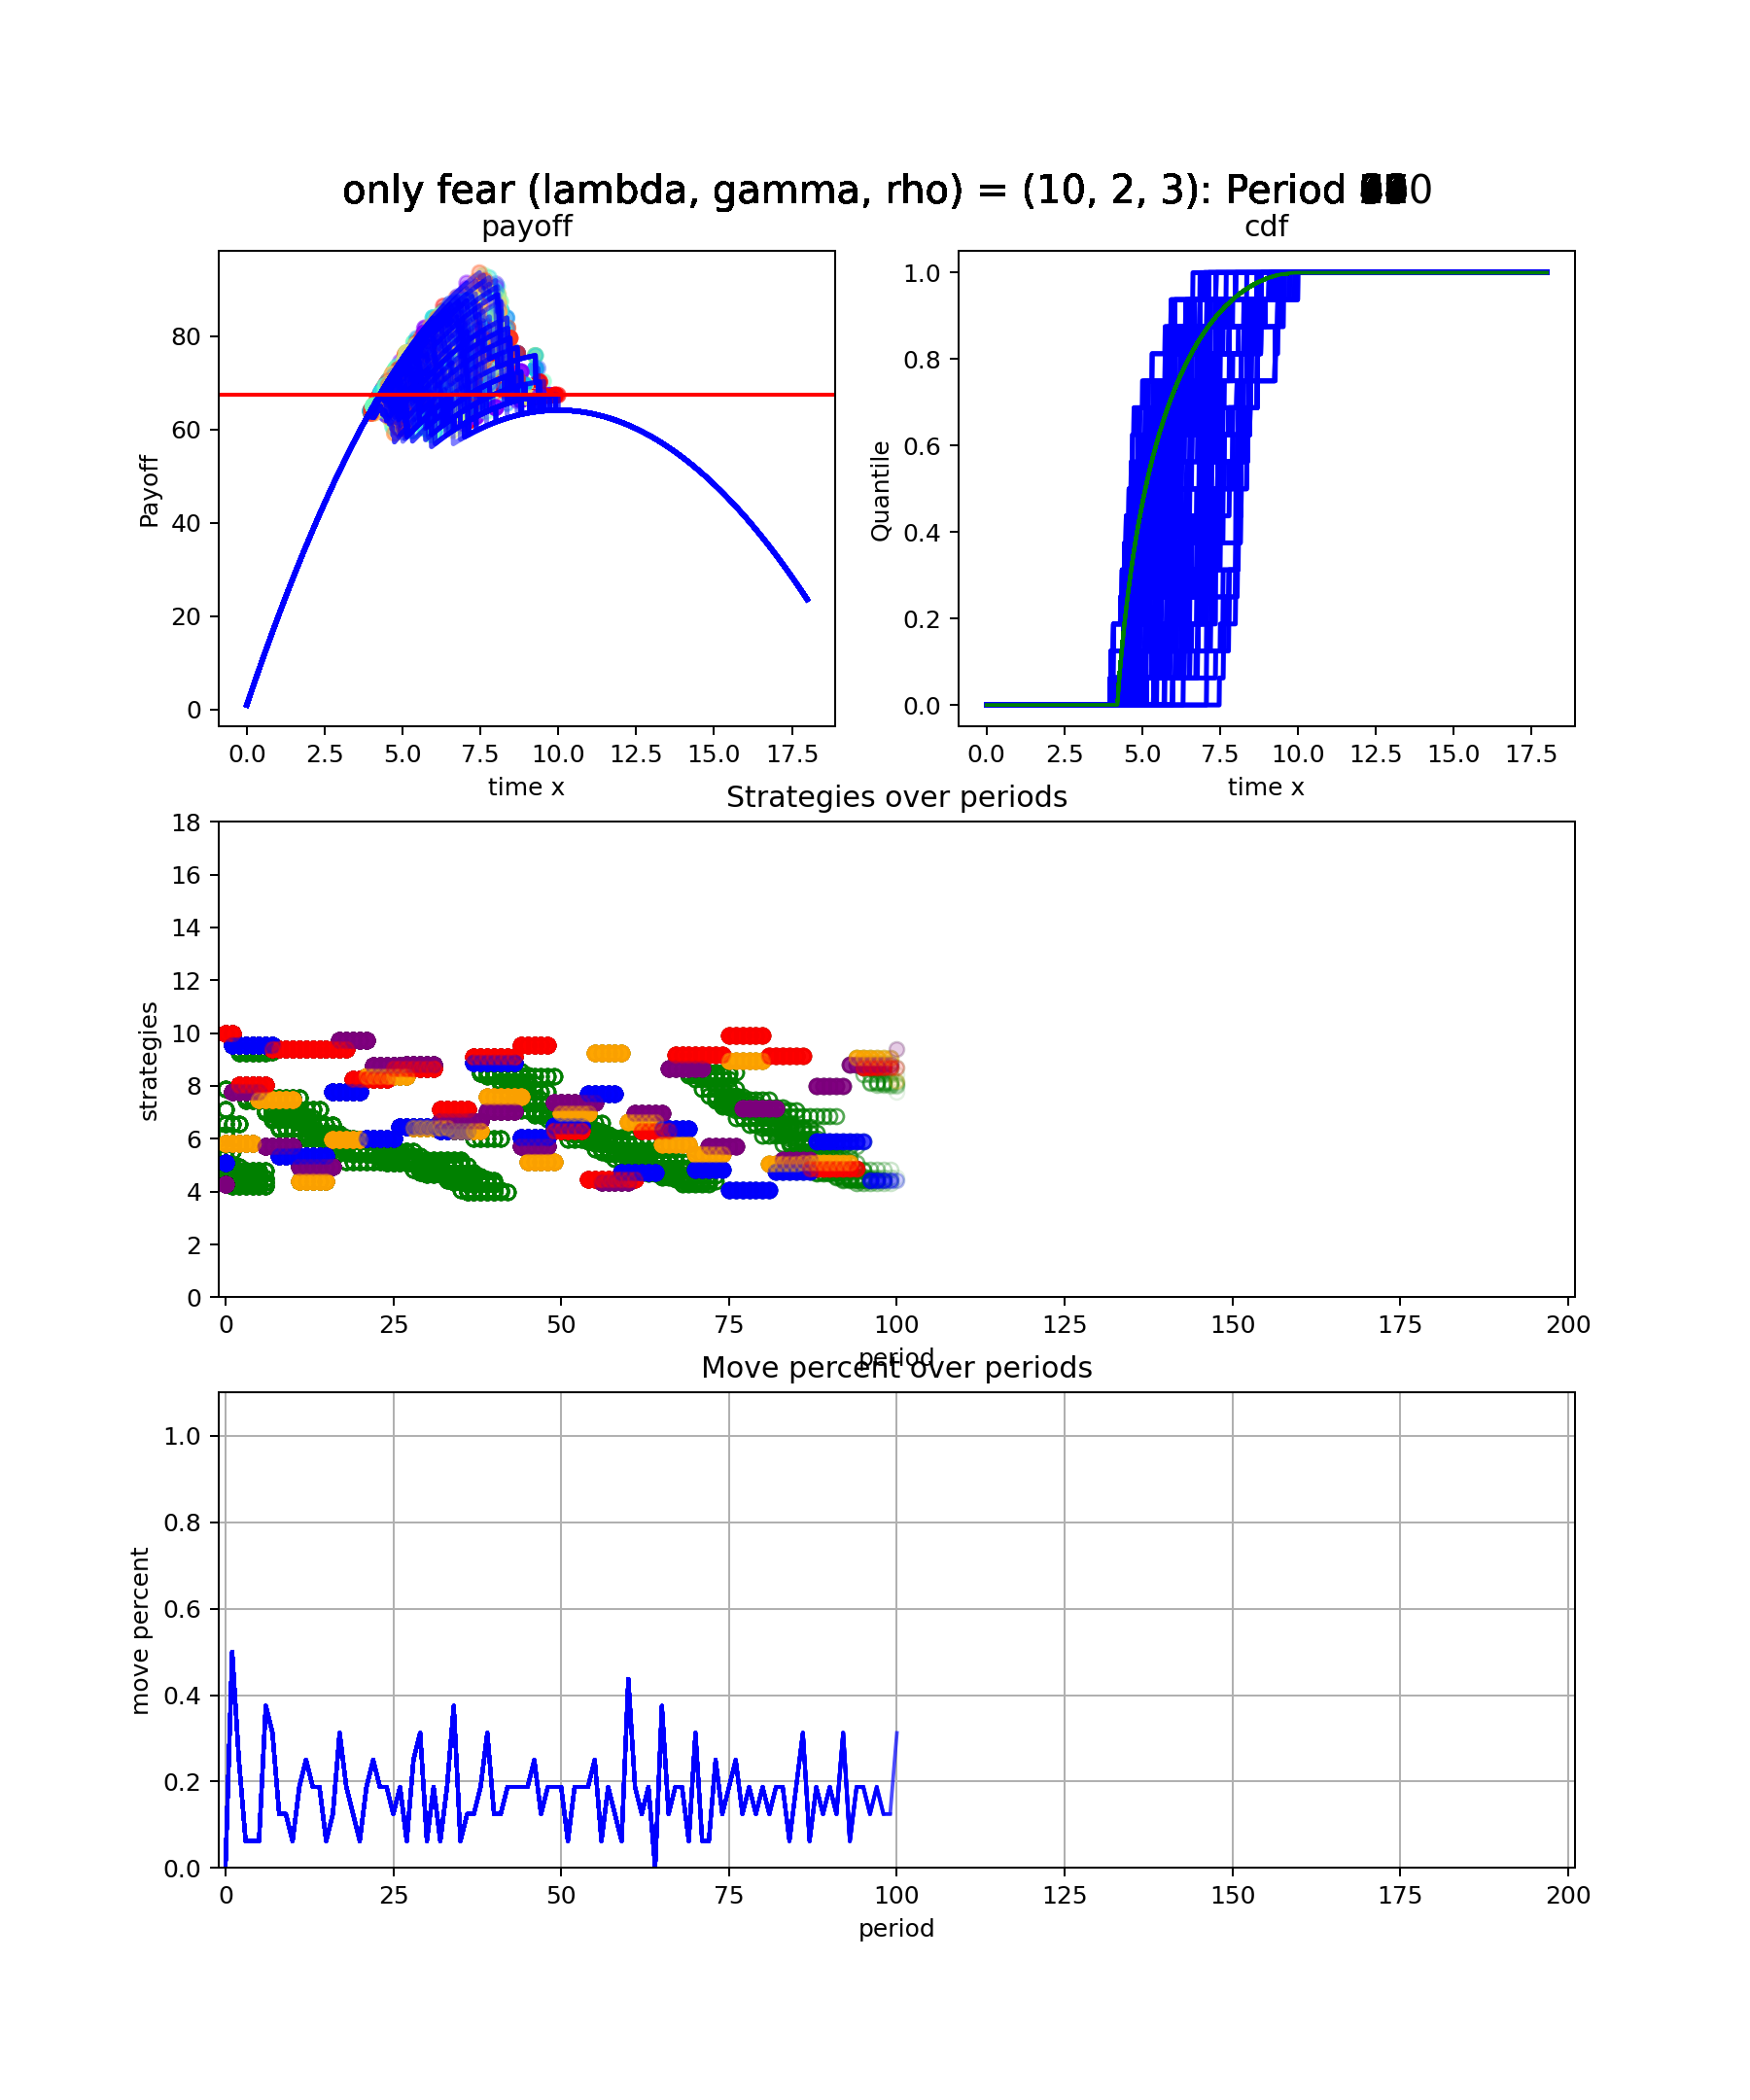

ValueError: x and y must have same first dimension, but have shapes (102,) and (101,)

In [55]:
####################################################################################
########## after finishing simulation, run this cell to make graphs ############
############################### 'graphing' cell #################################
####################################################################################

range_end=200

import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera

fig = plt.figure(figsize=(10,12))
camera = Camera(fig)
gs = fig.add_gridspec(3, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])
ax4 = fig.add_subplot(gs[2, :])
plt.ion()

# fig.show()
# fig.canvas.draw()

for i in range(range_end+1):
#     ax1.clear()
    
    ax1.plot(history['x', i], history['y', i], alpha=0.5, linewidth = '2', c='b')
    ax1.axhline(avg_NE_payoff, color='r', linestyle='-', label='NE payoff')
    graph = ax1.scatter(history['strategies', i], history['bubble', i],c = list(range(0,sim_config['num_bots'])), cmap='rainbow', alpha=0.4)
    ax1.set_xlabel('time x')
    ax1.set_ylabel('Payoff')
    ax1.set_title('payoff')
#     ax1.set_ylim([0, 500])
    ax1.grid()
    

    
#     ax2.clear()
    ax2.plot(history['x', i], history['quantile', i], linewidth = '2', label='current cdf', c='b')
#     ax2.plot(history['x', 0], history['quantile', 0], linewidth = '2', label='initial cdf', c='orange')
    ax2.plot(strategies_cdf, cdf, label='Nash eqm cdf', c='g')
    ax2.set_xlabel('time x')
    ax2.set_ylabel('Quantile')
    ax2.set_title('cdf')
    ax2.grid()
#     ax2.legend(('current cdf', 'NE cdf'))
    
    for rd in range(i):
        plot_round = np.array([rd]*len(history['strategies', 0])) 
        ax3.plot(plot_round, history['strategies', rd], 'go', fillstyle='none', alpha=0.1, zorder=1)
        for outlier in range(len(sim_config['outlier_index_set'])):
            ax3.plot(plot_round[sim_config['outlier_index_set'][outlier]], history['strategies', rd][sim_config['outlier_index_set'][outlier]],color=outlier_color_set[outlier], marker='o', alpha=0.2, zorder=2)
#             ax3.plot(plot_round[-1], history['strategies', rd][-1], 'ro', fillstyle='none', alpha=0.5, zorder=3)
#     if history['selected_player_index', i] is not None:
#         ax3.plot(i, history['strategies', i][history['selected_player_index', i]], 'bs', fillstyle='none')
#     if (history['selected_player_index', i] is not None) and (i>0):
#         ax3.plot(i, history['strategies', i-1][history['selected_player_index', i]], 'gv', fillstyle='none')
#     if i==136:
#         ax3.axvline(136, color='r', linestyle='-')
#     if i==347:
#         ax3.axvline(347, color='r', linestyle='-')
#     if i==245:
#         ax3.axvline(245, color='r', linestyle='-')
#     ax3.set_xticks(list(range(0,sim_config['game_length']+1,100)) + [136,347])    
    ax3.set_xlim([-1, range_end+1])
    ax3.set_ylim([0, sim_config['xmax']])
    ax3.set_xlabel('period')
    ax3.set_ylabel('strategies')
    ax3.set_title('Strategies over periods')
    ax3.grid()

    ax4.plot(list(range(i+1)), move[:i+1], alpha=0.7, c='b')
    ax4.set_xlim([-1, range_end+1])
    ax4.set_ylim([0, 1.1])
    ax4.grid()
    ax4.set_xlabel('period')
    ax4.set_ylabel('move percent')
    ax4.set_title('Move percent over periods')
    
    plt.pause(0.001)
    ax1.text(0.2, 1.1, game_type_specification + ' (lambda, gamma, rho) = '+ '(' + str(sim_config['lambda']) + ', ' + str(sim_config['gamma']) + ', ' + str(sim_config['rho']) + ')'+ ': Period ' + str(i), transform=ax1.transAxes,fontsize = 16)
#     fig.suptitle(game_type_specification + ' game: Period ' + str(i))
#     fig.canvas.draw()
    camera.snap()
    
animation = camera.animate()
output_name = sim_config['game_type'] + '_beta'+ str(sim_config['beta'])+ '_exp'+ str(sim_config['exp'])+ '_'+ sim_config['leaving_function']+ sim_config['endogenous_type']+ str(sim_config['leaving_beta']) + '_clump' + str(sim_config['clump']) + '_lgr_' + str(sim_config['lambda']) +'_'+ str(sim_config['gamma'])+'_'+ str(sim_config['rho'])+'_' + 'bots' + str(sim_config['num_bots'])+ '_threshold_leaving' + str(sim_config['threshold_of_leaving'])+'_sampling' + str(sim_config['sampling']) +'_move' + str(sim_config['move_percent'])+'_trem'+str(sim_config['trembling']) + '_length' + str(sim_config['game_length'])+'_puri'+str(sim_config['purification_v1'])+str(sim_config['purification_v2'])+str(sim_config['purification_v3'])
animation.save(output_name + '.gif')    
print('Done')

<IPython.core.display.Javascript object>


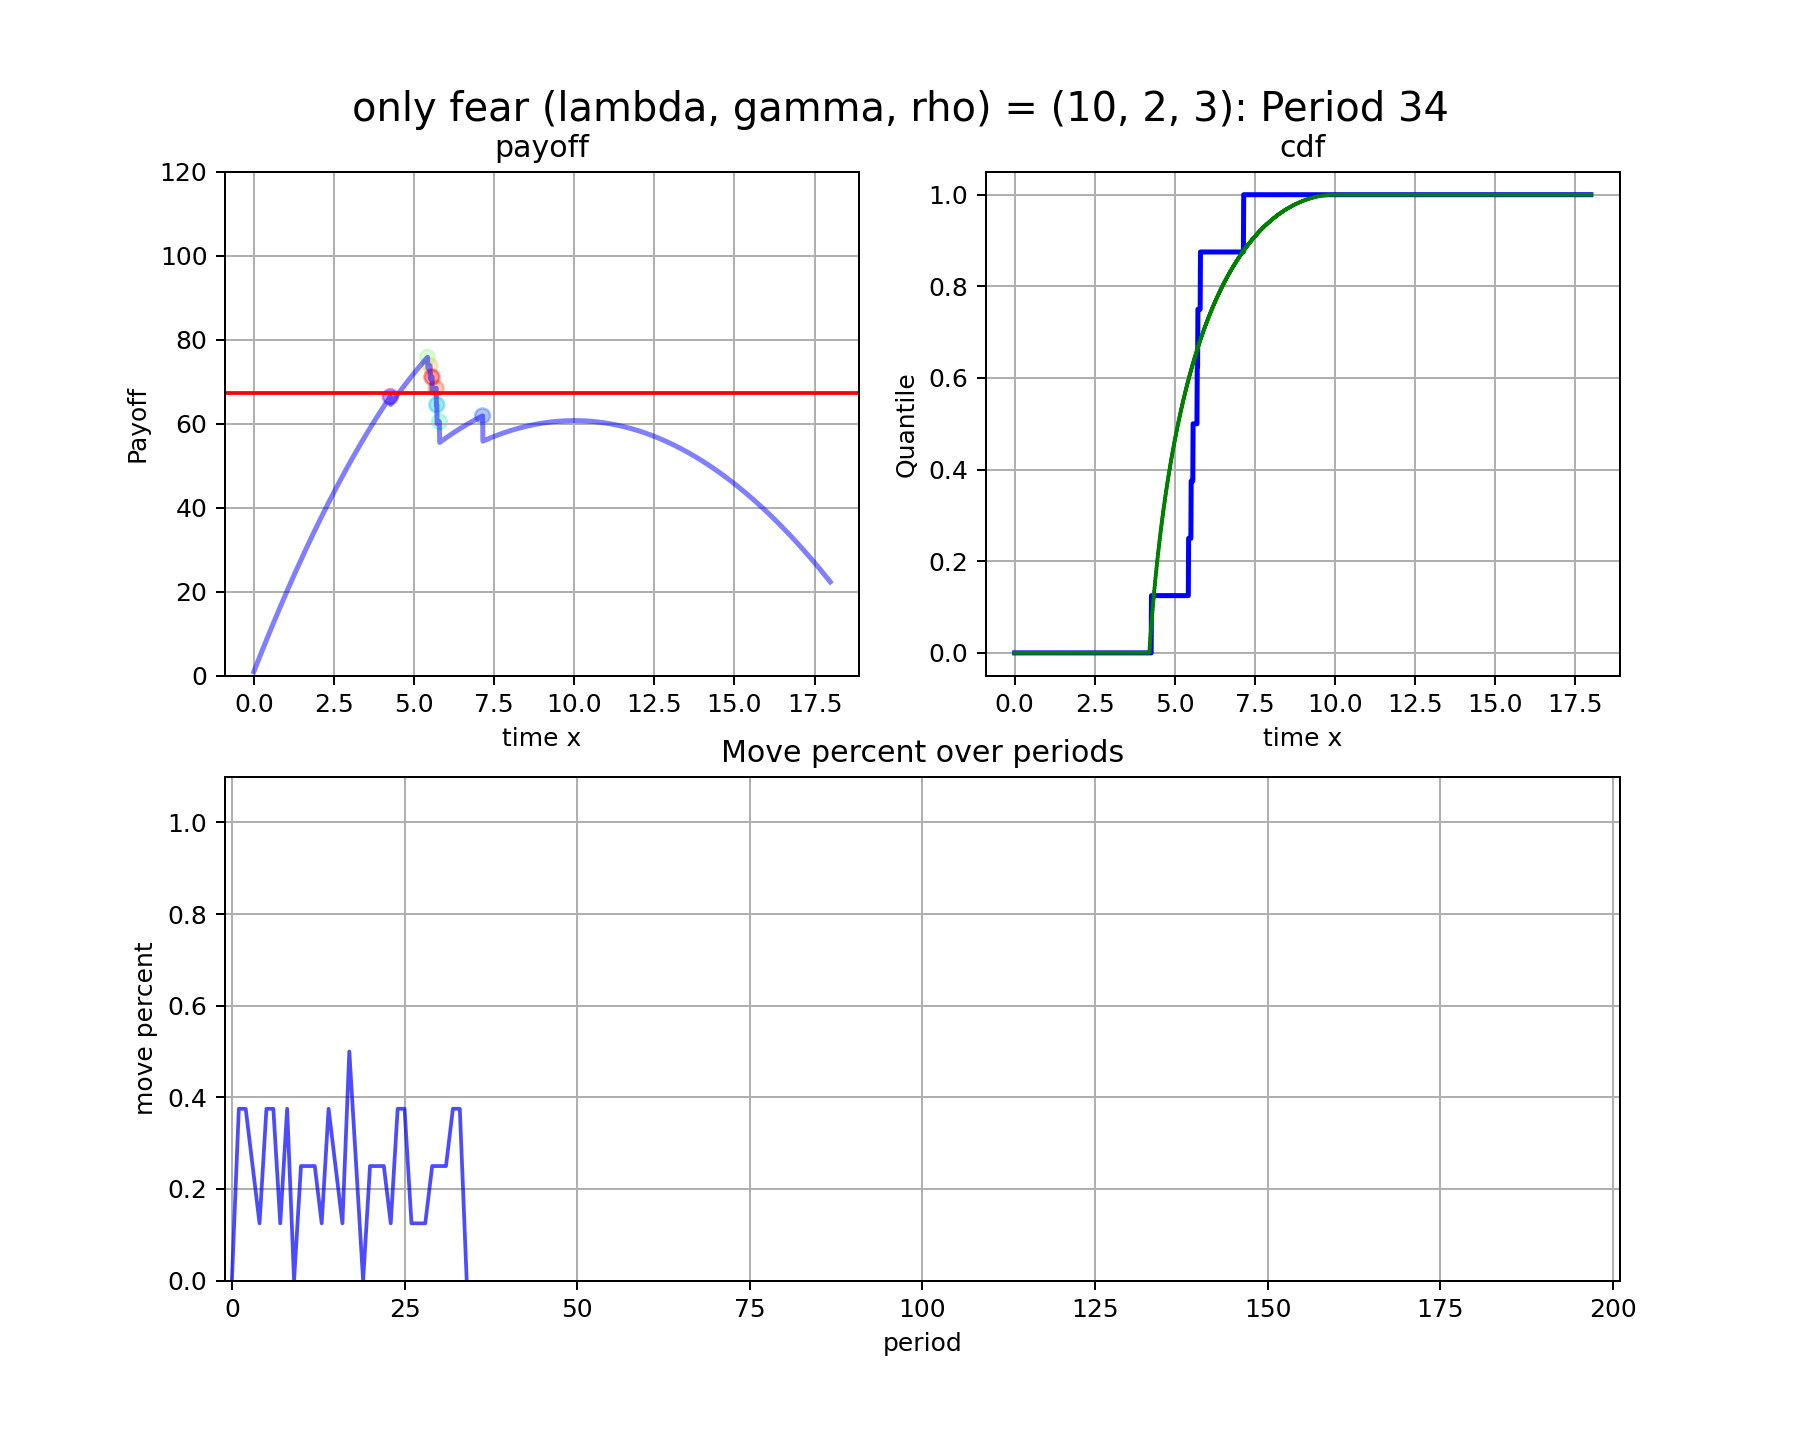

MovieWriter ffmpeg unavailable; using Pillow instead.


Done


In [20]:
####################################################################################
########## after finishing simulation, run this cell to make graphs ############
############################### 'graphing' cell #################################
####################################################################################

range_end=200

import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera

fig = plt.figure(figsize=(10,8))
camera = Camera(fig)
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])
# ax4 = fig.add_subplot(gs[2, :])
plt.ion()

# fig.show()
# fig.canvas.draw()

for i in range(range_end+1):
#     ax1.clear()
    
    ax1.plot(history['x', i], history['y', i], alpha=0.5, linewidth = '2', c='b')
    ax1.axhline(avg_NE_payoff, color='r', linestyle='-', label='NE payoff')
    graph = ax1.scatter(history['strategies', i], history['bubble', i],c = list(range(0,sim_config['num_bots'])), cmap='rainbow', alpha=0.4)
    ax1.set_xlabel('time x')
    ax1.set_ylabel('Payoff')
    ax1.set_title('payoff')
#     ax1.set_ylim([60, 120])
    ax1.set_ylim([0, 120])
    ax1.grid()
    

    
#     ax2.clear()
    ax2.plot(history['x', i], history['quantile', i], linewidth = '2', label='current cdf', c='b')
#     ax2.plot(history['x', 0], history['quantile', 0], linewidth = '2', label='initial cdf', c='orange')
    ax2.plot(strategies_cdf, cdf, label='Nash eqm cdf', c='g')
    ax2.set_xlabel('time x')
    ax2.set_ylabel('Quantile')
    ax2.set_title('cdf')
    ax2.grid()
#     ax2.legend(('current cdf', 'NE cdf'))
    
#     for rd in range(i):
#         plot_round = np.array([rd]*len(history['strategies', 0])) 
#         ax3.plot(plot_round, history['strategies', rd], 'go', fillstyle='none', alpha=0.1, zorder=1)
#         for outlier in range(len(sim_config['outlier_index_set'])):
#             ax3.plot(plot_round[sim_config['outlier_index_set'][outlier]], history['strategies', rd][sim_config['outlier_index_set'][outlier]],color=outlier_color_set[outlier], marker='o', alpha=0.2, zorder=2)
# #             ax3.plot(plot_round[-1], history['strategies', rd][-1], 'ro', fillstyle='none', alpha=0.5, zorder=3)
# #     if history['selected_player_index', i] is not None:
# #         ax3.plot(i, history['strategies', i][history['selected_player_index', i]], 'bs', fillstyle='none')
# #     if (history['selected_player_index', i] is not None) and (i>0):
# #         ax3.plot(i, history['strategies', i-1][history['selected_player_index', i]], 'gv', fillstyle='none')
# #     if i==136:
# #         ax3.axvline(136, color='r', linestyle='-')
# #     if i==347:
# #         ax3.axvline(347, color='r', linestyle='-')
# #     if i==245:
# #         ax3.axvline(245, color='r', linestyle='-')
# #     ax3.set_xticks(list(range(0,sim_config['game_length']+1,100)) + [136,347])    
#     ax3.set_xlim([-1, range_end+1])
#     ax3.set_ylim([0, sim_config['xmax']])
#     ax3.set_xlabel('period')
#     ax3.set_ylabel('strategies')
#     ax3.set_title('Strategies over periods')
#     ax3.grid()

    ax3.plot(list(range(i+1)), move[:i+1], alpha=0.7, c='b')
    ax3.set_xlim([-1, range_end+1])
    ax3.set_ylim([0, 1.1])
    ax3.grid()
    ax3.set_xlabel('period')
    ax3.set_ylabel('move percent')
    ax3.set_title('Move percent over periods')
    
    plt.pause(0.001)
    ax1.text(0.2, 1.1, game_type_specification + ' (lambda, gamma, rho) = '+ '(' + str(sim_config['lambda']) + ', ' + str(sim_config['gamma']) + ', ' + str(sim_config['rho']) + ')'+ ': Period ' + str(i), transform=ax1.transAxes,fontsize = 16)
#     fig.suptitle(game_type_specification + ' game: Period ' + str(i))
#     fig.canvas.draw()
    camera.snap()
    
animation = camera.animate()
output_name = sim_config['game_type'] + '_beta'+ str(sim_config['beta'])+ '_exp'+ str(sim_config['exp'])+ '_'+ sim_config['leaving_function']+ sim_config['endogenous_type']+ str(sim_config['leaving_beta']) + '_clump' + str(sim_config['clump']) + '_lgr_' + str(sim_config['lambda']) +'_'+ str(sim_config['gamma'])+'_'+ str(sim_config['rho'])+'_' + 'bots' + str(sim_config['num_bots'])+ '_threshold_leaving' + str(sim_config['threshold_of_leaving'])+'_sampling' + str(sim_config['sampling']) +'_move' + str(sim_config['move_percent'])+'_trem'+str(sim_config['trembling']) + '_length' + str(sim_config['game_length'])+'_puri'+str(sim_config['purification_v1'])+str(sim_config['purification_v2'])+str(sim_config['purification_v3'])
animation.save(output_name + '_8bots_2outliers_freeze2_NE.gif')    
print('Done')

<IPython.core.display.Javascript object>


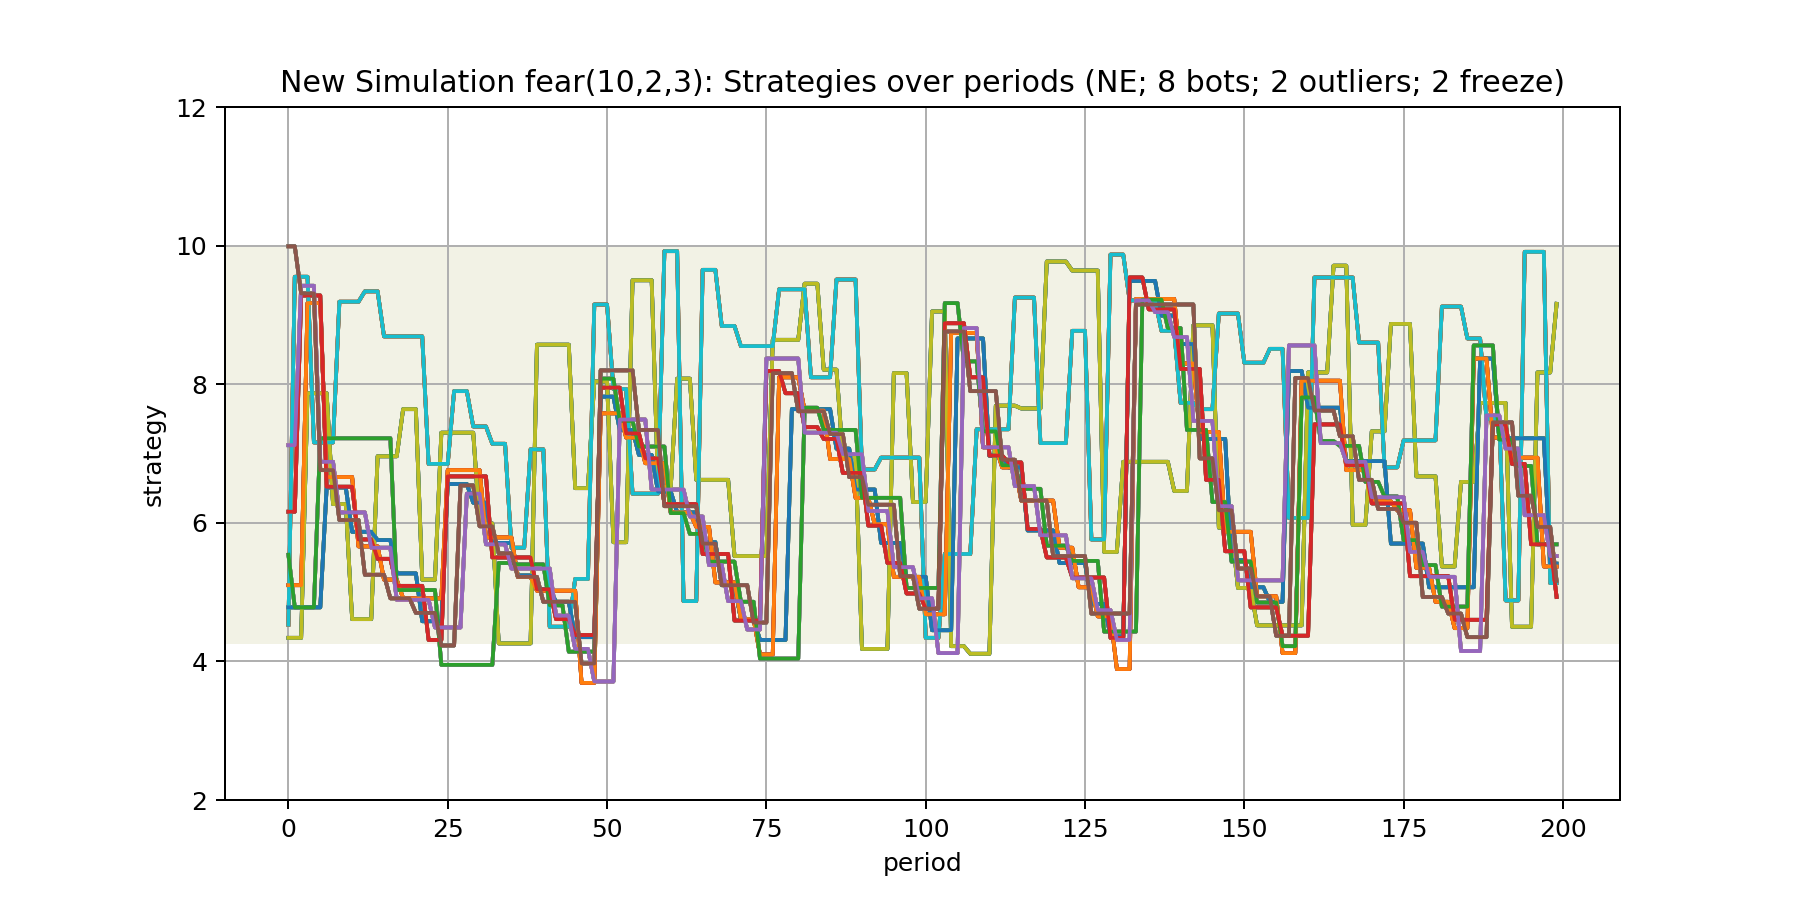

In [21]:
#generate strategies over period plot
%matplotlib notebook
NE_support = [[10,14.05], [4.25,10], [10,15.97], [10,14.05]]
col_lst = ['darkred', 'black', 'gray', 'orange', 'tan', 'yellow','olive', 'green', 'lightseagreen', 'cyan', 'blue', 'purple', 'red', 'brown','coral','powderblue']
plt.figure(figsize=(10,5))
for i in range(sim_config['num_bots']-1):
    index = i
    player_strategies = []
    player_round = []
    for round_number in range(round_idx):
        player_strategies.append(history['strategies', round_number])
        player_round.append(round_number)
    plt.plot(player_round, player_strategies)
plt.axhspan(NE_support[1][0], NE_support[1][1], facecolor ='olive', alpha = 0.1, label='NE support')
plt.title('New Simulation fear(10,2,3): Strategies over periods (NE; 8 bots; 2 outliers; 2 freeze)')    
plt.ylabel('strategy')
plt.xlabel('period')
# plt.ylim([8,18])
plt.ylim([2,12])
plt.grid()
plt.show()
output_name = sim_config['game_type'] + '_beta'+ str(sim_config['beta'])+ '_exp'+ str(sim_config['exp'])+ '_'+ sim_config['leaving_function']+ sim_config['endogenous_type']+ str(sim_config['leaving_beta']) + '_clump' + str(sim_config['clump']) + '_lgr_' + str(sim_config['lambda']) +'_'+ str(sim_config['gamma'])+'_'+ str(sim_config['rho'])+'_' + 'bots' + str(sim_config['num_bots'])+'_trem'+str(sim_config['trembling']) + '_length' + str(sim_config['game_length'])
plt.savefig('strategies_over_period'+ output_name + '_8bots_2outliers_freeze2_NE.png', dpi=fig.dpi, bbox_inches='tight')   